In [ ]:
doc = """Bias is an error introduced in the model due to the oversimplification of the algorithm used (does
not fit the data properly). It can lead to under-fitting.Low bias machine learning algorithms — Decision Trees, k-NN and SVM High bias machine learning algorithms — Linear Regression, Logistic Regression
Variance: Variance is error introduced in the model due to a too complex algorithm, it performs very well in the training set but poorly in the test set. It can lead to high sensitivity and overfitting.
Possible high variance – polynomial regression Normally, as you increase the complexity of your model, you will see a reduction in error due to lower bias in the model. However, this only happens until a particular point. As you continue to make your model
more complex, you end up over-fitting your model and hence your model will start suffering from high
variance. Bias-Variance trade-off: The goal of any supervised machine learning algorithm is to have low bias and low variance to achieve good prediction performance.
1. The k-nearest neighbor algorithm has low bias and high variance, but the trade-off can be changed by increasing the value of k which increases the number of neighbors that contribute to the prediction and in turn increases the bias of the model.
2. The support vector machine algorithm has low bias and high variance, but the trade-off can be changed by increasing the C parameter that influences the number of violations of the margin allowed in the training data which increases the bias but decreases the variance.
3. The decision tree has low bias and high variance, you can decrease the depth of the tree or use fewer attributes.
4. The linear regression has low variance and high bias, you can increase the number of features or use another regression that better fits the data.
There is no escaping the relationship between bias and variance in machine learning. Increasing the bias will decrease the variance. Increasing the variance will decrease bias."""

n_gram_range = (3, 3)


# Sentence Transformer

In [ ]:
!pip install sentence-transformers --quiet


     |████████████████████████████████| 78 kB 3.5 MB/s 
     |████████████████████████████████| 3.1 MB 11.6 MB/s 
     |████████████████████████████████| 3.3 MB 35.9 MB/s 
     |████████████████████████████████| 1.2 MB 32.6 MB/s 
     |████████████████████████████████| 59 kB 6.0 MB/s 
     |████████████████████████████████| 596 kB 30.4 MB/s 
     |████████████████████████████████| 895 kB 45.1 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=480a1b46ab899dc74c527ad8de820f18aca83718ba65d8e6f262a132d91dbb42
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('distilbert-base-nli-mean-tokens')

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/450 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
stop_words = "english"
# Extract candidate words/phrases
count = CountVectorizer(ngram_range=n_gram_range, stop_words=stop_words).fit([doc])
candidates = count.get_feature_names_out()


In [ ]:
doc_embedding = model.encode([doc])
candidate_embeddings = model.encode(candidates)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
top_n = 10
distances = cosine_similarity(doc_embedding, candidate_embeddings)
keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]

In [ ]:
import numpy as np
import itertools

def max_sum_sim(doc_embedding, word_embeddings, words, top_n, nr_candidates):
    # Calculate distances and extract keywords
    distances = cosine_similarity(doc_embedding, candidate_embeddings)
    distances_candidates = cosine_similarity(candidate_embeddings,
                                            candidate_embeddings)

    # Get top_n words as candidates based on cosine similarity
    words_idx = list(distances.argsort()[0][-nr_candidates:])
    words_vals = [candidates[index] for index in words_idx]
    distances_candidates = distances_candidates[np.ix_(words_idx, words_idx)]

    # Calculate the combination of words that are the least similar to each other
    min_sim = np.inf
    candidate = None
    for combination in itertools.combinations(range(len(words_idx)), top_n):
        sim = sum([distances_candidates[i][j] for i in combination for j in combination if i != j])
        if sim < min_sim:
            candidate = combination
            min_sim = sim

    return [words_vals[idx] for idx in candidate]

In [ ]:
def mmr(doc_embedding, word_embeddings, words, top_n, diversity):

    # Extract similarity within words, and between words and the document
    word_doc_similarity = cosine_similarity(word_embeddings, doc_embedding)
    word_similarity = cosine_similarity(word_embeddings)

    # Initialize candidates and already choose best keyword/keyphras
    keywords_idx = [np.argmax(word_doc_similarity)]
    candidates_idx = [i for i in range(len(words)) if i != keywords_idx[0]]

    for _ in range(top_n - 1):
        # Extract similarities within candidates and
        # between candidates and selected keywords/phrases
        candidate_similarities = word_doc_similarity[candidates_idx, :]
        target_similarities = np.max(word_similarity[candidates_idx][:, keywords_idx], axis=1)

        # Calculate MMR
        mmr = (1-diversity) * candidate_similarities - diversity * target_similarities.reshape(-1, 1)
        mmr_idx = candidates_idx[np.argmax(mmr)]

        # Update keywords & candidates
        keywords_idx.append(mmr_idx)
        candidates_idx.remove(mmr_idx)

    return [words[idx] for idx in keywords_idx]

In [ ]:
mmr(doc_embedding,candidate_embeddings,candidates,top_n=5,diversity=0.2)

['high bias machine learning algorithms',
 'polynomial regression normally increase complexity',
 'algorithm performs training set poorly',
 'variance machine learning increasing bias',
 'overfitting possible high variance polynomial']

In [ ]:
max_sum_sim(doc_embedding,candidate_embeddings,candidates,top_n=5,nr_candidates=10)

['bias machine learning algorithms linear',
 'variance polynomial regression normally increase',
 'start suffering high variance bias',
 'bias variance machine learning increasing',
 'algorithm performs training set poorly']

# By wordwise


In [ ]:
!pip install wordwise --quiet
!python -m spacy download en_core_web_sm
!python -m spacy download en_core_web_lg


     |████████████████████████████████| 6.0 MB 5.6 MB/s 
     |████████████████████████████████| 181 kB 30.7 MB/s 
     |████████████████████████████████| 451 kB 38.9 MB/s 
     |████████████████████████████████| 10.1 MB 34.7 MB/s 
     |████████████████████████████████| 628 kB 41.9 MB/s 
     |████████████████████████████████| 42 kB 1.3 MB/s 
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4
     |████████████████████████████████| 13.9 M

In [ ]:
from wordwise import Extractor

extractor = Extractor(n_gram_range=(3,3),spacy_model="en_core_web_lg")
keywords = extractor.generate(doc,top_k=5)


Downloading:   0%|          | 0.00/555 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/253M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/505 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['possible high variance', 'good prediction performance']


In [ ]:
print(keywords)

['possible high variance', 'good prediction performance']


# Spacy with pytext rank

In [ ]:
!pip install spacy-transformers --quiet
!python -m spacy download en_core_web_trf
!python -m spacy download en_core_web_lg


     |████████████████████████████████| 459.7 MB 17 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')
     |████████████████████████████████| 778.8 MB 20 kB/s 
  Attempting uninstall: en-core-web-lg
    Found existing installation: en-core-web-lg 3.2.0
    Uninstalling en-core-web-lg-3.2.0:
      Successfully uninstalled en-core-web-lg-3.2.0
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
import spacy
print(spacy.__version__)
!python -m spacy validate


3.0.7
✔ Loaded compatibility table

================= Installed pipeline packages (spaCy v3.0.7) =================
ℹ spaCy installation: /usr/local/lib/python3.7/dist-packages/spacy

NAME                  SPACY            VERSION                            
en_core_web_trf       >=3.0.0,<3.1.0   3.0.0   ✔
en_core_sci_scibert   >=3.0.3,<3.1.0   0.4.0   ✔
en_core_sci_lg        >=3.0.1,<3.1.0   0.4.0   ✔
en_core_web_lg        >=3.0.0,<3.1.0   3.0.0   ✔
en_core_web_sm        >=3.0.0,<3.1.0   3.0.0   ✔



In [ ]:
!pip install rapidfuzz==1.8.3 --quiet
!pip freeze | grep rapidfuzz

rapidfuzz==1.8.3


In [ ]:
from collections import Counter
from string import punctuation
from rapidfuzz import fuzz

nlp = spacy.load("en_core_web_lg")


**Single Keywords based on frequency**

In [ ]:
def get_hotwords(text):
    result = []
    pos_tag = ['PROPN', 'ADJ', 'NOUN'] # 1
    doc = nlp(text.lower()) # 2
    for token in doc:
        # 3
        if(token.text in nlp.Defaults.stop_words or token.text in punctuation):
            continue
        # 4
        if(token.pos_ in pos_tag):
            result.append(token.text)

    return result # 5

In [ ]:
output = set(get_hotwords(doc))
hashtags = [ x[0] for x in Counter(output).most_common(10)]

print(hashtags)

['logistic', 'high', 'number', 'performance', 'trade', 'complex', 'lower', 'value', 'prediction', 'support']


**Based on Spacy chunks and string similarity**

In [ ]:

def extract_keywords(nlp, sequence, special_tags : list = None, unique_keywords=True):
    """ Takes a Spacy core language model,
    string sequence of text and optional
    list of special tags as arguments.

    If any of the words in the string are
    in the list of special tags they are immediately
    added to the result.

    If check unique keywords required is True then only unique keywords
    else all keywords than apperar multiple times

    Arguments:
        sequence {str} -- string sequence to have keywords extracted from

    Keyword Arguments:
        tags {list} --  list of tags to be automatically added (default: {None})

    Returns:
        {list} -- list of the unique keywords extracted from a string
    """
    result = []

    # custom list of part of speech tags we are interested in
    # we are interested in proper nouns, nouns, and adjectives
    # edit this list of POS tags according to your needs.
    pos_tag = ['PROPN','NOUN','ADJ']

    # create a spacy doc object by calling the nlp object on the input sequence
    doc = nlp(sequence.lower())

    # if special tags are given and exist in the input sequence
    # add them to results by default
    if special_tags:
        tags = [tag.lower() for tag in special_tags]
        for token in doc:
            if token.text in tags:
                result.append(token.text)

    for chunk in doc.noun_chunks:
        final_chunk = ""
        for token in chunk:
            if (token.pos_ in pos_tag):
                final_chunk =  final_chunk + token.text + " "
        if final_chunk:
            result.append(final_chunk.strip())


    for token in doc:
        if (token.text in nlp.Defaults.stop_words or token.text in punctuation):
            continue
        if (token.pos_ in pos_tag):
            result.append(token.text)
    elements = list(set(result))
    if not unique_keywords:
      return elements
    results = [[name, [], 0] for name in elements]

    for (i, element) in enumerate(elements):
        for (j, choice) in enumerate(elements[i+1:]):
            if fuzz.ratio(element, choice, score_cutoff=90):
                results[i][2] += 1
                results[i][1].append(choice)
                results[j+i+1][2] += 1
                results[j+i+1][1].append(element)
    return list(
        map(
            lambda x:x[0],
            filter(
                lambda x: x[2]< 1, results
                )
            )
        )


In [ ]:
print(extract_keywords(nlp,doc,unique_keywords=False))
print(extract_keywords(nlp,doc))


['trade', 'lower', 'complex algorithm', 'attributes', 'machine', 'training set', 'vector', 'nn', 'test', 'support vector machine algorithm', 'nearest', 'high variance', 'good', 'k nn', 'neighbors', 'overfitting', 'bias', 'supervised machine learning algorithm', 'k nearest neighbor algorithm', 'trees', 'bias variance trade off', 'decision trees', 'performance', 'prediction', 'c', 'goal', 'sensitivity', 'c parameter', 'training data', 'machine learning', 'complexity', 'training', 'violations', 'bias machine algorithms', 'margin', 'polynomial regression', 'algorithm', 'linear', 'low bias', 'variance', 'neighbor', 'learning', 'particular point', 'logistic', 'logistic regression variance', 'fewer attributes', 'value', 'complex', 'support', 'better', 'linear regression', 'tree', 'test set', 'point', 'turn', 'polynomial', 'low', 'good prediction performance', 'possible', 'data', 'decision tree', 'regression', 'fewer', 'high bias', 'depth', 'trade off', 'lower bias', 'high', 'number', 'set', '

In [ ]:

'''You can use any spacy language or any size for vocab '''
nlp = spacy.load("en_core_web_sm")

def textProcessing(doc):
    '''Prepocessing of input text with
    1. tokenisation and Lemmatisation
    2. Removing stop words
    3. Creating and removing custom stop words.
    4. Generating required Vocabulary from input
    5. Preprocessing the input
    '''
    Nouns = []
    Noun_set = []
    trimmed_noun_set = []
    removing_duplicates = []
    arr = []
    vocab = []
    vocab_dict = {}

    doc = nlp(doc.upper())

    for possible_nouns in doc:
        if possible_nouns.pos_ in ["NOUN","PROPN"] :
            Nouns.append([possible_nouns , [child for child in possible_nouns.children]])


    for i,j in Nouns:
        for k in j:
            Noun_set.append([k,i])


    for i , j in Noun_set:
        if i.pos_ in ['PROPN','NOUN','ADJ']:
            trimmed_noun_set.append([i ,j])


    for word in trimmed_noun_set:
        if word not in removing_duplicates:
            removing_duplicates.append(word)


    for i in removing_duplicates:
        strs = ''
        for j in i:
            strs += str(j)+" "
        arr.append(strs.strip())


    for word in Noun_set:
        string = ''
        for j in word:
            string+= str(j)+ " "
        vocab.append(string.strip())


    for word in vocab:
        vocab_dict[word]= 0

    for word in arr:
        vocab_dict[word]+= 1

    return vocab_dict , arr

def computeTF(wordDict,bow):
    '''Computing TF(Term Frequency of the vocab) '''
    tfDict = {}
    bowCount = len(bow)
    for word, count in wordDict.items():
        tfDict[word] = count/float(bowCount)
    return tfDict


def computeIDF(doclist):
    '''Computing IDF for the vocab '''
    import math
    count = 0
    idfDict = {}
    for element in doclist:
        for j in element:
            count+=1
    N = count

    # count no of documents that contain the word w
    idfDict = dict.fromkeys(doclist[0].keys(),0)

    for doc in doclist:
        for word,val in doc.items():
            if val>0:
                idfDict[word]+= 1

    # divide N by denominator above
    for word,val in idfDict.items():
        if val == 0:
            idfDict[word] = 0.0
        else:
            idfDict[word] = math.log(N / float(val))

    return idfDict

def computeTfidf(tf,idf):
    '''Computing TF-IDF for the words in text '''
    tfidf = {}
    sorted_list = []
    for word , val in tf.items():
        tfidf[word] = val * idf[word]

    ranking_list  = sorted(tfidf.items(),reverse=True, key = lambda kv:(kv[1], kv[0]))[:10]
    for i, _ in ranking_list:
        sorted_list.append(i)

    return sorted_list

vocab_dict , arr = textProcessing(doc)
tf = computeTF(vocab_dict,arr)
idf = computeIDF([vocab_dict])
tfidf = computeTfidf(tf,idf)



**Keywords extraction using Tfidf**

In [ ]:
print(tfidf)

['VARIANCE BIAS', 'LOW BIAS', 'HIGH VARIANCE', 'TRADE OFF', 'OFF BIAS', 'MACHINE ALGORITHM', 'LOW VARIANCE', 'LINEAR REGRESSION', 'LEARNING ALGORITHMS', 'ERROR INTRODUCED']


# Tfidf and Count vectors extract keywords

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfTransformer


stop_words = set(stopwords.words("english"))
corpus = doc.split()
cv =CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,3))
X = cv.fit_transform(corpus)
list(cv.vocabulary_.keys())[:10]

#Most frequently occuring words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1],
                       reverse=True)
    return words_freq[:n]
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(corpus, n=20)
print(top_words)


#Most frequently occuring Tri-grams
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3),
           max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1],
                reverse=True)
    return words_freq[:n]
top3_words = get_top_n3_words(corpus, n=20)
print(top3_words)


[('the', 35), ('bias', 15), ('variance', 14), ('of', 10), ('and', 10), ('in', 9), ('to', 9), ('model', 8), ('high', 8), ('low', 7), ('can', 6), ('you', 6), ('algorithm', 5), ('machine', 5), ('regression', 5), ('is', 4), ('learning', 4), ('but', 4), ('your', 4), ('will', 4)]
[('under fitting low', 1)]


In [ ]:
from scipy.sparse import coo_matrix


tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X)
# get feature names
feature_names=cv.get_feature_names()

# fetch document for which keywords needs to be extracted
doclist= corpus[-1]


#generate tf-idf for the given document
tf_idf_vector= tfidf_transformer.transform(cv.transform([doclist]))


def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""

    #use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []

    # word index and corresponding tf-idf score
    for idx, score in sorted_items:

        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]

    return results

sorted_items=sort_coo(tf_idf_vector.tocoo())
#extract only the top n; n here is 10
keywords=extract_topn_from_vector(feature_names,sorted_items,5)

# now print the results
print("\nAbstract:")
print(doc)
print("\nKeywords:")
for k in keywords:
    print(k,keywords[k])

bias.

Abstract:
Bias is an error introduced in the model due to the oversimplification of the algorithm used (does
not fit the data properly). It can lead to under-fitting.Low bias machine learning algorithms — Decision Trees, k-NN and SVM High bias machine learning algorithms — Linear Regression, Logistic Regression
Variance: Variance is error introduced in the model due to a too complex algorithm, it performs very well in the training set but poorly in the test set. It can lead to high sensitivity and overfitting.
Possible high variance – polynomial regression Normally, as you increase the complexity of your model, you will see a reduction in error due to lower bias in the model. However, this only happens until a particular point. As you continue to make your model
more complex, you end up over-fitting your model and hence your model will start suffering from high
variance. Bias-Variance trade-off: The goal of any supervised machine learning algorithm is to have low bias and low va

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
from nltk import tokenize
from operator import itemgetter
import math
from nltk import tokenize
from operator import itemgetter
import math
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [ ]:
stop_words = set(stopwords.words('english'))


In [ ]:
total_words = doc.split()
total_word_length = len(total_words)
print(total_word_length)


330


In [ ]:
tf_score = {}
for each_word in total_words:
    each_word = each_word.replace('.','')
    if each_word not in stop_words:
        if each_word in tf_score:
            tf_score[each_word] += 1
        else:
            tf_score[each_word] = 1

# Dividing by total_word_length for each dictionary element
tf_score.update((x, y/int(total_word_length)) for x, y in tf_score.items())
print(tf_score)

{'Bias': 0.0030303030303030303, 'error': 0.00909090909090909, 'introduced': 0.006060606060606061, 'model': 0.021212121212121213, 'due': 0.00909090909090909, 'oversimplification': 0.0030303030303030303, 'algorithm': 0.012121212121212121, 'used': 0.0030303030303030303, '(does': 0.0030303030303030303, 'fit': 0.0030303030303030303, 'data': 0.00909090909090909, 'properly)': 0.0030303030303030303, 'It': 0.006060606060606061, 'lead': 0.006060606060606061, 'under-fittingLow': 0.0030303030303030303, 'bias': 0.03636363636363636, 'machine': 0.015151515151515152, 'learning': 0.012121212121212121, 'algorithms': 0.006060606060606061, '—': 0.006060606060606061, 'Decision': 0.0030303030303030303, 'Trees,': 0.0030303030303030303, 'k-NN': 0.0030303030303030303, 'SVM': 0.0030303030303030303, 'High': 0.0030303030303030303, 'Linear': 0.0030303030303030303, 'Regression,': 0.0030303030303030303, 'Logistic': 0.0030303030303030303, 'Regression': 0.0030303030303030303, 'Variance:': 0.0030303030303030303, 'Varia

In [ ]:
def check_sent(word, sentences):
    final = [all([w in x for w in word]) for x in sentences]
    sent_len = [sentences[i] for i in range(0, len(final)) if final[i]]
    return int(len(sent_len))

In [ ]:
idf_score = {}
for each_word in total_words:
    each_word = each_word.replace('.','')
    if each_word not in stop_words:
        if each_word in idf_score:
            idf_score[each_word] = check_sent(each_word, total_sentences)
        else:
            idf_score[each_word] = 1

# Performing a log and divide
idf_score.update((x, math.log(int(total_sent_len)/y)) for x, y in idf_score.items())

print(idf_score)
tf_idf_score = {key: tf_score[key] * idf_score.get(key, 0) for key in tf_score.keys()}
print(tf_idf_score)

{'Bias': 2.8903717578961645, 'error': 0.4054651081081644, 'introduced': 0.6931471805599453, 'model': 0.6931471805599453, 'due': 0.6931471805599453, 'oversimplification': 2.8903717578961645, 'algorithm': 0.6931471805599453, 'used': 2.8903717578961645, '(does': 2.8903717578961645, 'fit': 2.8903717578961645, 'data': 0.32542240043462795, 'properly)': 2.8903717578961645, 'It': 1.5040773967762742, 'lead': 0.32542240043462795, 'under-fittingLow': 2.8903717578961645, 'bias': 0.5877866649021191, 'machine': 0.6931471805599453, 'learning': 0.32542240043462795, 'algorithms': 0.6931471805599453, '—': 2.8903717578961645, 'Decision': 2.8903717578961645, 'Trees,': 2.8903717578961645, 'k-NN': 2.8903717578961645, 'SVM': 2.8903717578961645, 'High': 2.8903717578961645, 'Linear': 2.8903717578961645, 'Regression,': 2.8903717578961645, 'Logistic': 2.8903717578961645, 'Regression': 2.8903717578961645, 'Variance:': 2.8903717578961645, 'Variance': 2.8903717578961645, 'complex': 2.8903717578961645, 'algorithm,':

In [ ]:
def get_top_n(dict_elem, n):
    result = dict(sorted(dict_elem.items(), key = itemgetter(1), reverse = True)[:n])
    return result

In [ ]:
print(get_top_n(tf_idf_score, 10))

{'bias': 0.021374060541895237, '—': 0.01751740459331009, 'model': 0.014703122011877628, 'The': 0.014310024376376539, 'low': 0.010687030270947619, 'machine': 0.01050223000848402, 'number': 0.009987384442437361, 'It': 0.009115620586522873, 'Increasing': 0.009115620586522873, 'Bias': 0.008758702296655044}


{'bias': 0.021374060541895237, '—': 0.01751740459331009, 'model': 0.014703122011877628, 'The': 0.014310024376376539, 'low': 0.010687030270947619}


In [ ]:
!pip install pytextrank==3.2.2 --quiet
!pip freeze | grep pytextrank

pytextrank==3.2.2


In [ ]:
import spacy
import pytextrank

# example text
text = "Compatibility of systems of linear constraints over the set of natural numbers. Criteria of compatibility of a system of linear Diophantine equations, strict inequations, and nonstrict inequations are considered. Upper bounds for components of a minimal set of solutions and algorithms of construction of minimal generating sets of solutions for all types of systems are given. These criteria and the corresponding algorithms for constructing a minimal supporting set of solutions can be used in solving all the considered types systems and systems of mixed types."

# load a spaCy model, depending on language, scale, etc.
nlp = spacy.load("en_core_web_sm")

# add PyTextRank to the spaCy pipeline
nlp.add_pipe("textrank")
nla = nlp(doc)

# examine the top-ranked phrases in the document
for phrase in nla._.phrases:
    print(phrase.text, "-->", phrase.rank, phrase.count)

low bias --> 0.13502737571157575 4
lower bias --> 0.13502737571157575 1
low variance --> 0.13471824732751023 2
high bias --> 0.1312221452260158 1
high variance --> 0.13090403114174431 3
SVM High bias machine learning algorithms --> 0.12760797816537656 1
bias --> 0.11378941918354349 1
Variance --> 0.11337646420663995 4
variance --> 0.11337646420663995 1
algorithm --> 0.08782690144964946 2
algorithms --> 0.08782690144964946 1
machine learning --> 0.08547831300227005 1
high sensitivity --> 0.08108029276213435 1
the test set --> 0.0791164213631026 1
Logistic Regression --> 0.07647068396334362 1
good prediction performance --> 0.07499454333939176 1
polynomial regression --> 0.07431136984690367 1
the training set --> 0.07053512056036139 1
high
variance --> 0.0694223460787368 1
fewer attributes --> 0.06842893326123797 1
The support vector machine algorithm --> 0.061010813388273286 1
error --> 0.05650956963483114 2
Decision Trees --> 0.05461363100076441 2
Linear Regression --> 0.05461363100076

In [ ]:
nlp = spacy.load("en_core_web_trf")
text = nlp(doc)
print(text.ents)


(1, 2, 3, 4)


In [ ]:
!pip install scispacy --quiet
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_lg-0.4.0.tar.gz --quiet
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_scibert-0.4.0.tar.gz --quiet


     |████████████████████████████████| 423.3 MB 17 kB/s 
     |████████████████████████████████| 50 kB 2.5 MB/s 
     |████████████████████████████████| 50 kB 4.4 MB/s 
     |████████████████████████████████| 42 kB 1.0 MB/s 
     |████████████████████████████████| 2.6 MB 9.0 MB/s 
     |████████████████████████████████| 42 kB 926 kB/s 
     |████████████████████████████████| 40 kB 4.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-trf 3.2.0 requires spacy<3.3.0,>=3.2.0, but you have spacy 3.0.7 which is incompatible.
en-core-web-trf 3.2.0 requires spacy-transformers<1.2.0,>=1.1.2, but you have spacy-transformers 1.0.4 which is incompatible.


In [ ]:
import spacy
import scispacy
print(scispacy.__version__)
print(spacy.__version__)


0.4.0
3.0.7


In [ ]:
nlp = spacy.load("en_core_sci_lg")
text = nlp(doc.lower())

In [ ]:
keywords = set(str(i) for i in text.ents)
print(keywords)

{'increases', 'increasing', 'attributes', 'training set', 'data', 'overfitting', 'supervised', 'decreases', 'test set', 'poorly', 'training', 'k-nearest neighbor algorithm', 'violations', 'regression', 'influences', 'variance', 'trade-off', 'low', 'depth', 'complex', 'complexity', 'reduction', 'error', 'complex algorithm', 'algorithms', 'increase', 'decrease', 'high variance', 'decision trees', 'tree', 'over-fitting', 'features', 'relationship', 'low variance', 'neighbors', 'bias', 'logistic regression', 'prediction', 'margin', 'sensitivity', 'model', 'decision tree', 'machine learning', 'k-nn', 'oversimplification', 'linear regression', 'goal', 'polynomial regression', 'support vector machine', 'bias-variance', 'parameter', 'suffering', 'performance', 'algorithm'}


In [ ]:
nlp = spacy.load("en_core_sci_scibert")
text = nlp(doc.lower())

In [ ]:
keywords = set(str(i) for i in text.ents)
print(keywords)


{'increases', 'increasing', 'fewer', 'attributes', 'training set', 'data', 'overfitting', 'you', 'supervised', 'decreases', 'test set', 'training', 'machine', 'k-nearest neighbor algorithm', 'violations', 'regression', 'high\nvariance', 'influences', 'variance', 'low', 'trade-off', 'complex', 'fits', 'complexity', 'k', 'high bias', 'reduction', 'error', 'relationship', 'algorithms', 'increase', 'decrease', 'high variance', 'decision trees', 'tree', 'features', 'learning', 'low variance', 'neighbors', 'bias', 'prediction', 'margin', 'bias-variance trade-off', 'logistic regression\nvariance', 'sensitivity', 'model', 'decision tree', 'machine learning', 'k-nn', 'oversimplification', 'data properly', 'linear regression', 'goal', 'polynomial regression', 'support vector machine', 'happens', 'parameter', 'suffering', 'algorithm'}


# YAKE

In [ ]:
!pip install git+https://github.com/LIAAD/yake --quiet

     |████████████████████████████████| 137 kB 6.4 MB/s 


In [ ]:
import yake
print(yake.__version__)
kw_extractor = yake.KeywordExtractor()


0.4.8


In [ ]:

language = "en"
max_ngram_size = 4
deduplication_threshold = 0.3
numOfKeywords = 30
custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_threshold, top=numOfKeywords)
keywords = custom_kw_extractor.extract_keywords(doc.lower())
for kw in keywords:
  print(kw)

('bias', 0.023339925765478872)
('variance', 0.02833245158214071)
('bias machine learning algorithms', 0.03301993784210874)
('model', 0.03838264592744803)
('high', 0.04335052204665673)
('low bias and high', 0.05835887956064701)
('error introduced', 0.05842037996741017)
('low', 0.06924869858798068)
('algorithm', 0.08404608142795815)
('regression', 0.08465486479638626)
('due', 0.10483435044944522)
('due to lower bias', 0.12138678247559685)
('data properly', 0.17820215949359544)
('trade-off', 0.1819920137101941)
('lead', 0.22456886218227773)
('set', 0.22692258387588043)
('oversimplification', 0.27310770180668203)
('complex', 0.2820663449772991)
('high sensitivity', 0.2941031429834685)
('changed', 0.31535211765289606)
('increases the number', 0.3259845658115017)
('suffering from high variance', 0.4077320844299825)
('k-nn and svm', 0.45532921020819445)
('over-fitting your model', 0.5026159506314043)
('decision trees', 0.5071480064680455)
('vector machine', 0.5624896780896452)
('performs', 0.

# Python keyword using Rake

In [ ]:
!pip install rake-nltk==1.0.6 --quiet


In [ ]:
!pip freeze | grep rake

rake-nltk==1.0.6


In [ ]:
from rake_nltk import Rake
rake_nltk_var = Rake(punctuations=string.punctuation,min_length=1, max_length=10,include_repeated_phrases=False)
rake_nltk_var.extract_keywords_from_text(doc)
keywords = rake_nltk_var.get_ranked_phrases()
print(keywords)

LookupError: ignored

[]


#Key Words Extract from Genesim

In [ ]:
import gensim
from gensim.summarization import keywords
print(gensim.__version__)

3.6.0


In [ ]:
print(keywords(doc, pos_filter=None))

algorithm
algorithms
variance
bias
machine
high
regression
fewer
good prediction
data


# Key Bert

In [ ]:
!pip install keybert --quiet


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 96.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.6 MB/s eta 0:00:00


In [ ]:
from keybert import KeyBERT
import keybert
print(keybert.__version__)
kw_model = KeyBERT()

0.7.0


In [ ]:
keywords = kw_model.extract_keywords(doc, keyphrase_ngram_range=(2, 5),stop_words='english',
                              nr_candidates=20, top_n=20,use_mmr=True, diversity=0.7)
print(keywords)

[('machine learning algorithm low bias', 0.6407), ('polynomial regression normally increase complexity', 0.4003), ('high sensitivity overfitting possible', 0.3773), ('relationship bias', 0.3579), ('variance increasing variance', 0.2238), ('regression logistic regression', 0.2172), ('poorly test set lead high', 0.1691), ('fewer attributes', 0.1551), ('support vector', 0.1497), ('parameter influences', 0.1458), ('fits data escaping relationship', 0.141), ('error lower', 0.1342), ('performs training', 0.1248), ('decrease depth tree use', 0.1222), ('particular point', 0.0989), ('point continue make model complex', 0.057), ('used does', 0.0448), ('margin allowed', 0.0295), ('number neighbors', -0.0056), ('start suffering', -0.0935)]


In [ ]:
#keyllm https://maartengrootendorst.substack.com/p/introducing-keyllm-keyword-extraction


## matching one paragraph keywords into another paragraph




In [ ]:
doc = """Bias is an error introduced in the model due to the oversimplification of the algorithm used (does
not fit the data properly). It can lead to under-fitting.Low bias machine learning algorithms — Decision Trees, k-NN and SVM High bias machine learning algorithms — Linear Regression, Logistic Regression
Variance: Variance is error introduced in the model due to a too complex algorithm, it performs very well in the training set but poorly in the test set. It can lead to high sensitivity and overfitting.
Possible high variance – polynomial regression Normally, as you increase the complexity of your model, you will see a reduction in error due to lower bias in the model. However, this only happens until a particular point. As you continue to make your model
more complex, you end up over-fitting your model and hence your model will start suffering from high
variance. Bias-Variance trade-off: The goal of any supervised machine learning algorithm is to have low bias and low variance to achieve good prediction performance.
1. The k-nearest neighbor algorithm has low bias and high variance, but the trade-off can be changed by increasing the value of k which increases the number of neighbors that contribute to the prediction and in turn increases the bias of the model.
2. The support vector machine algorithm has low bias and high variance, but the trade-off can be changed by increasing the C parameter that influences the number of violations of the margin allowed in the training data which increases the bias but decreases the variance.
3. The decision tree has low bias and high variance, you can decrease the depth of the tree or use fewer attributes.
4. The linear regression has low variance and high bias, you can increase the number of features or use another regression that better fits the data.
There is no escaping the relationship between bias and variance in machine learning. Increasing the bias will decrease the variance. Increasing the variance will decrease bias."""

n_gram_range = (3, 3)
keywords = [
    ('bias', 0.023339925765478872),
('variance', 0.02833245158214071),
('bias machine learning algorithms', 0.03301993784210874),
('model', 0.03838264592744803),
('high', 0.04335052204665673),
('low bias and high', 0.05835887956064701),
('error introduced', 0.05842037996741017),
('low', 0.06924869858798068),
('algorithm', 0.08404608142795815),
('regression', 0.08465486479638626),
('due', 0.10483435044944522),
('due to lower bias', 0.12138678247559685),
('data properly', 0.17820215949359544),
('trade-off', 0.1819920137101941),
('lead', 0.22456886218227773),
('set', 0.22692258387588043),
('oversimplification', 0.27310770180668203),
('complex', 0.2820663449772991),
('high sensitivity', 0.2941031429834685),
('changed', 0.31535211765289606),
('increases the number', 0.3259845658115017),
('suffering from high variance', 0.4077320844299825),
('k-nn and svm', 0.45532921020819445),
('over-fitting your model', 0.5026159506314043),
('decision trees', 0.5071480064680455),
('vector machine', 0.5624896780896452),
('performs', 0.5661414808936207),
('training set but poorly', 0.5838687570397633),
('polynomial', 0.6880488842055374),
('sensitivity and overfitting', 0.7278669538877731),
]

In [ ]:
from nltk.tokenize import MWETokenizer
from nltk import sent_tokenize, word_tokenize
import nltk
nltk.download('punkt')
import string


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
keywords = [k[0].lower() for k in keywords]
mwe = MWETokenizer([k.split() for k in keywords], separator='_')

In [ ]:

# Clean out the punctuations in your sentence.
# puncts = list(string.punctuation + "—")
cleaned_paragraph = ' '.join([ch if ch not in puncts else '' for ch in word_tokenize(doc.lower())])
# print(cleaned_paragraph)


tokenized_paragraph = [token for token in mwe.tokenize(word_tokenize(cleaned_paragraph))
                       if token.replace('_', ' ') in keywords]
print(tokenized_paragraph)
# for token in mwe.tokenize(word_tokenize(cleaned_paragraph)):
#   if token.replace('_', ' ') in keywords:
#     print(token)
# keywords

['bias', 'error_introduced', 'model', 'due', 'oversimplification', 'algorithm', 'data_properly', 'lead', 'bias_machine_learning_algorithms', 'decision_trees', 'k-nn_and_svm', 'high', 'bias_machine_learning_algorithms', 'regression', 'regression', 'variance', 'variance', 'error_introduced', 'model', 'due', 'complex', 'algorithm', 'performs', 'training_set_but_poorly', 'set', 'lead', 'high_sensitivity', 'high', 'variance', 'polynomial', 'regression', 'model', 'due_to_lower_bias', 'model', 'model', 'complex', 'over-fitting_your_model', 'model', 'suffering_from_high_variance', 'trade-off', 'algorithm', 'low', 'bias', 'low', 'variance', 'algorithm', 'low_bias_and_high', 'variance', 'trade-off', 'changed', 'increases_the_number', 'bias', 'model', 'vector_machine', 'algorithm', 'low_bias_and_high', 'variance', 'trade-off', 'changed', 'bias', 'variance', 'low_bias_and_high', 'variance', 'regression', 'low', 'variance', 'high', 'bias', 'regression', 'bias', 'variance', 'bias', 'variance', 'vari

In [ ]:
from nltk.tokenize import MWETokenizer
from nltk import sent_tokenize, word_tokenize
import nltk
nltk.download('punkt')
import string

mwe = MWETokenizer([k.lower().split() for k in keywords], separator='_')
# Clean out the punctuations in your sentence.
puncts = list(string.punctuation + "—")
cleaned_paragraph = ' '.join([ch if ch not in puncts else '' for ch in word_tokenize(doc.lower())])


tokenized_keyword_paragraph = [token for token in mwe.tokenize(word_tokenize(cleaned_paragraph))
                       if token.replace('_', ' ') in keywords]
# print(tokenized_paragraph)
# for token in mwe.tokenize(word_tokenize(cleaned_paragraph)):
#   if token not in tokenized_paragraph:
#     print(token)

In [ ]:
#nltk based
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


X = "Metal is a kind of Music" #input("Enter first string: ").lower()
Y ="Metal music is another type of music." #input("Enter second string: ").lower()

def nltk_text_similair(text1,text2):
  X_list = word_tokenize(text1.lower())
  Y_list = word_tokenize(text2.lower())

  sw = stopwords.words('english')
  l1 =[];l2 =[]

  X_set = {w for w in X_list if not w in sw}
  Y_set = {w for w in Y_list if not w in sw}

  rvector = X_set.union(Y_set)
  for w in rvector:
      if w in X_set: l1.append(1)
      else: l1.append(0)
      if w in Y_set: l2.append(1)
      else: l2.append(0)
  c = 0

  for i in range(len(rvector)):
          c+= l1[i]*l2[i]
  cosine = c / float((sum(l1)*sum(l2))**0.5)
  print("similarity: ", cosine)

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")
doc1 = nlp(X)
doc2 = nlp(Y)


print(doc1.similarity(doc2))

In [ ]:
!pip install semantic-text-similarity --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.0/416.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.1/158.1 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 10.6 MB/s eta 0:00:00


In [ ]:
from semantic_text_similarity.models import WebBertSimilarity
from semantic_text_similarity.data import load_sts_b_data
from scipy.stats import pearsonr

# train, dev, test = load_sts_b_data()

web_model = WebBertSimilarity(device="cpu",batch_size=10)
# predictions = model.predict(dev)

# range 1 to 5

web_model.predict([("She won an olympic gold medal","The women won gold medal")])

100%|██████████| 405359924/405359924 [00:16<00:00, 25299969.41B/s]


array([3.360346], dtype=float32)

### TEXT SIMILAIRTY USING BLUE SCORE

In [ ]:
''' Text Keyword Match'''

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


class scoreText(object):
    """
    A class used to score sentences based on the input keyword
    """

    def __init__(self):

        self.sentences = []

    def cleanText(self, sentences):
        """
        Eliminates the duplicates and cleans the text
        """
        try:
            sentences = list(set(sentences))
            mainBody = []
            for i, text in enumerate(sentences):
                text = re.sub("[-()\"#/@&&^*();:<>{}`+=~|!?,]", "", text)
                mainBody.append(text)
            return mainBody
        except Exception as e:
            print("Error occured in text clean", e)

    def preProcessText(self, sentences):
        """
        Tokenization of sentence and lemmatization of words
        """
        try:
            # Tokenize words in a sentence
            word_tokens = word_tokenize(sentences)
            # Lemmatization of words
            wordlist = [lemmatizer.lemmatize(
                w) for w in word_tokens if not w in stop_words]

            return wordlist
        except Exception as e:
            print("Error occured in text preprocessing", e)

    # similarity of subject
    def scoreText(self, keyword, sentences):
        """
        Compares sentences with keyword with bleu scoring technique
        """
        try:
            # Remove symbols from text
            sentences = self.cleanText(sentences)

            # Tokenization and Lennatization of the keyword
            keywordList = self.preProcessText(keyword)

            scoredSentencesList = []
            for i in range(len(sentences)):

                # Tokenization and Lennatization of the sentences
                wordlist = self.preProcessText(sentences[i])

                # list of keyword taken as reference
                reference = [keywordList]
                chencherry = SmoothingFunction()
                # sentence bleu calculates the score based on 1-gram,2-gram,3-gram-4-gram,
                # and a cumulative of the above is taken as score of the sentence.
                bleu_score_1 = sentence_bleu(
                    reference, wordlist, weights=(1, 0, 0, 0), smoothing_function=chencherry.method1)
                bleu_score_2 = sentence_bleu(
                    reference, wordlist, weights=(0.5, 0.5, 0, 0), smoothing_function=chencherry.method1)
                bleu_score_3 = sentence_bleu(
                    reference, wordlist, weights=(0.33, 0.33, 0.34, 0), smoothing_function=chencherry.method1)
                bleu_score_4 = sentence_bleu(
                    reference, wordlist, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=chencherry.method1)
                bleu_score = (4*bleu_score_4 + 3*bleu_score_3 +
                              2*bleu_score_2 + bleu_score_1)/10

                # append the score with sentence to the list
                scList = [bleu_score, sentences[i]]
                scoredSentencesList.append(scList)
            return scoredSentencesList

        except Exception as e:
            print("Error occured in score text", e)

    def sortText(self, scoredText):
        """
        Returns 3 top scored list of sentences
        """
        try:
            scoredTexts = sorted(scoredText, key=lambda x: x[0], reverse=True)
            scoredTexts = [v[1] for i, v in enumerate(scoredTexts) if i < 3]
            return scoredTexts
        except Exception as e:
            print("Error occured in sorting text", e)

    def sentenceMatch(self, keyword, paragraph):
        """
        Converts paragraph into list and calls scoreText and sortText functions,
        and returns the most matching sentences with the keywords.
        """
        try:
            sentencesList = sent_tokenize(paragraph)
            scoredSentence = self.scoreText(keyword, sentencesList)
            print(scoredSentence)
            sortedSentence = self.sortText(scoredSentence)
            return sortedSentence
        except Exception as e:
            print("Error occured in sentence match", e)


scorer = scoreText()

# Define the keyword you want to match
keyword = "Technology has revolutionized"

# Define the paragraph you want to analyze
paragraph = "Technology has revolutionized the way we live. From smartphones to self-driving cars, technology impacts every aspect of our lives."

# Call the sentenceMatch method to get the most matching sentences with the keyword
matchedSentences = scorer.sentenceMatch(keyword, paragraph)

# Print the matched sentences
count = 1
for text in matchedSentences:
    print(' '+str(count)+' : '+text)
    count += 1
    print()


[[0.19284120909053612, 'Technology has revolutionized the way we live.'], [0.0, 'From smartphones to selfdriving cars technology impacts every aspect of our lives.']]
 1 : Technology has revolutionized the way we live.

 2 : From smartphones to selfdriving cars technology impacts every aspect of our lives.



[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def jaccard_similarity(x,y):
  """ returns the jaccard similarity between two lists """
  intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
  union_cardinality = len(set.union(*[set(x), set(y)]))
  return intersection_cardinality/float(union_cardinality)

In [ ]:
sentences = ["The bottle is empty",
"There is nothing in the bottle"]
sentences = [sent.lower().split(" ") for sent in sentences]
jaccard_similarity(sentences[0], sentences[1])

# OUPUT
0.42857142857142855

In [ ]:
from math import sqrt, pow, exp

def squared_sum(x):
  """ return 3 rounded square rooted value """

  return round(sqrt(sum([a*a for a in x])),3)

def euclidean_distance(x,y):
  """ return euclidean distance between two lists """

  return sqrt(sum(pow(a-b,2) for a, b in zip(x, y)))

In [ ]:
embeddings = [nlp(sentence).vector for sentence in sentences]

distance = euclidean_distance(embeddings[0], embeddings[1])
print(distance)
def distance_to_similarity(distance):
  return 1/exp(distance)

distance_to_similarity(distance)


In [ ]:
def cos_similarity(x,y):
  """ return cosine similarity between two lists """

  numerator = sum(a*b for a,b in zip(x,y))
  denominator = squared_sum(x)*squared_sum(y)
  return round(numerator/float(denominator),3)

cos_similarity(embeddings[0], embeddings[1])

## FUZZYWUZZY

In [ ]:
# %%bash
# pip install -q rapidfuzz==3.6.1 strsim==0.0.3 fuzzywuzzy==0.18.0 rank_bm25
# pip install fuzzywuzzy
# pip freeze | grep fuzzywuzzy
# pip install rank_bm25



In [ ]:
import fuzzywuzzy
from rapidfuzz import fuzz

import similarity
from similarity.normalized_levenshtein import NormalizedLevenshtein
from similarity.jarowinkler import JaroWinkler
from similarity.metric_lcs import MetricLCS
from similarity.qgram import QGram
from similarity.jaccard import Jaccard
from similarity.cosine import Cosine
import difflib
import rapidfuzz
from nltk.translate.bleu_score import sentence_bleu
from rank_bm25 import BM25L as BM25

normalized_levenshtein = NormalizedLevenshtein()
jarowinkler = JaroWinkler()
metric_lcs = MetricLCS()
qgram2 = QGram(2)
qgram3 = QGram(3)
qgram4 = QGram(4)
cosine = Cosine(2)
jaccard = Jaccard(2)


Str_A = 'apple bannan'
Str_B = 'apple bannan'

def extract_string_similarity_vector(original: str, compare_text:str):
    """
    Returns a vector encoding a variety of lexical similarity metrics given sentence_1,sentence_2
    :return: a vector containing similarity scores
    """

    s1 = original.lower()
    s2 = compare_text.lower()
    seq = difflib.SequenceMatcher(None,s1 ,s2)
    bm25 = BM25([s1.split()])
    tokenized_query = s2.split()
    doc_scores = bm25.get_scores(tokenized_query)
    return {
        "levenshtein": normalized_levenshtein.similarity(s1,s2),
        "jarowinkler":jarowinkler.similarity(s1,s2),
        "jaorsimilairity":rapidfuzz.distance.JaroWinkler.distance(s1,s2),
        "metric_lcs":metric_lcs.distance(s1,s2),
        "qgram2": qgram2.distance(s1,s2),
        "qgram3": qgram3.distance(s1,s2),
        "qgram4": qgram4.distance(s1,s2),
        "jaccard": jaccard.similarity(s1,s2),
        "cosine": cosine.similarity(s1,s2),
        "partial_ratio": rapidfuzz.fuzz.partial_ratio(s1,s2),
        "partial_token_set_ratio": rapidfuzz.fuzz.partial_token_set_ratio(s1,s2),
        "partial_token_sort_ratio":rapidfuzz.fuzz.partial_token_sort_ratio(s1,s2),
        "token_set_ratio": rapidfuzz.fuzz.token_set_ratio(s1,s2),
        "token_sort_ratio": rapidfuzz.fuzz.token_sort_ratio(s1,s2),
        "QRatio": fuzz.QRatio(s1,s2),
        "UQRatio": fuzzywuzzy.fuzz.UQRatio(s1,s2),
        "UWRatio": fuzzywuzzy.fuzz.UWRatio(s1,s2),
        "fuzzwuzzy": fuzz.ratio(s1,s2),
        "WRatio": fuzz.WRatio(s1,s2),
        "seq_match": seq.ratio(),
        "bleu_score" : sentence_bleu(s1.split(),s2.split()),
        "bm25" : doc_scores[0]
    }
extract_string_similarity_vector(Str_A,Str_B)

# from fuzzywuzzy import fuzz
# def match_string(text,string_list):
#   text_score = []
#   for othr_text in string_list:
#     if text == othr_text:
#       continue
#     score = fuzz.ratio(text, othr_text)
#     # r_rating = fuzz.ratio(title.lower(), r_title)
#     if score < 50:
#       continue
#     text_score.append((othr_text, score))
#   if not text_score:
#     return "None,0"
#   text_score.sort(key=lambda x: x[1], reverse = True)
#   return "{},{}".format(text_score[0][0],text_score[0][1])

{'levenshtein': 1.0,
 'jarowinkler': 1.0,
 'jaorsimilairity': 0.0,
 'metric_lcs': 0.0,
 'qgram2': 0.0,
 'qgram3': 0.0,
 'qgram4': 0.0,
 'jaccard': 1.0,
 'cosine': 1.0,
 'partial_ratio': 100.0,
 'partial_token_set_ratio': 100.0,
 'partial_token_sort_ratio': 100.0,
 'token_set_ratio': 100.0,
 'token_sort_ratio': 100.0,
 'QRatio': 100.0,
 'UQRatio': 100,
 'UWRatio': 100,
 'fuzzwuzzy': 100.0,
 'WRatio': 100.0,
 'seq_match': 1.0,
 'bleu_score': 0,
 'bm25': 0.7192051811294521}

## Semantic similairity

In [ ]:
%%bash
pip install -qU sentence-transformers einops


In [ ]:
# import pandas
# import scipy
# import math
# import csv
# import os
# import tensorflow as tf

# sts_dataset = tf.keras.utils.get_file(
#     fname="Stsbenchmark.tar.gz",
#     origin="http://ixa2.si.ehu.es/stswiki/images/4/48/Stsbenchmark.tar.gz",
#     extract=True)
# sts_dev = pandas.read_table(
#     os.path.join(os.path.dirname(sts_dataset), "stsbenchmark", "sts-dev.csv"),
#     skip_blank_lines=True,
#     usecols=[4, 5, 6],
#     names=["sim", "sent_1", "sent_2"])
# sts_test = pandas.read_table(
#     os.path.join(
#         os.path.dirname(sts_dataset), "stsbenchmark", "sts-test.csv"),
#     quoting=csv.QUOTE_NONE,
#     skip_blank_lines=True,
#     usecols=[4, 5, 6],
#     names=["sim", "sent_1", "sent_2"])
# # cleanup some NaN values in sts_dev
# sts_dev = sts_dev[[isinstance(s, str) for s in sts_dev['sent_2']]]
# df = sts_dev


In [ ]:
# from sentence_transformers import SentenceTransformer
# from sklearn.metrics.pairwise import cosine_similarity
# model_name = [
#     # ("all-MiniLM-L6-v2",None),
#     # ("all-mpnet-base-v2",None),
#     # ("avsolatorio/GIST-small-Embedding-v0", None),
#     # ('infgrad/stella-base-en-v2',None),
#     # ('hkunlp/instructor-xl',None),
#     # ('thenlper/gte-base', None),
#     # ("Muennighoff/SGPT-125M-weightedmean-nli-bitfit", None) ,# GPT
#     # ("Muennighoff/SGPT-125M-weightedmean-msmarco-specb-bitfit", None) ,# Cross encoder

# ]

# for modl,rev in model_name:
#   model = SentenceTransformerSpecb(modl,revision=rev)

#   # Calculate embeddings for all sentences
#   embeddings = model.encode(df['sent_1'].tolist() + df['sent_2'].tolist())

#   # Calculate cosine similarities
#   num_sentences = len(df)
#   similarities = cosine_similarity(embeddings[:num_sentences], embeddings[num_sentences:])
#   df[f'{modl}_cosine_similarity'] = similarities.diagonal()


In [ ]:
# Assign cosine similarities to DataFrame
# df['all-MiniLM-L6-v2_cosine_similarity'] = similarities.diagonal()


In [ ]:
df.head()

In [ ]:
df.to_csv("cosine_sgpt_result.csv")

In [ ]:

from sentence_transformers import SentenceTransformer, util
from sklearn.metrics.pairwise import cosine_similarity

# revision = None  # Replace with the specific revision to ensure reproducibility in  case the model is updated.
# model = SentenceTransformer("nomic-ai/nomic-embed-text-v1.5",trust_remote_code=True)

# sentences = [
#     "search_document: A man is eating food.",
#     "search_document: A man was in lunch bread",
#     "search_document: The girl is carrying a baby.",
#     "search_document: A man is riding a horse.",
#     "search_document: A woman is playing violin.",
#     "search_document: Two men pushed carts through the woods.",
#     "search_document: A man is riding a white horse on an enclosed ground.",
#     "search_document: A monkey is playing drums.",
#     "search_document: Someone in a gorilla costume is playing a set of drums.",
# ]

# # Encode all sentences
# embeddings = model.encode(sentences)

# # Compute cosine similarity between all pairs
# cos_sim = util.cos_sim(embeddings, embeddings)

# # Add all pairs to a list with their cosine similarity score
# all_sentence_combinations = []
# for i in range(len(cos_sim) - 1):
#     for j in range(i + 1, len(cos_sim)):
#         all_sentence_combinations.append([cos_sim[i][j], i, j])

# # Sort list by the highest cosine similarity score
# all_sentence_combinations = sorted(all_sentence_combinations, key=lambda x: x[0], reverse=True)

# print("Top-5 most similar pairs:")
# for score, i, j in all_sentence_combinations[0:5]:
#     print("{} \t {} \t {:.4f}".format(sentences[i], sentences[j], cos_sim[i][j]))

# """
# Top-5 most similar pairs:
# A monkey is playing drums. 	 Someone in a gorilla costume is playing a set of drums. 	 0.8705
# A man is riding a horse. 	 A man is riding a white horse on an enclosed ground. 	 0.8604
# A man is eating food. 	 A man was in lunch bread 	 0.7423
# A man is eating food. 	 A man is riding a horse. 	 0.6520
# A man is riding a horse. 	 Two men pushed carts through the woods. 	 0.6364
# """

import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# sentences = ['search_query: What is TSNE?', 'search_query: Who is Laurens van der Maaten?']

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('nomic-ai/nomic-embed-text-v1.5', trust_remote_code=True, safe_serialization=True)
model.eval()

for index, row in df.iterrows():
  s1,s2 = row["sent_1"], row["sent_2"]
  encoded_input = tokenizer([s1, s2], padding=True, truncation=True, return_tensors='pt')

  matryoshka_dim = 512

  with torch.no_grad():
      model_output = model(**encoded_input)

  embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
  embeddings = F.layer_norm(embeddings, normalized_shape=(embeddings.shape[1],))
  embeddings = embeddings[:, :matryoshka_dim]
  embeddings = F.normalize(embeddings, p=2, dim=1)

  cos_sim = cosine_similarity(embeddings[:1], embeddings[1:])
  df.loc[index, 'nomic-ai/nomic-embed-text-v1.5'] = cos_sim.diagonal()[0]
# num_sentences = len(df)
# similarities = cosine_similarity(embeddings[:num_sentences], embeddings[num_sentences:])
# Add all pairs to a list with their cosine similarity score
# all_sentence_combinations = []
# for i in range(len(cos_sim) - 1):
#     for j in range(i + 1, len(cos_sim)):
#         all_sentence_combinations.append([cos_sim[i][j], i, j])

# Sort list by the highest cosine similarity score
# all_sentence_combinations = sorted(all_sentence_combinations, key=lambda x: x[0], reverse=True)

# print("Top-5 most similar pairs:")
# for score, i, j in all_sentence_combinations[0:5]:
#     print("{} \t {} \t {:.4f}".format(sentences[i], sentences[j], cos_sim[i][j]))



### universal sentence encoder

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

class SimilarityLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(SimilarityLayer, self).__init__(**kwargs)

    def call(self, inputs):
        encoded_sentence1, encoded_sentence2 = inputs

        # Compute dot product
        dot_product = tf.reduce_sum(tf.multiply(encoded_sentence1, encoded_sentence2), axis=1)

        # Compute norms
        norm1 = tf.sqrt(tf.reduce_sum(tf.square(encoded_sentence1), axis=1))
        norm2 = tf.sqrt(tf.reduce_sum(tf.square(encoded_sentence2), axis=1))

        # Compute cosine similarity
        cosine_similarity = dot_product / (norm1 * norm2)

        # Compute euclidean distance
        euclidean_distance = tf.norm(encoded_sentence1 - encoded_sentence2, axis=1)

        # Compute manhattan distance
        manhattan_distance = tf.reduce_sum(tf.abs(encoded_sentence1 - encoded_sentence2), axis=1)

        # Return similarity scores as a dictionary
        # todo add dot product
        return {"cosine_similarity": cosine_similarity[0],
                "euclidean_distance": euclidean_distance[0],
                "manhattan_distance": manhattan_distance[0]}
class UniversalSentenceEncoderModel(tf.keras.Model):
    def __init__(self):
        super(UniversalSentenceEncoderModel, self).__init__()
        self.embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
        # self.embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")
        self.similarity_layer = SimilarityLayer()

    def call(self, inputs):
        input_sentence1, input_sentence2 = inputs
        encoded_sentence1 = self.embed(input_sentence1)
        encoded_sentence2 = self.embed(input_sentence2)
        similarity_outputs = self.similarity_layer([encoded_sentence1, encoded_sentence2])
        return similarity_outputs

# Example usage
model = UniversalSentenceEncoderModel()
sentence1 = tf.constant(["The cat sat on the mat."])
sentence2 = tf.constant(["The dog sat on table"])

predictions = model.predict([sentence1, sentence2])

print("similarity:", predictions)

1/1 [==============================] - 6s 6s/step
similarity: {'cosine_similarity': 0.5499851107597351, 'euclidean_distance': 0.9486989378929138, 'manhattan_distance': 14.846837043762207}


In [ ]:

# normal 4similarity: {'cosine_similarity': 0.5499851107597351, 'euclidean_distance': 0.9486989378929138, 'manhattan_distance': 14.846837043762207}
# large 5 similarity: {'cosine_similarity': 0.6274651288986206, 'euclidean_distance': 0.8631742000579834, 'manhattan_distance': 14.145530700683594}

# Example usage
sentence1 = tf.constant(["The cat sat on the mat."])
sentence2 = tf.constant(["The dog chased the ball."])

# Define a function to be traced
@tf.function(input_signature=[tf.TensorSpec(shape=[None], dtype=tf.string),
                              tf.TensorSpec(shape=[None], dtype=tf.string)])
def predict_fn(input_sentence1, input_sentence2):
    return model([input_sentence1, input_sentence2])

# Get the concrete function
concrete_func = predict_fn.get_concrete_function(sentence1, sentence2)

# Save the model as a SavedModel
tf.saved_model.save(model, "model", signatures=concrete_func)




1/1 [==============================] - 0s 26ms/step
similarity: {'cosine_similarity': 0.5499851107597351, 'euclidean_distance': 0.9486989378929138, 'manhattan_distance': 14.846837043762207}


### GPT2 not good **result**

In [ ]:
from transformers import GPT2Tokenizer, GPT2Model
import torch
from sklearn.metrics.pairwise import cosine_similarity
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
model = GPT2Model.from_pretrained('gpt2')
# captions = [
#     "example caption",
#     "example bird",
#     "the bird is yellow has red wings",
#     "hi",
#     "very good"
# ]
captions = ["I like apples.", "The quick brown fox jumps over the lazy dog."]
# Tokenize and pad sequences
encoded_captions = tokenizer(
    captions,
    return_tensors='pt',
    padding=True,
    truncation=True
)
input_ids = encoded_captions['input_ids']

# Forward pass to get embeddings
with torch.no_grad():
    outputs = model(input_ids)

# Extract embeddings
word_embeddings = outputs.last_hidden_state

# Mask to ignore padding tokens
masked_word_embeddings = word_embeddings * encoded_captions.attention_mask.unsqueeze(-1).float()

# Sum pooling considering only non-padding tokens
sentence_embeddings = masked_word_embeddings.sum(dim=1)

# Normalize by the count of non-padding tokens
sentence_embeddings /= encoded_captions.attention_mask.sum(dim=1, keepdim=True).float()
cosine_sim = cosine_similarity(sentence_embeddings)[0, 1]

print("Cosine Similarity:", cosine_sim)

Cosine Similarity: 0.9980134


In [ ]:
from scipy.spatial.distance import cosine
from sentence_transformers import SentenceTransformer

queries = [
    "I'm searching for a planet not too far from Earth.",
]

docs = [
    "Neptune is the eighth and farthest-known Solar planet from the Sun. In the Solar System, it is the fourth-largest planet by diameter, the third-most-massive planet, and the densest giant planet. It is 17 times the mass of Earth, slightly more massive than its near-twin Uranus.",
    "TRAPPIST-1d, also designated as 2MASS J23062928-0502285 d, is a small exoplanet (about 30% the mass of the earth), which orbits on the inner edge of the habitable zone of the ultracool dwarf star TRAPPIST-1 approximately 40 light-years (12.1 parsecs, or nearly 3.7336×1014 km) away from Earth in the constellation of Aquarius.",
    "A harsh desert world orbiting twin suns in the galaxy’s Outer Rim, Tatooine is a lawless place ruled by Hutt gangsters. Many settlers scratch out a living on moisture farms, while spaceport cities such as Mos Eisley and Mos Espa serve as home base for smugglers, criminals, and other rogues.",
]

class SentenceTransformerSpecb(SentenceTransformer):
    def encode(self, sentences, **kwargs):
        is_query = kwargs.pop("is_query", True)
        if is_query:
            sentences = "[" + sentences + "]" if isinstance(sentences, str) else ["[" + sent + "]" for sent in sentences]
        else:
            sentences = "{" + sentences + "}" if isinstance(sentences, str) else ["{" + sent + "}" for sent in sentences]
        return super().encode(sentences, **kwargs)

model = SentenceTransformerSpecb("Muennighoff/SGPT-125M-weightedmean-msmarco-specb-bitfit")

query_embeddings = model.encode(queries, is_query=True)
doc_embeddings = model.encode(docs, is_query=False)

# Calculate cosine similarities
# Cosine similarities are in [-1, 1]. Higher means more similar
cosine_sim_0_1 = 1 - cosine(query_embeddings[0], doc_embeddings[0])
cosine_sim_0_2 = 1 - cosine(query_embeddings[0], doc_embeddings[1])
cosine_sim_0_3 = 1 - cosine(query_embeddings[0], doc_embeddings[2])

print("Cosine similarity between \"%s\" and \"%s\" is: %.3f" % (queries[0], docs[0][:20] + "...", cosine_sim_0_1))
print("Cosine similarity between \"%s\" and \"%s\" is: %.3f" % (queries[0], docs[1][:20] + "...", cosine_sim_0_2))
print("Cosine similarity between \"%s\" and \"%s\" is: %.3f" % (queries[0], docs[2][:20] + "...", cosine_sim_0_3))



In [ ]:
import torch
from transformers import GPT2Tokenizer, GPT2Model
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
# Load pre-trained GPT-2 model and tokenizer
model_name = 'gpt2'
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2Model.from_pretrained(model_name)

# Example sentences
# sentences = [
#     "example caption",
#     "example bird",
#     "the bird is yellow has red wings",
#     "hi",
#     "very good"
# ]
sentences = ["I like apples.", "The quick brown fox jumps over the lazy dog."]
tokenizer.pad_token = tokenizer.eos_token
# Tokenize and encode sentences
inputs = tokenizer(sentences, return_tensors="pt", padding=True, truncation=True)

# Get model outputs
with torch.no_grad():
    outputs = model(**inputs)

# Extract hidden states (last hidden state)
hidden_states = outputs.last_hidden_state

# Average pooling to get sentence embeddings
sentence_embeddings = torch.mean(hidden_states, dim=1)

# Convert PyTorch tensor to numpy array
sentence_embeddings_np = sentence_embeddings.numpy()

cosine_sim = cosine_similarity(sentence_embeddings_np)[0, 1]

print("Cosine Similarity:", cosine_sim)

Cosine Similarity: 0.9740995


### hnswlib index

In [ ]:
# !pip install -q hnswlib
# guse with hnsw
# import hnswlib
import tensorflow as tf
import tensorflow_hub as hub

# Load pre-trained GUSE model
# guse_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")
guse_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
guse5_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")



In [ ]:
import numpy as np
# Define a function to compute cosine similarity
# Define a function to compute cosine similarity
def cosine_similarity(vec_a, vec_b):
    dot_product = np.dot(vec_a, vec_b)
    norm_a = np.linalg.norm(vec_a)
    norm_b = np.linalg.norm(vec_b)
    return dot_product / (norm_a * norm_b)

# Function to compute cosine similarity for each pair of sentences
def compute_cosine_similarities(sentences_df):
    # Initialize an empty list to store cosine similarities
    cosine_similarities = []
    cosine_similarities1 = []


    # Iterate over each row in the DataFrame
    for index, row in sentences_df.iterrows():
        # Get the sentences from the current row
        sent1 = row['sent_1']
        sent2 = row['sent_2']

        # Compute embeddings for the sentences
        embedding1 = guse_model([sent1])[0]
        embedding2 = guse_model([sent2])[0]

        embedding3 = guse5_model([sent1])[0]
        embedding4 = guse5_model([sent2])[0]

        # Compute cosine similarity
        similarity = cosine_similarity(embedding1, embedding2)
        similarity1 = cosine_similarity(embedding3, embedding4)


        # Append the cosine similarity to the list
        cosine_similarities.append(similarity)
        cosine_similarities1.append(similarity1)

    # Assign the cosine similarities to a new column in the DataFrame
    sentences_df['goos4_cosine_Similarity'] = cosine_similarities
    sentences_df['goos5_cosine_Similarity'] = cosine_similarities

    return sentences_df


# Compute cosine similarities and assign them back to the DataFrame
df = compute_cosine_similarities(df)


# Function to generate GUSE embeddings for text data
# def generate_embeddings(text_data):
#     embeddings = guse_model(tf.constant(text_data))
#     return embeddings.numpy()

# # Function to build HNSW index
# def build_hnsw_index(embeddings, dim):
#     index = hnswlib.Index(space='cosine', dim=dim)  # Cosine similarity for text embeddings
#     index.init_index(max_elements=len(embeddings), ef_construction=200, M=16)
#     index.add_items(embeddings)
#     index.set_ef(50)  # Setting ef parameter for search efficiency
#     return index

# # Example usage
# # Generate embeddings for your data
# text_data = ["example sentence 1", "example sentence 2", ...]
# embeddings = generate_embeddings(text_data)

# # Build HNSW index
# hnsw_index = build_hnsw_index(embeddings, dim=embeddings.shape[1])

# # Query the HNSW model with a new GUSE vector
# query_vector = generate_embeddings(["query sentence"])[0]
# labels, distances = hnsw_index.knn_query(query_vector, k=5)  # Find 5 nearest neighbors
# print("Nearest neighbors labels:", labels)
# print("Distances:", distances)


In [ ]:
df.tail()

In [ ]:

# Function to compute cosine similarity for each pair of sentences
def compute_cosine_similarities(sentences_df):
    # Encode all sentences at once
    embeddings = guse5_model(sentences_df['sent_1'].tolist() + sentences_df['sent_2'].tolist())
    embeddings_1 = embeddings[:len(sentences_df)]
    embeddings_2 = embeddings[len(sentences_df):]

    # Compute cosine similarity matrix
    cosine_similarities = tf.reduce_sum(tf.multiply(embeddings_1, embeddings_2), axis=1).numpy()

    # Assign the cosine similarities to a new column in the DataFrame
    sentences_df['guse5_cosine_Similarity'] = cosine_similarities
    return sentences_df
df = compute_cosine_similarities(df)
print(df)

In [ ]:
def run_sts_benchmark(sent1,sent2):
  sts_encode1 = tf.nn.l2_normalize(guse_model(tf.constant(sent1)), axis=1)
  sts_encode2 = tf.nn.l2_normalize(guse_model(tf.constant(sent2)), axis=1)
  cosine_similarities = tf.reduce_sum(tf.multiply(sts_encode1, sts_encode2), axis=1)
  clip_cosine_similarities = tf.clip_by_value(cosine_similarities, -1.0, 1.0)
  scores = 1.0 - tf.acos(clip_cosine_similarities) / math.pi
  """Returns the similarity scores"""
  return scores
run_sts_benchmark(["A group of men play soccer on the beach."],["A group of boys are playing soccer on the beach."])

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.90419436], dtype=float32)>

Testing sts with Various embedding

In [ ]:
# import pandas as pd
# import numpy as np
# import scipy

# def make_cosine_similarities_normalize(df_columns):
#   # # Clip values between -1.0 and 1.0
#   clip_cosine_similarities = np.clip(df_columns, -1.0, 1.0)

#   # Calculate scores
#   scores = 1.0 - np.arccos(clip_cosine_similarities) / np.pi
#   return scores

In [ ]:

# df = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vS4lw8q7VsdAb7dNL-SJuiumlg0lsxSxhUUJhQzmLXP9tXyLF9C-yeUAozvztojWtKhnqpvhx2y4zl0/pub?gid=809445142&single=true&output=csv")

In [ ]:
# df.head(2)

In [ ]:
# df["all_MiniLM_normalize"] = make_cosine_similarities_normalize(df["all-MiniLM-L6-v2_cosine_similarity"])
# df["all_mpnet_normalize"] = make_cosine_similarities_normalize(df["all-mpnet-base-v2_cosine_similarity"])
# df["avsolatorio_normalize"] = make_cosine_similarities_normalize(df["avsolatorio/GIST-small-Embedding-v0_cosine_similarity"])
# df["infgrad_normalize"] = make_cosine_similarities_normalize(df["infgrad/stella-base-en-v2_cosine_similarity"])
# df["hkunlp_normalize"] = make_cosine_similarities_normalize(df["hkunlp/instructor-xl_cosine_similarity"])
# df["thenlper_normalize"] = make_cosine_similarities_normalize(df["thenlper/gte-base_cosine_similarity"])
# df["SGPT_normalize"] = make_cosine_similarities_normalize(df["Muennighoff/SGPT-125M-weightedmean-nli-bitfit_cosine_similarity"])
# df["SGPT_bitfit_normalize"] = make_cosine_similarities_normalize(df["Muennighoff/SGPT-125M-weightedmean-msmarco-specb-bitfit_cosine_similarity"])
# df["goos4_normalize"] = make_cosine_similarities_normalize(df["goos4_cosine_Similarity"])
# df["goos5_normalize"] = make_cosine_similarities_normalize(df["goos5_cosine_Similarity"])
# df["SGPT_bitfit_spec"] = make_cosine_similarities_normalize(df["Muennighoff/SGPT-125M-weightedmean-msmarco-specb-bitfit"])
# df["nomic_normalize"] = make_cosine_similarities_normalize(df["nomic-ai/nomic-embed-text-v1.5"])

"""
This example computes the score between a query and all possible
sentences in a corpus using a Cross-Encoder for semantic textual similarity (STS).
It output then the most similar sentences for the given query.
"""
from sentence_transformers.cross_encoder import CrossEncoder
import numpy as np

# # Pre-trained cross encoder
# model = CrossEncoder("cross-encoder/stsb-distilroberta-base")

# # We want to compute the similarity between the query sentence
# query = "A man is eating pasta."

# # With all sentences in the corpus
# corpus = [
#     "A man is eating food.",
#     "A man is eating a piece of bread.",
#     "The girl is carrying a baby.",
#     "A man is riding a horse.",
#     "A woman is playing violin.",
#     "Two men pushed carts through the woods.",
#     "A man is riding a white horse on an enclosed ground.",
#     "A monkey is playing drums.",
#     "A cheetah is running behind its prey.",
# ]

# # So we create the respective sentence combinations
# sentence_combinations = [[query, corpus_sentence] for corpus_sentence in corpus]

# # Compute the similarity scores for these combinations
# similarity_scores = model.predict(sentence_combinations)

# # Sort the scores in decreasing order
# sim_scores_argsort = reversed(np.argsort(similarity_scores))

# # Print the scores
# print("Query:", query)
# for idx in sim_scores_argsort:
#     print("{:.2f}\t{}".format(similarity_scores[idx], corpus[idx]))

In [ ]:
# dev_scores = df['sim'].tolist()
# columns_list = [
#     "all_MiniLM_normalize",
# "all_mpnet_normalize",
# "avsolatorio_normalize",
# "infgrad_normalize",
# "hkunlp_normalize",
# "thenlper_normalize",
# "SGPT_normalize",
# "SGPT_bitfit_normalize",
# "goos4_normalize",
# "goos5_normalize",
#     "SGPT_bitfit_spec",
#     "nomic_normalize"

# ]
# for col in columns_list:
#   col_score = df[col].to_list()
#   pearson_correlation = scipy.stats.pearsonr(col_score, dev_scores)

#   print('Columns Name: {0} Pearson correlation coefficient = {1}\np-value = {2}'.format(col,
#       pearson_correlation[0], pearson_correlation[1]))

# Columns Name: all_MiniLM_normalize Pearson correlation coefficient = 0.8655728242331915
# p-value = 0.0
# Columns Name: all_mpnet_normalize Pearson correlation coefficient = 0.8769495158346701
# p-value = 0.0
# Columns Name: avsolatorio_normalize Pearson correlation coefficient = 0.8917283748535642
# p-value = 0.0
# Columns Name: infgrad_normalize Pearson correlation coefficient = 0.8893568114061852
# p-value = 0.0
# Columns Name: hkunlp_normalize Pearson correlation coefficient = 0.875664211299849
# p-value = 0.0
# Columns Name: thenlper_normalize Pearson correlation coefficient = 0.8888622075180018
# p-value = 0.0
# Columns Name: SGPT_normalize Pearson correlation coefficient = 0.8345295200072631
# p-value = 0.0
# Columns Name: SGPT_bitfit_normalize Pearson correlation coefficient = 0.7913847174415052
# p-value = 1.225686e-315
# Columns Name: goos4_normalize Pearson correlation coefficient = 0.8036389242758253
# p-value = 0.0
# Columns Name: goos5_normalize Pearson correlation coefficient = 0.8036389242758253
# p-value = 0.0
# Columns Name: SGPT_bitfit_spec Pearson correlation coefficient = -0.7679412467869458
# p-value = 6.463745132435638e-286
# Columns Name: nomic_normalize Pearson correlation coefficient = 0.8772097168392188
# p-value = 0.0


### Sentence transformers


In [ ]:
%%bash
# https://www.kaggle.com/code/komalkhetlani/text-similarity-using-sentence-transformers
# https://www.kaggle.com/code/sahib12/long-former/notebook
pip install -qU sentence-transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.5/149.5 kB 1.6 MB/s eta 0:00:00


In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
model = SentenceTransformer('all-mpnet-base-v2')

In [ ]:
sentences=[
     "The sun is bright.",
     "The sun in the sky is bright."
]



In [ ]:
embeddings = model.encode(sentences)

In [ ]:
print(cosine_similarity(embeddings[0].reshape(1, -1),embeddings[1].reshape(1, -1)).diagonal())

[0.9609262]


In [ ]:
essay_1 = """The Looming Shadow: An In-Depth Exploration of Global Warming

Global warming, the relentless rise in Earth's average temperature, has emerged as one of the most pressing environmental challenges humanity faces today. Its consequences are multi-faceted and far-reaching, impacting not just the environment but also our social, economic, and political landscapes. This essay delves deep into the intricacies of global warming, exploring its causes, consequences, and potential solutions.

Unveiling the Culprit: The Causes of Global Warming

The primary driver of global warming is the enhanced greenhouse effect. This natural phenomenon involves specific gases, aptly named greenhouse gases (GHGs), trapping heat radiating from the Earth's surface, similar to a greenhouse. However, human activities are significantly intensifying this effect. The major contributors include:

    Fossil Fuel Combustion: Burning coal, oil, and natural gas releases significant amounts of carbon dioxide (CO2), the most prominent GHG. This is primarily driven by the transportation sector, electricity generation, and industrial processes.
    Deforestation: Forests act as natural carbon sinks, absorbing CO2 from the atmosphere. However, deforestation for timber, agriculture, and development reduces the ability of natural ecosystems to mitigate the effect.
    Industrial Processes: Various industrial activities, including cement production, steel manufacturing, and chemical production, emit GHGs like methane, nitrous oxide, and fluorinated gases.
    Agriculture: Practices like livestock farming, paddy cultivation, and fertilizer use contribute to methane and nitrous oxide emissions, further adding to the warming effect.

A Cascade of Consequences: The Impact of Global Warming

The rising temperature is triggering a domino effect of ecological, social, and economic disruptions across the globe. Some of the most significant consequences include:

    Rising Sea Levels: As polar ice caps and glaciers melt due to warming, sea levels are rising, threatening coastal communities and ecosystems. This leads to increased flooding, land erosion, and salination of freshwater resources.
    Extreme Weather Events: Global warming is intensifying the frequency and intensity of extreme weather events like heatwaves, droughts, floods, and wildfires. These events cause widespread damage to infrastructure, disrupt agricultural production, and displace communities.
    Ocean Acidification: Increased CO2 absorption by the oceans leads to their acidification, altering the delicate balance of marine ecosystems. This harms coral reefs, shellfish, and other marine life, ultimately impacting the entire food chain and global fisheries.
    Biodiversity Loss: As ecosystems adapt to changing temperatures, precipitation patterns, and extreme weather events, many species struggle to survive. This triggers biodiversity loss, disrupting ecological balance and impacting the services provided by natural ecosystems.
    Food Security and Water Scarcity: Rising temperatures and changing rainfall patterns are impacting agricultural yields in various regions, leading to food insecurity and malnutrition, particularly in vulnerable populations. Additionally, melting glaciers and changing precipitation patterns contribute to water scarcity, posing challenges for human consumption, sanitation, and irrigation.
    Health Impacts: Heat waves, air pollution, and changes in vector-borne diseases like malaria are directly linked to global warming, resulting in increased morbidity and mortality, particularly among vulnerable populations like children, the elderly, and those with pre-existing health conditions.

Charting a Path Forward: Solutions and the Road Ahead

The future of our planet hinges on our ability to mitigate and adapt to the challenges posed by global warming. A multi-pronged approach is crucial, encompassing individual, national, and international efforts. Here are some key solutions:

    Transitioning to Renewable Energy: Shifting from fossil fuels to renewable energy sources like solar, wind, geothermal, and hydro power is crucial to reduce GHG emissions. This includes investments in renewable energy infrastructure, incentivizing clean energy adoption, and phasing out fossil fuels.
    Promoting Energy Efficiency: Improving energy efficiency in all sectors, from buildings and industries to transportation, reduces the overall energy demand and associated emissions. This can be achieved through regulations, technological advancements, and public awareness campaigns.
    Enhancing Forest Protection and Restoration: Protecting existing forests and actively restoring degraded lands through afforestation and reforestation are critical for CO2 sequestration and mitigating climate change. This necessitates sustainable forest management practices, combating deforestation, and promoting tree-based solutions like urban forestry.
    Sustainable Agriculture: Implementing sustainable agricultural practices like organic farming, soil conservation techniques, and reduction of fertilizer and pesticide use can significantly reduce emissions and enhance the resilience of agricultural systems to changing climate conditions.
    Investing in Climate-Resilient Infrastructure: Adapting infrastructure to withstand the impacts of climate change, such as building sea walls, flood-resistant housing, and improving drainage systems, is crucial to protect communities and livelihoods.
    International Cooperation and Policy Implementation: Effective global solutions require international cooperation. Implementing the Paris Agreement, a global framework for combating climate change, and supporting developing countries in their transition to low-carbon economies are essential steps forward.

Conclusion: A Collective Responsibility

Global warming is a complex and multifaceted challenge"""

essay_2 = """The Impending Shadow: A Comprehensive Examination of Climate Change

The phenomenon known as global warming, characterized by a persistent increase in the Earth's average temperature, has emerged as one of the foremost environmental concerns confronting humanity in contemporary times. Its ramifications extend across diverse realms, impacting not only the natural environment but also exerting profound effects on social dynamics, economic structures, and political landscapes worldwide. This discourse undertakes a thorough exploration of the intricacies surrounding global warming, dissecting its origins, repercussions, and potential avenues for redressal.

Unveiling the Culprit: Unraveling the Origins of Climate Change

At the heart of the global warming crisis lies the phenomenon of the enhanced greenhouse effect, whereby certain gases, colloquially termed greenhouse gases (GHGs), ensnare heat radiated from the Earth's surface, analogous to the functioning of a greenhouse. However, it is the amplification of this effect by human activities that constitutes the primary catalyst for contemporary climate perturbations. Key contributors encompass:

Fossil Fuel Combustion: The combustion of fossil fuels such as coal, oil, and natural gas engenders substantial emissions of carbon dioxide (CO2), the preeminent GHG. Predominantly propelled by sectors like transportation, electricity generation, and industrial processes, this activity constitutes a major driver of atmospheric warming.

Deforestation: The process of deforestation, encompassing activities like timber extraction, agricultural expansion, and urban development, diminishes the capacity of natural ecosystems to sequester CO2, thus attenuating their role as carbon sinks.

Industrial Processes: Diverse industrial pursuits, spanning domains like cement production, steel manufacturing, and chemical synthesis, emit a spectrum of GHGs including methane, nitrous oxide, and fluorinated gases, further exacerbating the radiative forcing effect.

Agricultural Practices: Agricultural endeavors such as livestock rearing, rice cultivation, and fertilizer application yield emissions of methane and nitrous oxide, thus augmenting the thermal inertia of the atmosphere.

A Cascade of Consequences: The Ramifications of Climate Change

The escalating planetary temperature precipitates a cascading array of ecological, societal, and economic disruptions on a global scale. Prominent among these repercussions are:

Rising Sea Levels: The melting of polar ice caps and glaciers, spurred by rising temperatures, engenders a concomitant elevation in sea levels, imperiling coastal communities and ecosystems. This phenomenon precipitates heightened incidence of inundation, shoreline erosion, and salinization of freshwater reservoirs.

Extreme Weather Events: Climate change amplifies the frequency and intensity of extreme meteorological phenomena such as heatwaves, droughts, floods, and wildfires, exacting a toll on critical infrastructure, agricultural productivity, and human habitation.

Ocean Acidification: The heightened absorption of atmospheric CO2 by marine bodies precipitates ocean acidification, disrupting the ecological equilibrium of marine ecosystems. This phenomenon portends deleterious consequences for coral reefs, mollusks, and aquatic fauna, thereby imperiling global fisheries.

Biodiversity Decline: Ecosystems grapple with the exigencies of fluctuating temperatures, precipitation patterns, and extreme climatic events, leading to biodiversity depletion. This trend undermines ecological stability and compromises the provisioning of ecosystem services vital for human welfare.

Food Security and Water Scarcity: Variations in temperature regimes and precipitation patterns impinge upon agricultural yields across diverse regions, engendering food insecurity and malnutrition, particularly among marginalized demographics. Concurrently, glacial retreat and altered hydrological cycles contribute to water scarcity, exacerbating challenges associated with potable water accessibility and agricultural irrigation.

Health Impacts: Global warming precipitates adverse health outcomes such as heat-related illnesses, exacerbation of respiratory ailments due to air pollution, and proliferation of vector-borne diseases like malaria. Vulnerable cohorts including children, the elderly, and individuals with pre-existing medical conditions are particularly susceptible to these health exigencies.

Charting a Path Forward: Mitigation Strategies and Future Trajectories

The amelioration of global warming imperatives necessitates a multifaceted approach, encompassing concerted endeavors at individual, national, and international levels. Key strategies include:

Transitioning to Renewable Energy: The pivot towards renewable energy sources like solar, wind, geothermal, and hydroelectric power constitutes a linchpin of climate mitigation efforts, predicated upon divestment from fossil fuels and incentivization of clean energy adoption.

Promoting Energy Efficiency: Augmenting energy efficiency standards across diverse sectors, ranging from residential infrastructure to industrial processes and vehicular transportation, serves to curtail energy consumption and concomitant GHG emissions.

Enhancing Forest Conservation and Restoration: Safeguarding extant forest ecosystems and undertaking proactive measures for land restoration through afforestation and reforestation endeavors constitute pivotal interventions for bolstering carbon sequestration capacities and attenuating climate perturbations.

Sustainable Agricultural Practices: Adoption of sustainable agrarian methodologies encompassing practices like organic farming, soil conservation measures, and judicious utilization of agrochemical inputs holds promise for mitigating agricultural emissions and enhancing the resilience of food systems to climate vicissitudes.

Investing in Climate-Resilient Infrastructure: Retrofitting infrastructure to withstand the exigencies of climatic extremities, encompassing initiatives like construction of flood barriers, implementation of resilient building codes, and enhancement of water management infrastructure, is indispensable for safeguarding vulnerable communities and livelihoods.

International Cooperation and Policy Imperatives: Realizing efficacious climate mitigation necessitates global collaboration underpinned by mechanisms such as the Paris Agreement, which delineates a cohesive framework for collective action towards climate stabilization. Concurrent support for developing nations in their transition towards low-carbon economies is indispensable for fostering equitable and sustainable development trajectories.

Conclusion: A Collective Imperative

In conclusion, the specter of global warming embodies a multifaceted and intricate challenge, whose ramifications transcend geographical and temporal boundaries. Effectual redressal thereof demands concerted and synergistic endeavors predicated upon a recognition of the collective responsibility borne by humanity towards the preservation of planetary habitability."""




In [ ]:
essay_3 = """
Title: Understanding the Global Economic Recession of 2008

Introduction:
The global economic recession of 2008 stands as one of the most significant economic downturns in modern history. Stemming from the collapse of the housing market in the United States, its repercussions rippled across the world, causing widespread unemployment, financial instability, and economic hardship. This essay aims to delve into the underlying factors that precipitated the crisis, its impacts on various sectors and regions, the response of governments and central banks, and the lessons learned to prevent similar crises in the future.

Causes of the Recession:
The roots of the 2008 recession can be traced back to the housing bubble in the United States. Easy access to credit, coupled with lax lending standards, led to a surge in subprime mortgage lending. Financial institutions packaged these high-risk mortgages into complex securities known as collateralized debt obligations (CDOs) and sold them to investors globally, spreading the risk throughout the financial system. However, when the housing market began to decline in 2006, mortgage defaults surged, causing CDOs to plummet in value. This sparked a chain reaction, as financial institutions faced massive losses, credit markets froze, and investor confidence evaporated.

Impact on Global Economy:
The effects of the recession were felt worldwide, as interconnected financial markets transmitted the shock across borders. Developed economies such as the United States, Europe, and Japan experienced sharp contractions in GDP, soaring unemployment rates, and collapsing consumer spending. Emerging markets were not immune, facing capital outflows, currency depreciations, and reduced export demand. The downturn also exacerbated poverty and inequality, disproportionately affecting vulnerable populations.

Response of Governments and Central Banks:
In response to the crisis, governments and central banks implemented unprecedented measures to stabilize financial markets and stimulate economic activity. The U.S. government enacted the Troubled Asset Relief Program (TARP), injecting capital into struggling banks to prevent further collapses. Central banks around the world slashed interest rates to historic lows and engaged in quantitative easing to inject liquidity into the financial system. Fiscal stimulus packages were also deployed to boost demand and support employment.

Lessons Learned:
The 2008 recession exposed critical vulnerabilities in the global financial system and highlighted the need for regulatory reform and improved risk management practices. Governments and regulatory authorities have since implemented stricter oversight of financial institutions, including enhanced capital requirements, stress testing, and increased transparency. The importance of macroprudential regulation to identify and mitigate systemic risks has also gained recognition. Additionally, efforts to strengthen international cooperation and coordination in financial regulation have been intensified to address cross-border challenges.

Conclusion:
The global economic recession of 2008 was a watershed moment that reshaped the economic landscape and prompted a reevaluation of prevailing financial practices. While the scars of the crisis still linger, it spurred reforms aimed at building a more resilient and stable financial system. However, vigilance remains essential to guard against complacency and prevent the recurrence of similar crises in the future. By learning from past mistakes and fostering international cooperation, policymakers can strive to create a more sustainable and inclusive global economy for generations to come.
"""
essay_4 = """
The Great Recession: A Scarring Legacy of the 2008 Global Economic Crisis

The year 2008 witnessed the eruption of a financial crisis that spiraled into the worst global recession since the Great Depression of the 1930s. This period, often referred to as the Great Recession, left a deep and lasting impact on economies and societies around the world. This essay delves into the intricate story of the 2008 global economic crisis, dissecting its origins, unfolding, ripple effects, and the ongoing efforts to prevent similar catastrophes in the future.

The Seeds of Crisis: A Perfect Storm of Faulty Financial Practices

The roots of the 2008 crisis can be traced back to an intricate web of interconnected factors, primarily within the United States housing market. Here are some key contributors:

    Subprime Lending: In the years leading to the crisis, financial institutions readily offered mortgages to borrowers with poor credit histories and limited ability to repay (subprime borrowers). This practice was fueled by the belief that rising housing prices would ensure a steady stream of profits regardless of borrower risk.
    Securitization and Credit Rating Agencies: To manage the increasing volume of subprime mortgages, financial institutions packaged them into complex financial instruments called mortgage-backed securities (MBS). These instruments were then sold to investors worldwide, spreading the risk across different institutions and markets. However, credit rating agencies, responsible for assessing the risk associated with these securities, often assigned higher-than-justified ratings, misleading investors about the underlying risk.
    Derivative Instruments: Financial institutions also engaged in the creation and trading of complex derivatives, such as credit default swaps (CDS), which essentially functioned as bets on the likelihood of borrowers defaulting on their loans. These instruments further amplified the risk exposure associated with the housing market.

The Unraveling: From Housing Market Collapse to Global Recession

When the housing bubble inevitably burst in 2007, the consequences were far-reaching. As home values plummeted, defaults on subprime mortgages surged. This triggered a domino effect – the value of MBS plummeted as the underlying mortgages became increasingly worthless. This, in turn, caused losses for financial institutions, leading to a credit freeze and a reluctance to lend. The lack of credit availability crippled businesses and consumers, resulting in:

    Stock Market Crash: With investor confidence shattered, stock markets around the world experienced a dramatic decline, wiping out trillions of dollars of wealth.
    Banking Crisis: As financial institutions faced escalating losses, many teetered on the brink of collapse. Some, like Lehman Brothers, were allowed to fail, while others were bailed out by governments.
    Economic Downturn: The credit freeze and declining investment ultimately translated into a global recession. Businesses faced declining demand and reduced their workforces, leading to a surge in unemployment. Consumers, facing job losses and declining wealth, cut back on spending, further hindering economic activity.

Ripple Effects Beyond Borders: A Global Impact

The crisis did not confine its devastation to the United States. It triggered a global recession with far-reaching consequences:

    Developed Economies: Countries like the United Kingdom, Eurozone nations, and Japan also experienced significant economic downturns, with rising unemployment, declining GDP, and financial instability.
    Developing Economies: Developing countries, often reliant on trade and foreign investment, were particularly vulnerable to the crisis. Reduced demand for exports, decreased foreign investment, and dwindling remittances sent back from working migrants severely impacted their economic growth and social stability.
    Increased Poverty and Inequality: The recession significantly increased global poverty and exacerbated existing inequalities. Vulnerable populations, such as low-wage workers, minorities, and individuals in developing countries, were disproportionately affected by job losses and reduced access to essential services.

Lessons Learned and the Road Ahead: Building Resilience in a Globalized World

The 2008 financial crisis served as a stark reminder of the inherent vulnerabilities and interconnectedness of the global financial system. In response, policymakers implemented various measures, including:

    Regulation of Financial Institutions: Stringent regulations were introduced to curb risky lending practices, improve transparency in financial markets, and enhance the oversight of financial institutions.
    Fiscal Stimulus Packages: Governments implemented fiscal stimulus packages, including increased government spending and tax cuts, to stimulate economic activity and mitigate the recession's impact.
    International Cooperation: Efforts to strengthen international cooperation in financial regulation and crisis management were undertaken through bodies like the G20.

However, the fight against future financial crises is ongoing. While the post-crisis period witnessed global economic recovery, the underlying vulnerabilities in the financial system remain a concern. Additionally, new challenges, such as rising income inequality, the increasing frequency and intensity of climate change events, and the rise of protectionist policies, pose fresh threats to global economic stability.

Conclusion: A Collective Responsibility to Prevent Future Crisis

The 2008 global economic crisis
"""

In [ ]:
from sentence_transformers import SentenceTransformer
import torch
import torch.nn.functional as F

# Load the Sentence Transformer model
# all-mpnet-base-v2 or all-distilroberta-v1
model = SentenceTransformer('all-mpnet-base-v2')
print("Max Sequence Length:", model.max_seq_length)
def overlapping_chunks_encode(long_sentence, chunk_size, overlap):
    """
    Encode overlapping chunks of a long sentence.

    Args:
    - long_sentence (str): The long sentence to encode.
    - chunk_size (int): The size of each chunk.
    - overlap (int): The overlap size between adjacent chunks.

    Returns:
    - aggregate_embedding (torch.Tensor): The aggregated embedding for the entire long sentence.
    """

    # Split the long sentence into overlapping chunks
    chunks = [long_sentence[i:i+chunk_size] for i in range(0, len(long_sentence), chunk_size - overlap)]

    # Encode each chunk separately
    chunk_embeddings = [model.encode(chunk.strip(), convert_to_tensor=True) for chunk in chunks if chunk.strip()]

    # Aggregate embeddings by averaging
    aggregate_embedding = torch.mean(torch.stack(chunk_embeddings), dim=0)

    return aggregate_embedding

def dynamic_chunking_encode(long_sentence):
    """
    Encode dynamically chunked segments of a long sentence based on content.

    Args:
    - long_sentence (str): The long sentence to encode.

    Returns:
    - aggregate_embedding (torch.Tensor): The aggregated embedding for the entire long sentence.
    """

    # Example dynamic chunking algorithm: split at sentence boundaries
    chunks = long_sentence.split('.')

    # Encode each dynamically chunked segment separately
    chunk_embeddings = [model.encode(chunk.strip(), convert_to_tensor=True) for chunk in chunks if chunk.strip()]

    # Aggregate embeddings by averaging
    aggregate_embedding = torch.mean(torch.stack(chunk_embeddings), dim=0)

    return aggregate_embedding

def hierarchical_encoding_encode(long_sentence):
    """
    Encode a long sentence using hierarchical encoding.

    Args:
    - long_sentence (str): The long sentence to encode.

    Returns:
    - aggregate_embedding (torch.Tensor): The aggregated embedding for the entire long sentence.
    """

    # Encode the entire long sentence at a higher level of abstraction
    high_level_embedding = model.encode(long_sentence, convert_to_tensor=True)

    # Example hierarchical encoding: encode individual chunks with respect to the higher-level representation
    chunks = long_sentence.split('.')
    chunk_embeddings = [model.encode(chunk.strip(), convert_to_tensor=True) for chunk in chunks if chunk.strip()]

    # Aggregate embeddings by averaging
    aggregate_embedding = torch.mean(torch.stack(chunk_embeddings), dim=0)

    # Combine the higher-level embedding with the aggregated chunk embeddings
    combined_embedding = torch.cat([high_level_embedding, aggregate_embedding], dim=0)

    return combined_embedding

# Example usage:
long_sentence = essay_3
long_sentence1 = essay_4


# Overlapping Chunks
aggregate_embedding_overlapping = overlapping_chunks_encode(long_sentence, chunk_size=300, overlap=50)
aggregate_embedding_overlapping1 = overlapping_chunks_encode(long_sentence1, chunk_size=300, overlap=50)

# Dynamic Chunking
aggregate_embedding_dynamic = dynamic_chunking_encode(long_sentence)
aggregate_embedding_dynamic1 = dynamic_chunking_encode(long_sentence1)

# Hierarchical Encoding
aggregate_embedding_hierarchical = hierarchical_encoding_encode(long_sentence)
aggregate_embedding_hierarchical1 = hierarchical_encoding_encode(long_sentence1)


# Compute cosine similarity between embeddings
cos_sim_overlapping = F.cosine_similarity(aggregate_embedding_overlapping.unsqueeze(0), aggregate_embedding_overlapping1.unsqueeze(0)).item()
cos_sim_dynamic = F.cosine_similarity(aggregate_embedding_dynamic.unsqueeze(0), aggregate_embedding_dynamic1.unsqueeze(0)).item()
cos_sim_hierarchical = F.cosine_similarity(aggregate_embedding_hierarchical.unsqueeze(0), aggregate_embedding_hierarchical1.unsqueeze(0)).item()

print("Cosine Similarity (Overlapping Chunks):", cos_sim_overlapping)
print("Cosine Similarity (Dynamic Chunking):", cos_sim_dynamic)
print("Cosine Similarity (Hierarchical Encoding):", cos_sim_hierarchical)

Max Sequence Length: 384
Cosine Similarity (Overlapping Chunks): 0.9598750472068787
Cosine Similarity (Dynamic Chunking): 0.9636720418930054
Cosine Similarity (Hierarchical Encoding): 0.9168962836265564


In [ ]:
from sentence_transformers import SentenceTransformer
import torch
import torch.nn.functional as F

# Load the Sentence Transformer model
# all-mpnet-base-v2 or all-distilroberta-v1
model = SentenceTransformer('all-mpnet-base-v2')
# print("Max Sequence Length:", model.max_seq_length)
class SemanticCosineSimilarity:
  def __init__(self,model ,original_text,compare_text,chunk_size=300,overlap=50):
    self.original_text = original_text
    self.compare_text = compare_text
    self.overlap = overlap
    self.chunk_size = chunk_size


  def overlapping_chunks_encode(self, text, chunk_size, overlap):
      """
      Encode overlapping chunks of a long sentence.

      Args:
      - long_sentence (str): The long sentence to encode.
      - chunk_size (int): The size of each chunk.
      - overlap (int): The overlap size between adjacent chunks.

      Returns:
      - aggregate_embedding (torch.Tensor): The aggregated embedding for the entire long sentence.
      """
      n = len(text)
      # Split the long sentence into overlapping chunks
      chunks = [text[i:i+chunk_size] for i in range(0, n, chunk_size - overlap)]

      # Encode each chunk separately
      chunk_embeddings = [model.encode(chunk.strip(), convert_to_tensor=True) for chunk in chunks if chunk.strip()]

      # Aggregate embeddings by averaging
      aggregate_embedding = torch.mean(torch.stack(chunk_embeddings), dim=0)

      return aggregate_embedding

  def calculate_cosine(self):
    original_emb = overlapping_chunks_encode(self.original_text, chunk_size=self.chunk_size, overlap=self.overlap)
    compare_emb = overlapping_chunks_encode(self.compare_text, chunk_size=self.chunk_size, overlap=self.overlap)
    cosine = F.cosine_similarity(original_emb.unsqueeze(0), compare_emb.unsqueeze(0)).item()
    return cosine

semantic = SemanticCosineSimilarity(model,essay_3,essay_4)
co = semantic.calculate_cosine()
print(co)

0.9598750472068787


In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
# sentence-transformers/all-roberta-large-v1
# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("pmpc/xlm-roberta-base2longformer-8192",from_tf=True)
model = AutoModel.from_pretrained("pmpc/xlm-roberta-base2longformer-8192",from_tf=True)
print("Max Sequence Length:", model.config.max_position_embeddings)

# Example text
# text = "This is an example sentence.This is an example sentence.This is an example sentence.This is an example sentence.This is an example sentence.This is an example sentence.This is an example sentence.This is an example sentence.This is an example sentence.This is an example sentence.This is an example sentence.This is an example sentence.This is an example sentence.This is an example sentence."

def sentence_embedding(text):
  # Tokenize input text
  inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)

  # Model inference
  with torch.no_grad():
      outputs = model(**inputs)

  # Extract hidden states
  hidden_states = outputs.last_hidden_state

  # Apply pooling strategy (e.g., mean pooling)
  sentence_embedding = torch.mean(hidden_states, dim=1)

  # If you want to extract the embedding of the [CLS] token instead:
  # sentence_embedding = hidden_states[:, 0, :]

  # Print the shape of the sentence embedding
  print("Shape of sentence embedding:", sentence_embedding.shape)
  return sentence_embedding

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
All TF 2.0 model weights were used when initializing LongformerModel.

All the weights of LongformerModel were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use LongformerModel for predictions without further training.


Max Sequence Length: 8194


In [ ]:
essay_3_emb = sentence_embedding(essay_3)
essay_4_emb = sentence_embedding(essay_4)
cos_sim = F.cosine_similarity(essay_3_emb, essay_4_emb, dim=1).mean().item()

Input ids are automatically padded from 798 to 1024 to be a multiple of `config.attention_window`: 256
Input ids are automatically padded from 1233 to 1280 to be a multiple of `config.attention_window`: 256


Shape of sentence embedding: torch.Size([1, 768])
Shape of sentence embedding: torch.Size([1, 768])


In [ ]:
cos_sim

0.9996542930603027

In [ ]:
txt =  """I would like to get your all  thoughts on the bond yield increase this week.  I am not worried about the market downturn but the sudden increase in yields. On 2/16 the 10 year bonds yields increased by almost  9 percent and on 2/19 the yield increased by almost 5 percent.


Key Points from the CNBC Article:

* **The “taper tantrum” in 2013 was a sudden spike in Treasury yields due to market panic after the Federal Reserve announced that it would begin tapering its quantitative easing program.**
* **Major central banks around the world have cut interest rates to historic lows and launched unprecedented quantities of asset purchases in a bid to shore up the economy throughout the pandemic.**
* **However, the recent rise in yields suggests that some investors are starting to anticipate a tightening of policy sooner than anticipated to accommodate a potential rise in inflation.**

The recent rise in bond yields and U.S. inflation expectations has some investors wary that a repeat of the 2013 “taper tantrum” could be on the horizon.

The benchmark U.S. 10-year Treasury note climbed above 1.3% for the first time since February 2020 earlier this week, while the 30-year bond also hit its highest level for a year. Yields move inversely to bond prices.

Yields tend to rise in lockstep with inflation expectations, which have reached their highest levels in a decade in the U.S., powered by increased prospects of a large fiscal stimulus package, progress on vaccine rollouts and pent-up consumer demand.

The “taper tantrum” in 2013 was a sudden spike in Treasury yields due to market panic after the Federal Reserve announced that it would begin tapering its quantitative easing program.

Major central banks around the world have cut interest rates to historic lows and launched unprecedented quantities of asset purchases in a bid to shore up the economy throughout the pandemic. The Fed and others have maintained supportive tones in recent policy meetings, vowing to keep financial conditions loose as the global economy looks to emerge from the Covid-19 pandemic.

However, the recent rise in yields suggests that some investors are starting to anticipate a tightening of policy sooner than anticipated to accommodate a potential rise in inflation.

With central bank support removed, bonds usually fall in price which sends yields higher. This can also spill over into stock markets as higher interest rates means more debt servicing for firms, causing traders to reassess the investing environment.

“The supportive stance from policymakers will likely remain in place until the vaccines have paved a way to some return to normality,” said Shane Balkham, chief investment officer at Beaufort Investment, in a research note this week.

“However, there will be a risk of another ‘taper tantrum’ similar to the one we witnessed in 2013, and this is our main focus for 2021,” Balkham projected, should policymakers begin to unwind this stimulus.

Long-term bond yields in Japan and Europe followed U.S. Treasurys higher toward the end of the week as bondholders shifted their portfolios.

“The fear is that these assets are priced to perfection when the ECB and Fed might eventually taper,” said Sebastien Galy, senior macro strategist at Nordea Asset Management, in a research note entitled “Little taper tantrum.”

“The odds of tapering are helped in the United States by better retail sales after four months of disappointment and the expectation of large issuance from the $1.9 trillion fiscal package.”

Galy suggested the Fed would likely extend the duration on its asset purchases, moderating the upward momentum in inflation.

“Equity markets have reacted negatively to higher yield as it offers an alternative to the dividend yield and a higher discount to long-term cash flows, making them focus more on medium-term growth such as cyclicals” he said. Cyclicals are stocks whose performance tends to align with economic cycles.

Galy expects this process to be more marked in the second half of the year when economic growth picks up, increasing the potential for tapering.

## Tapering in the U.S., but not Europe

Allianz CEO Oliver Bäte told CNBC on Friday that there was a geographical divergence in how the German insurer is thinking about the prospect of interest rate hikes.

“One is Europe, where we continue to have financial repression, where the ECB continues to buy up to the max in order to minimize spreads between the north and the south — the strong balance sheets and the weak ones — and at some point somebody will have to pay the price for that, but in the short term I don’t see any spike in interest rates,” Bäte said, adding that the situation is different stateside.

“Because of the massive programs that have happened, the stimulus that is happening, the dollar being the world’s reserve currency, there is clearly a trend to stoke inflation and it is going to come. Again, I don’t know when and how, but the interest rates have been steepening and they should be steepening further.”

## Rising yields a ‘normal feature’

However, not all analysts are convinced that the rise in bond yields is material for markets. In a note Friday, Barclays Head of European Equity Strategy Emmanuel Cau suggested that rising bond yields were overdue, as they had been lagging the improving macroeconomic outlook for the second half of 2021, and said they were a “normal feature” of economic recovery.

“With the key drivers of inflation pointing up, the prospect of even more fiscal stimulus in the U.S. and pent up demand propelled by high excess savings, it seems right for bond yields to catch-up with other more advanced reflation trades,” Cau said, adding that central banks remain “firmly on hold” given the balance of risks.

He argued that the steepening yield curve is “typical at the early stages of the cycle,” and that so long as vaccine rollouts are successful, growth continues to tick upward and central banks remain cautious, reflationary moves across asset classes look “justified” and equities should be able to withstand higher rates.

“Of course, after the strong move of the last few weeks, equities could mark a pause as many sectors that have rallied with yields look overbought, like commodities and banks,” Cau said.

“But at this stage, we think rising yields are more a confirmation of the equity bull market than a threat, so dips should continue to be bought.”"""

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer
import torch

tokenizer = BertTokenizer.from_pretrained('ProsusAI/finbert')
model = BertForSequenceClassification.from_pretrained('ProsusAI/finbert')

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [ ]:
tokens = tokenizer.encode_plus(txt, add_special_tokens=False,
                               return_tensors='pt')

print(len(tokens['input_ids'][0]))
tokens

Token indices sequence length is longer than the specified maximum sequence length for this model (1345 > 512). Running this sequence through the model will result in indexing errors


1345


{'input_ids': tensor([[1045, 2052, 2066,  ..., 4149, 1012, 1524]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]])}

In [ ]:
a = torch.arange(10)
a

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
input_id_chunks = tokens['input_ids'][0].split(510)
mask_chunks = tokens['attention_mask'][0].split(510)

for tensor in input_id_chunks:
    print(len(tensor))

510
510
325


In [ ]:
torch.split(a, 4)

(tensor([0, 1, 2, 3]), tensor([4, 5, 6, 7]), tensor([8, 9]))

In [ ]:
input_id_chunks = tokens['input_ids'][0].split(510)
mask_chunks = tokens['attention_mask'][0].split(510)

In [ ]:
a = torch.cat(
    [torch.Tensor([101]), a, torch.Tensor([102])]
)

a

tensor([101.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9., 102.])

In [ ]:
padding_len = 20 - a.shape[0]

padding_len

8

In [ ]:
if padding_len > 0:
    a = torch.cat(
        [a, torch.Tensor([0] * padding_len)]
    )

a

tensor([101.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9., 102.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])

In [ ]:
# define target chunksize
chunksize = 512

# split into chunks of 510 tokens, we also convert to list (default is tuple which is immutable)
input_id_chunks = list(tokens['input_ids'][0].split(chunksize - 2))
mask_chunks = list(tokens['attention_mask'][0].split(chunksize - 2))

# loop through each chunk
for i in range(len(input_id_chunks)):
    # add CLS and SEP tokens to input IDs
    input_id_chunks[i] = torch.cat([
        torch.tensor([101]), input_id_chunks[i], torch.tensor([102])
    ])
    # add attention tokens to attention mask
    mask_chunks[i] = torch.cat([
        torch.tensor([1]), mask_chunks[i], torch.tensor([1])
    ])
    # get required padding length
    pad_len = chunksize - input_id_chunks[i].shape[0]
    # check if tensor length satisfies required chunk size
    if pad_len > 0:
        # if padding length is more than 0, we must add padding
        input_id_chunks[i] = torch.cat([
            input_id_chunks[i], torch.Tensor([0] * pad_len)
        ])
        mask_chunks[i] = torch.cat([
            mask_chunks[i], torch.Tensor([0] * pad_len)
        ])

# check length of each tensor
for chunk in input_id_chunks:
    print(len(chunk))
# print final chunk so we can see 101, 102, and 0 (PAD) tokens are all correctly placed
# chunk

512
512
512


In [ ]:
input_ids = torch.stack(input_id_chunks)
attention_mask = torch.stack(mask_chunks)

input_dict = {
    'input_ids': input_ids.long(),
    'attention_mask': attention_mask.int()
}
input_dict

{'input_ids': tensor([[  101,  1045,  2052,  ...,  1012,  1523,   102],
         [  101,  1996, 16408,  ...,  2272,  1012,   102],
         [  101,  2153,  1010,  ...,     0,     0,     0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32)}

In [ ]:
outputs = model(**input_dict)
probs = torch.nn.functional.softmax(outputs[0], dim=-1)
probs = probs.mean(dim=0)
probs

tensor([0.4144, 0.4940, 0.0916], grad_fn=<MeanBackward1>)

### HASH ngram


In [ ]:
# !pip install datasketch
from datasketch import MinHash, MinHashLSH
from nltk import ngrams

class TextSimilarityModel:
    def __init__(self, num_perm=128, threshold=0.5):
        self.num_perm = num_perm
        self.threshold = threshold
        self.lsh = MinHashLSH(threshold=self.threshold, num_perm=self.num_perm)

    def _generate_minhash(self, text):
        minhash = MinHash(num_perm=self.num_perm)
        for bigram in self._generate_bigrams(text):
            minhash.update(bigram.encode('utf-8'))
        return minhash

    def _generate_bigrams(self, text):
        # Generate sliding window bigrams
        tokens = text.split()  # Split text into tokens (words)
        bigrams = list(ngrams(tokens, 2))  # Generate bigrams
        return [' '.join(bigram) for bigram in bigrams]

    def add_text(self, text, text_id):
        minhash = self._generate_minhash(text)
        self.lsh.insert(text_id, minhash)

    def query_text_similarity(self, query_text, top_n=5):
        minhash_query = self._generate_minhash(query_text)
        results = self.lsh.query(minhash_query)
        return results[:top_n] if results else []

# Example usage:
model = TextSimilarityModel(num_perm=1000, threshold=0.1)

# Adding texts to the model
texts = [
    ("text1", "This is an example sentence for testing the text similarity model."),
    ("text2", "This is another example sentence used to test the similarity model."),
    ("text3", "The similarity model should be able to find similarities between texts."),
]

for text_id, text in texts:
    model.add_text(text, text_id)

# Querying similarity for a new text
query_text = "Testing the model with a new sentence for similarity."
similar_texts = model.query_text_similarity(query_text)
print("Similar texts:", similar_texts)


Similar texts: []


In [ ]:
from datasketch import MinHash, MinHashLSH

def build_model(texts):
  """
  Builds a model using MinHash and LSH from a list of texts.

  Args:
      texts: A list of strings representing the text data.

  Returns:
      A MinHashLSH object representing the model.
  """
  lsh = MinHashLSH(threshold=0.8, num_perm=128)  # Adjust parameters as needed
  for text in texts:
    minhash = MinHash(num_perm=128)
    for bigram in sliding_window(text, 2):
      minhash.update(bigram.encode('utf-8'))
    lsh.insert(text, minhash)
  return lsh

def sliding_window(text, window_size):
  """
  Generates a sliding window of bigrams from a text string.

  Args:
      text: The input text string.
      window_size: The size of the sliding window (e.g., 2 for bigrams).

  Returns:
      A generator object yielding overlapping bigrams.
  """
  for i in range(len(text) - window_size + 1):
    yield text[i:i + window_size]

def query(model, text):
  """
  Queries the model for texts similar to the input text.

  Args:
      model: The MinHashLSH model object.
      text: The input text string to query.

  Returns:
      A list of texts from the model similar to the input text.
  """
  minhash = MinHash(num_perm=128)
  for bigram in sliding_window(text, 2):
    minhash.update(bigram.encode('utf-8'))
  return model.query(minhash)

# Example usage
texts = ["This is a sample text.", "This is a very similar text.", "This text is completely different."]
model = build_model(texts)

new_text = "This text is somewhat similar."
similar_texts = query(model, new_text)
print(f"Similar texts for '{new_text}': {similar_texts}")


Similar texts for 'This text is somewhat similar.': []


### S3Bert


In [ ]:
%%bash

# git clone https://github.com/flipz357/S3BERT.git
# cd S3BERT/src/
# wget -q https://cl.uni-heidelberg.de/~opitz/data/amr_data_set.tar.gz
# tar -xvzf amr_data_set.tar.gz
wget -q https://www.cl.uni-heidelberg.de/~opitz/data/s3bert_all-mpnet-base-v2.tar.gz
wget -q https://www.cl.uni-heidelberg.de/~opitz/data/config_s3bert_all-mpnet-base-v2.py

wget -q https://www.cl.uni-heidelberg.de/~opitz/data/s3bert_all-MiniLM-L12-v2.tar.gz
wget -q https://www.cl.uni-heidelberg.de/~opitz/data/config_s3bert_all-MiniLM-L12-v2.py


In [ ]:
%%bash
mkdir model
tar -xzf /content/s3bert_all-mpnet-base-v2.tar.gz -C model/
tar -xzf /content/s3bert_all-MiniLM-L12-v2.tar.gz -C model/


In [ ]:
import numpy as np
from scipy.spatial.distance import cosine


# cosine helper function
def cosine_sim(mat1, mat2):
    prod = mat1 * mat2
    normf = lambda x: np.sqrt(np.sum(x**2, axis=1))
    normx, normy = normf(mat1), normf(mat2)
    return np.sum(prod, axis=1) / (normx * normy)


# mh sim helper function
def manhattan_sim(mat1, mat2):
    diffs = np.sum(np.abs(mat1 - mat2), axis = 1)
    return 1 - diffs

def get_preds(xsent_encoded, ysent_encoded, globalsim=cosine_sim, subsim=cosine_sim, biases=None, n=15, dim=16):
    """get predictions of model for paired sent vecs

    Params:
        xsent_encoded: matrix of sent vecs
        ysent_encoded: matrix of sent vecs
        biases: score bias coefficients for metrics
        n: number of metrics that are modeled (besides residual)
        dim: feature dimension

    Returns:
        Matrix with predictions, e.g., [[0.2, 0.3, 0.1, 0.4],
                                        [0.7, ...]
                                        ...]] indicates
        that n=2, and in the first sentence pair
        0.3 and 0.1 are metric scores derived
        from decomposed features while 0.2 is global sbert similarity
        derived from full vectors and 0.4 is residual similarity
    """

    if biases is None:
        biases = np.ones(n)

    #collect preds
    pred = []

    # cosine helper function
    def cosine_sim(mat1, mat2):
        prod = mat1 * mat2
        normf = lambda x: np.sqrt(np.sum(x**2, axis=1))
        normx, normy = normf(mat1), normf(mat2)
        return np.sum(prod, axis=1) / (normx * normy)

    # global sbert sims
    simsglobal = globalsim(xsent_encoded, ysent_encoded)
    simsresidual = globalsim(xsent_encoded[:,dim*n:], ysent_encoded[:,dim*n:])

    metric_features = []
    for i in range(0, dim*n, dim):
        metric_features.append((xsent_encoded[:,i:i+dim], ysent_encoded[:,i:i+dim]))

    metric_sims = []
    for i in range(n):
        xfea = metric_features[i][0]
        yfea = metric_features[i][1]
        simfea = subsim(xfea, yfea)
        metric_sims.append(simfea)

    metric_sims = np.array(metric_sims) * biases[:,np.newaxis]
    metric_sims = metric_sims.T

    preds = np.concatenate((simsglobal[:,np.newaxis], metric_sims, simsresidual[:,np.newaxis]), axis=1)
    return preds

In [ ]:
!pip install -q sentence_transformers

In [ ]:
import ast
import numpy as np
from sentence_transformers import SentenceTransformer
import torch

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# get decomposed model
model = SentenceTransformer("/content/model/s3bert_all-MiniLM-L12-v2", device=device)

# example sentence pairs
xsent = [
        "the man isn't singing",
        "three man are singing",
        "two cats are looking at a window",
        "a cat is looking at a window",
        "rocky and apollo creed are running down the beach",
        "a man is smoking",
        "The woman likes milk",
        "A cat scratches itself",
        "A cat scratches itself"
]
ysent = [
        "the man is singing",
        "two men are singing",
        "a white cat looking out of a window",
        "a cat is looking out of a window",
        "the men are jogging on the beach",
        "a baby is sucking on a pacifier",
        "The man loves cheese",
        "A cat scratches a cat",
        "A man buys himself some ice-cream"
]
# two sentence input features names
FEATURES = ['input1', 'input2']

# metric score feature names
FEATURES += ['Concepts ', 'Frames ', 'Named Ent. ',
            'Negations ', 'Reentrancies ', 'SRL ', 'Smatch ', 'Unlabeled ',
            'max_indegree_sim', 'max_outdegree_sim', 'max_degree_sim',
            'root_sim', 'quant_sim', 'score_wlk', 'score_wwlk']
# encode with s3bert
xsent_encoded = model.encode(xsent)
ysent_encoded = model.encode(ysent)

# get similarity scores of different features
preds = get_preds(xsent_encoded, ysent_encoded, biases=None, n=15, dim=16)

# print similarity scores of different features
features = ["global"] + FEATURES[2:] + ["residual"]
for i, x in enumerate(xsent):
    sims = preds[i]
    jl = {k:v for k,v in zip(features, sims)}
    jl["sent_a"] = x
    jl["sent_b"] = ysent[i]
    print(jl)

{'global': 0.7557352781295776, 'Concepts ': 0.8066442608833313, 'Frames ': 0.5906329154968262, 'Named Ent. ': 0.7457862496376038, 'Negations ': -0.13244351744651794, 'Reentrancies ': 0.5322908163070679, 'SRL ': 0.7976962924003601, 'Smatch ': 0.4760468602180481, 'Unlabeled ': 0.8433027267456055, 'max_indegree_sim': 0.3771538734436035, 'max_outdegree_sim': 0.5927775502204895, 'max_degree_sim': 0.7714583277702332, 'root_sim': 0.7241275310516357, 'quant_sim': 0.8243975639343262, 'score_wlk': 0.5766516923904419, 'score_wwlk': 0.841410219669342, 'residual': 0.8278137445449829, 'sent_a': "the man isn't singing", 'sent_b': 'the man is singing'}
{'global': 0.7617379426956177, 'Concepts ': 0.9319533109664917, 'Frames ': 0.9438021183013916, 'Named Ent. ': 0.9023807644844055, 'Negations ': 0.7857406735420227, 'Reentrancies ': 0.933676540851593, 'SRL ': 0.7072632312774658, 'Smatch ': 0.6443585157394409, 'Unlabeled ': 0.6307334303855896, 'max_indegree_sim': 0.8619699478149414, 'max_outdegree_sim': 0

In [ ]:
import spacy

# Load the spaCy model
nlp = spacy.load("en_core_web_md")

# Define two example sentences
sentence1 = "The cat sat on the mat."
sentence2 = "The dog lay on the rug."

# Process the sentences with spaCy
doc1 = nlp(sentence1)
doc2 = nlp(sentence2)

# 1. Named Entity Similarity
def named_entity_similarity(doc1, doc2):
    named_entities1 = set([ent.text for ent in doc1.ents])
    named_entities2 = set([ent.text for ent in doc2.ents])
    similarity = len(named_entities1.intersection(named_entities2)) / (len(named_entities1.union(named_entities2)) + 1e-10)
    return similarity

print("Named Entity Similarity:", named_entity_similarity(doc1, doc2))

# 2. Negation Similarity
def negation_similarity(doc1, doc2):
    negations1 = set([token.text for token in doc1 if token.dep_ == 'neg'])
    negations2 = set([token.text for token in doc2 if token.dep_ == 'neg'])
    similarity = len(negations1.intersection(negations2)) / (len(negations1.union(negations2)) + 1e-10)
    return similarity

print("Negation Similarity:", negation_similarity(doc1, doc2))

# 3. Coreference Similarity (requires additional processing)
# Example: You can use spaCy's coreference resolution or a separate library like NeuralCoref

# 4. Semantic Role Labeling (SRL) Similarity (requires additional processing)
# Example: You can use spaCy's dependency parsing to extract predicate-argument structures

# 5. Overall Semantic Similarity (using spaCy's similarity score)
overall_similarity = doc1.similarity(doc2)
print("Overall Semantic Similarity:", overall_similarity)

# Note: You may need to adapt and extend this code depending on your specific requirements and the availability of appropriate tools and models for tasks like coreference resolution and SRL.


from gensim.models import KeyedVectors
from scipy.spatial.distance import cdist
import numpy as np

# load pre-trained Word2Vec embeddings
word_vectors = KeyedVectors.load_word2vec_format('path/to/word2vec.bin', binary=True)

def word_mover_distance(sentence1, sentence2):
    # tokenize sentences and convert to Word2Vec embeddings
    sentence1_embeddings = [word_vectors[word] for word in sentence1.split() if word in word_vectors.vocab]
    sentence2_embeddings = [word_vectors[word] for word in sentence2.split() if word in word_vectors.vocab]

    # calculate distance matrix between embedded words
    distance_matrix = cdist(sentence1_embeddings, sentence2_embeddings)

    # calculate minimum distance that each embedded word in one sentence needs to travel
    min_distances = np.min(distance_matrix, axis=1)

    # calculate total distance between the two sentences
    total_distance = np.sum(min_distances) / len(sentence1_embeddings)

    return total_distance

# Latent Semantic Indexing (LSI)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

# Define LSI model
lsi = make_pipeline(
    TfidfVectorizer(stop_words='english', max_df=0.5, min_df=2),
    TruncatedSVD(n_components=50),
    Normalizer(copy=False)
)

# Fit LSI model on corpus
corpus = ["This is sentence one.", "This is sentence two."]
lsi.fit_transform(corpus)

# Compute similarity between two sentences
from scipy.spatial.distance import cosine

similarity = 1 - cosine(lsi.transform([sentences[0]]), lsi.transform([sentences[1]]))

###########################################
# K-means Clustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np

# Define vectorizer and K-means model
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.5, min_df=2)
kmeans = KMeans(n_clusters=2, random_state=0)

# Fit vectorizer and K-means model on corpus
corpus = ["This is sentence one.", "This is sentence two.", "This is sentence three."]
X = vectorizer.fit_transform(corpus)
kmeans.fit(X)

# Get cluster labels and centroids
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Compute similarity between two sentences
from scipy.spatial.distance import cosine

# Get vector representations of sentences
sentence_vectors = vectorizer.transform(["This is sentence one.", "This is sentence two."])
centroid_vectors = kmeans.transform(sentence_vectors)

# Compute similarity based on distance to nearest centroid
similarity = 1 - np.min(centroid_vectors, axis=1)


######
# code implementation of LSA using Python's scikit-learn library:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# Create a TfidfVectorizer to extract features from the text corpus
vectorizer = TfidfVectorizer()

# Fit the vectorizer to the text corpus
X = vectorizer.fit_transform(text_corpus)

# Apply SVD to the resulting term-document matrix
svd = TruncatedSVD(n_components=300)
X_svd = svd.fit_transform(X)

# Compute the similarity between two documents
doc1 = X_svd[0]
doc2 = X_svd[1]
similarity = np.dot(doc1, doc2) / (np.linalg.norm(doc1) * np.linalg.norm(doc2))


# Output:

# LSA outputs a matrix of latent variables that represent the underlying relationships between words and documents. These variables can be used to compute similarity measures between documents, which can be useful for tasks such as information retrieval and document clustering.

In [ ]:
# Manhattan and Euclidean Distances

# We shall present two approaches to both, namely- a naive and a proper implementation of each. Both are implemented together as they are similar in nature.

# Naive Implementation

# We first tokenize the two documents and create vectors from the same. Considering that the lengths of the vectors may differ, we pad the length of the smaller vector with additional 0's and then we move with implementing the formulae of manhattan and euclidean distances. Since distances are a dissimilarity measure, the lesser the distance the more the similarity.

# #manhattan and euclidean distance
# import numpy as np

# # sample documents
# doc1 = "The sun in the sky is bright."
# doc2 = "We can see the bright sun in the sky."

# # tokenize the documents
# tokens1 = doc1.lower().split()
# tokens2 = doc2.lower().split()

# # create the word frequency vectors for the documents
# vector1 = np.zeros(len(tokens1))
# vector2 = np.zeros(len(tokens2))

# for i in range(len(tokens1)):
#    vector1[i] = tokens1.count(tokens1[i])

# for i in range(len(tokens2)):
#    vector2[i] = tokens2.count(tokens2[i])

# #padding
# if len(vector1) < len(vector2):
#    for x in range((len(vector2) - len(vector1))):
#        vector1=np.append(vector1,0)
# else:
#    for x in range((len(vector1) - len(vector2))):
#        vector2=np.append(vector2,0)

# # calculate the Manhattan distance
# manhattan_distance = np.sum(np.abs(vector1 - vector2))

# # calculate the Euclidean distance
# euclidean_distance = np.sqrt(np.sum((vector1 - vector2)**2))

# # print the result
# print("Manhattan distance:", manhattan_distance)
# print("Euclidean distance:", euclidean_distance)
# Python
# Copy
# https://iq.opengenus.org/different-techniques-for-sentence-semantic-similarity-in-nlp/
# After running this code, the outout come


# https://github.com/Tanmay06/dependency-tree-based-text-similarity/blob/master/Getting_Relationship_between_dependencies.ipynb
# https://huggingface.co/dmlls/all-mpnet-base-v2-negation
# https://medium.com/analytics-vidhya/introduction-to-information-extraction-using-python-and-spacy-858f5d6416ca
# https://colab.research.google.com/github/kj-lai/SentenceTriplet/blob/master/Triplet%20Extraction%20from%20Sentences.ipynb

In [ ]:
# def tree_similarity(tree1, tree2):
#     labels1 = [node.label() for node in tree1.subtrees()]
#     labels2 = [node.label() for node in tree2.subtrees()]
#     return len(set(labels1) & set(labels2)) / len(set(labels1) | set(labels2))


# import os
# import nltk
# from nltk.parse import stanford
# from nltk.parse.stanford import StanfordParser

# os.environ["JAVAHOME"] = "/usr/bin/java"
# parser = StanfordParser(path_to_jar="/content/drive/MyDrive/Stanford Parser/stanford-parser.jar",
#                         path_to_models_jar='/content/drive/MyDrive/Stanford Parser/stanford-parser-3.9.2-models.jar')

# # Parse the reference sentence
# reference_sentence = "The quick brown fox jumps over the lazy dog"
# reference_parsed = list(parser.raw_parse(reference_sentence))[0]

# # Parse each generated sentence
# generated_sentences = "The quick green fox jumps over the lazy dog"
# generated_parsed = list(parser.raw_parse(generated_sentences))[0]

# # Calculate the syntactic similarity between each generated sentence and the reference sentence
# syntactic_similarity = tree_similarity(reference_parsed, generated_parsed)

# print(syntactic_similarity)



There are several ways to calculate dependency parsing similarity, each with its own strengths and weaknesses. Here are three common approaches:

1. Tree Edit Distance (TED):

This method compares the structural differences between two dependency parse trees. It counts the number of operations (insertions, deletions, substitutions) needed to transform one tree into the other. A lower TED score indicates higher similarity.

2. Robinson-Foulds (RF) metric:

This approach measures the proportion of nodes that are shared or different between two dependency trees. It's simpler to calculate than TED but may not capture finer-grained structural differences.

3. Kernel-based methods:

These methods represent dependency trees as vectors using techniques like dependency tree kernels. Then, they calculate the similarity between vectors using standard kernel functions like cosine similarity. This allows incorporating more semantic information beyond just structure.

Here's an example Python code using spaCy for calculating TED and RF similarity:
Python

# import spacy

# def tree_similarity(doc1, doc2):
#     """Calculates similarity between two dependency trees.

#     Args:
#         doc1 (spacy.Document): The first document with dependency parse.
#         doc2 (spacy.Document): The second document with dependency parse.

#     Returns:
#         tuple: A tuple containing Tree Edit Distance (TED) and Robinson-Foulds (RF) similarity scores.
#     """

#     from tree_edit_distance import distance

#     # Extract dependency trees
#     tree1 = doc1._.coref_resolved_tree
#     tree2 = doc2._.coref_resolved_tree

#     # Calculate TED and RF scores
#     ted_score = distance(tree1, tree2)
#     rf_score = 1 - tree1.symmetric_difference(tree2).size / (len(tree1) + len(tree2))

#     return ted_score, rf_score

# # Example usage
# nlp = spacy.load("en_core_web_sm")
# text1 = "The cat chased the mouse."
# text2 = "The dog ran after the rat."
# doc1 = nlp(text1)
# doc2 = nlp(text2)
# ted_score, rf_score = tree_similarity(doc1, doc2)
# print(f"TED similarity: {ted_score}")
# print(f"RF similarity: {rf_score}")


import spacy

# Load the spaCy model
nlp = spacy.load("en_core_web_md")

# Define two example sentences
sentence1 = "The cat sat on the mat."
sentence2 = "The dog lay on the rug."

# Process the sentences with spaCy
doc1 = nlp(sentence1)
doc2 = nlp(sentence2)

# Extract predicate-argument structures
def extract_predicate_arguments(doc):
    predicate_arguments = {}
    for token in doc:
        if token.dep_ == 'ROOT':  # Identify the root of the dependency tree (main predicate)
            predicate = token
            arguments = []
            for child in token.children:  # Traverse the children of the root
                if child.dep_ != 'punct':  # Exclude punctuation
                    arguments.append(child)
            predicate_arguments[predicate] = arguments
    return predicate_arguments

# Calculate SRL similarity
def srl_similarity(doc1, doc2):
    srl_similarity_score = 0.0

    # Extract predicate-argument structures for both sentences
    srl1 = extract_predicate_arguments(doc1)
    srl2 = extract_predicate_arguments(doc2)

    # Compute similarity based on common predicate-argument structures
    for predicate1, arguments1 in srl1.items():
        for predicate2, arguments2 in srl2.items():
            if predicate1.text == predicate2.text:  # Check if predicates match
                common_arguments = set([arg1.text for arg1 in arguments1]).intersection([arg2.text for arg2 in arguments2])
                total_arguments = len(set([arg1.text for arg1 in arguments1]).union([arg2.text for arg2 in arguments2]))
                similarity = len(common_arguments) / (total_arguments + 1e-10)
                srl_similarity_score += similarity

    # Normalize similarity score by the number of predicates
    num_predicates = max(len(srl1), len(srl2))
    if num_predicates > 0:
        srl_similarity_score /= num_predicates

    return srl_similarity_score

# Calculate SRL similarity between the sentences
srl_similarity_score = srl_similarity(doc1, doc2)
print("Semantic Role Labeling (SRL) Similarity:", srl_similarity_score)


##*BM25*


In [ ]:
# ON RUN QUERY COMPUTING
import math
from collections import Counter

class BM25:
    def __init__(self,documents, k1=1.2, b=0.75):
        self.documents = documents
        self.document_count = len(documents)
        self.avg_document_length = sum(len(doc) for doc in documents) / self.document_count
        self.df = self.calculate_document_frequency() # document frequency
        self.tf = self.calculate_term_frequency()
        self.k1 = k1
        self.b = b

    def calculate_document_frequency(self):
        df = Counter()
        for document in self.documents:
            df.update(document)
        return df

    def calculate_term_frequency(self):
        tf = dict()
        for idx, document in enumerate(self.documents):
          document_length = len(document)
          tf[idx] = (Counter(document), document_length)
        return tf

    def calculate_idf(self, term):
        document_with_term_count = self.df[term]
        return math.log(1 + ((self.document_count - document_with_term_count + 0.5) / (document_with_term_count + 0.5)))

    def calculate_bm25_score(self, idx, query):
        score = 0.0
        term_f, document_length = self.tf[idx]
        document=self.documents[idx]
        query_terms = Counter(query)
        for term in query_terms:
            if term not in document:
                continue
            idf = self.calculate_idf(term)
            term_frequency = term_f[term]
            numerator =  term_frequency * (self.k1 + 1)
            denominator = term_frequency + self.k1 * (1 - self.b + self.b * (document_length / self.avg_document_length))
            score +=  idf * (numerator / denominator)

        return score

    def rank_documents(self,query):
        document_scores = []
        for idx, document in enumerate(self.documents):
            score = self.calculate_bm25_score(idx,query)
            document_scores.append((document, score))

        ranked_documents = sorted(document_scores, key=lambda x: x[1], reverse=True)
        return ranked_documents


# Example usage:
documents = [
    # ['apple', 'banana', 'orange', 'apple'],
    # ['banana', 'orange', 'orange'],
    # ['apple', 'apple', 'banana', 'banana'],
    # ['orange', 'orange', 'banana'],
    ['apple', 'banana']
]

query = ['apple', 'banana']
bm25 = BM25(documents)

ranked_documents = bm25.rank_documents(query)

for document, score in ranked_documents:
    print(f"Document: {document}, Score: {score}")

Document: ['apple', 'banana'], Score: 0.5753641449035617


In [ ]:
# Precomputed
class BM25:
    """
    Best Match 25.

    Parameters
    ----------
    k1 : float, default 1.5

    b : float, default 0.75

    Attributes
    ----------
    tf_ : list[dict[str, int]]
        Term Frequency per document. So [{'hi': 1}] means
        the first document contains the term 'hi' 1 time.

    df_ : dict[str, int]
        Document Frequency per term. i.e. Number of documents in the
        corpus that contains the term.

    idf_ : dict[str, float]
        Inverse Document Frequency per term.

    doc_len_ : list[int]
        Number of terms per document. So [3] means the first
        document contains 3 terms.

    corpus_ : list[list[str]]
        The input corpus.

    corpus_size_ : int
        Number of documents in the corpus.

    avg_doc_len_ : float
        Average number of terms for documents in the corpus.
    """

    def __init__(self, k1=1.5, b=0.75):
        self.b = b
        self.k1 = k1

    def fit(self, corpus):
        """
        Fit the various statistics that are required to calculate BM25 ranking
        score using the corpus given.

        Parameters
        ----------
        corpus : list[list[str]]
            Each element in the list represents a document, and each document
            is a list of the terms.

        Returns
        -------
        self
        """
        tf = []
        df = {}
        idf = {}
        doc_len = []
        corpus_size = 0
        for document in corpus:
            corpus_size += 1
            doc_len.append(len(document))

            # compute tf (term frequency) per document
            frequencies = {}
            for term in document:
                term_count = frequencies.get(term, 0) + 1
                frequencies[term] = term_count

            tf.append(frequencies)

            # compute df (document frequency) per term
            for term, _ in frequencies.items():
                df_count = df.get(term, 0) + 1
                df[term] = df_count

        for term, freq in df.items():
            idf[term] = math.log((corpus_size - freq + 0.5) / (freq + 0.5) + 1)

        self.tf_ = tf
        self.df_ = df
        self.idf_ = idf
        self.doc_len_ = doc_len
        self.corpus_ = corpus
        self.corpus_size_ = corpus_size
        self.avg_doc_len_ = sum(doc_len) / corpus_size
        return self

    def search(self, query):
        scores = [self._score(query, index) for index in range(self.corpus_size_)]
        return scores

    def _score(self, query, index):
        score = 0.0

        doc_len = self.doc_len_[index]
        frequencies = self.tf_[index]
        for term in query:
            if term not in frequencies:
                continue

            freq = frequencies[term]
            numerator = self.idf_[term] * freq * (self.k1 + 1)
            denominator = freq + self.k1 * (1 - self.b + self.b * doc_len / self.avg_doc_len_)
            score += (numerator / denominator)

        return score
documents = [
    # ['apple', 'banana', 'orange', 'apple'],
    # ['banana', 'orange', 'orange'],
    # ['apple', 'apple', 'banana', 'banana'],
    # ['orange', 'orange', 'banana'],
    ['apple', 'banana']
]

query = ['apple', 'ban']
bm25 = BM25()
bm25.fit(documents)
scores = bm25.search(query)

for score, doc in zip(scores, documents):
    score = round(score, 3)
    print(str(score) , '\t' , doc)

0.288 	 ['apple', 'banana']


##TFIDF


## Manual

In [ ]:

# tfidf
def tokenize(doc: str):
    return doc.lower().split(" ")


def inverse_document_frequencies(tokenized_documents):
    """Calculates inverse_document_frequencies of tokenized_documents."""

    idf_values = {}
    all_tokens_set = set([item for sublist in tokenized_documents for item in sublist])
    for tkn in all_tokens_set:
        contains_token = map(lambda doc: tkn in doc, tokenized_documents)
        idf_values[tkn] = 1 + math.log(len(tokenized_documents) / (sum(contains_token)))
    return idf_values


def sublinear_term_frequency(term, tokenized_document):
    """Calculates
    ."""

    count = tokenized_document.count(term)
    if count == 0:
        return 0
    return 1 + math.log(count)


def tfidf(documents):
    """Converts the words in the sentences into vectors."""

    tokenized_documents = [tokenize(d) for d in documents]
    idf = inverse_document_frequencies(tokenized_documents)
    tfidf_documents = []
    for document in tokenized_documents:
        doc_tfidf = []
        for term in idf.keys():
            tf = sublinear_term_frequency(term, document)
            doc_tfidf.append(tf * idf[term])
        tfidf_documents.append(doc_tfidf)
    return tfidf_documents


def cosine_similarity(vector1, vector2):
    """Calculates cosine similarity between two vectors."""

    dot_product = sum(p * q for p, q in zip(vector1, vector2))
    magnitude = math.sqrt(sum([val ** 2 for val in vector1])) * math.sqrt(
        sum([val ** 2 for val in vector2])
    )
    if not magnitude:
        return 0
    return dot_product / magnitude


def sentence_similarity(doc1, doc2):
    """Calculates Sentence Similarity between two sentences."""

    word_to_vector = tfidf([doc1, doc2])
    similarity_score = cosine_similarity(word_to_vector[0], word_to_vector[1])
    return similarity_score


### using sklearn

In [ ]:
# tfidf based
import nltk, string
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer,CountVectorizer

nltk.download('punkt') # if necessary...


stemmer = nltk.stem.porter.PorterStemmer()
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)

def stem_tokens(tokens):
    return [stemmer.stem(item) for item in tokens]

'''remove punctuation, lowercase, stem'''
def normalize(text):
    return stem_tokens(nltk.word_tokenize(text.lower().translate(remove_punctuation_map)))

vectorizer = TfidfVectorizer(tokenizer=normalize, stop_words='english')
count_vectorizer = CountVectorizer(tokenizer=normalize, stop_words='english')
tfidf_transformer = TfidfTransformer()
def cosine_sim_tfidf_vectorizer(text1, text2):
    tfidf = vectorizer.fit_transform([text1, text2])

    # Calculate cosine similarity
    return ((tfidf * tfidf.T).A)[0,1]

def cosine_sim_tfidf_transformer(text1, text2):
    tfidf = vectorizer.fit_transform([text1, text2])
    count_matrix = count_vectorizer.fit_transform([text1, text2])

    # Apply TF-IDF weighting (TfidfTransformer)
    tfidf_matrix = tfidf_transformer.fit_transform(count_matrix)

    # Calculate cosine similarity
    return ((tfidf_matrix * tfidf_matrix.T).A)[0, 1]

# print(cosine_sim(X, Y))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
print(sentence_similarity('apple banana orange apple','apple banana'))
# tfidf based


print(cosine_sim_tfidf_vectorizer('apple banana orange apple', 'apple banana'))
print(cosine_sim_tfidf_transformer('apple banana orange apple', 'apple banana'))


0.7338796201596091
0.8032002037467096
0.8032002037467096


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warnings

## Keyword based

In [ ]:

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
nltk.download('stopwords')
#keyword
def get_unique_words_from_string(sentence: str) -> set:
    if not isinstance(sentence, str):
        raise TypeError(f"Expected string but got: {type(sentence)}")

    sentence = sentence.translate(str.maketrans("", "", string.punctuation))
    sentence = sentence.lower()
    stop_words = set(stopwords.words("english"))
    # stop_words = stopwords
    word_tokens = word_tokenize(sentence)
    filtered_sentence = set([w for w in word_tokens if w not in stop_words])
    # output = set(filtered_sentence
    return filtered_sentence


def get_key_word_score(model_answer: str, candidate_answer: str) -> float:
    """
        first remove all the punctuations from string and get all the keywords in the string
        Create a set to get all unique words in the string
        apply and operation to get matched word in the strings
        divide by total of model answer to get keyword score
    """
    # model answer set
    model_answer_set = get_unique_words_from_string(model_answer)
    # print("model-answer-set", model_answer_set)
    # candidate answer set
    candidate_answer_set = get_unique_words_from_string(candidate_answer)
    # print("candidate-answer-set", candidate_answer_set)
    print(model_answer_set)
    print(candidate_answer_set)

    # get and operation
    intersection = model_answer_set & candidate_answer_set
    print(intersection)
    # get keyword score
    keyword_score = len(intersection) / len(model_answer_set)
    return keyword_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
get_key_word_score('apple banana orange apple','apple banana')

{'banana', 'orange', 'apple'}
{'banana', 'apple'}
{'banana', 'apple'}


0.6666666666666666

## Extra

#### Latent semantic

In [ ]:
#Importing the required packages
import torch
from transformers import AutoTokenizer, AlbertForMaskedLM

#Loading the model and the corresponding tokenizer
model_name = "albert-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AlbertForMaskedLM.from_pretrained(model_name)

# Adding mask token
inputs = tokenizer("The capital of [MASK] is Delhi.", return_tensors="pt")
with torch.inference_mode():
 logits = model(**inputs).logits

# Retrieving the index of [MASK]
mask_token_index = (inputs.input_ids == tokenizer.mask_token_id)[0].nonzero(as_tuple=True)[0]
predicted_token_id = logits[0, mask_token_index].argmax(axis=-1)
tokenizer.decode(predicted_token_id)

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForMaskedLM: ['albert.pooler.bias', 'albert.pooler.weight']
- This IS expected if you are initializing AlbertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


'india'

In [ ]:
from transformers import AlbertTokenizer, AlbertModel
import torch
# Adjust model name based on your preference (e.g., "albert-base-v2")
model_name = "albert-base-v2"
tokenizer = AlbertTokenizer.from_pretrained(model_name)
model = AlbertModel.from_pretrained(model_name)
# https://huggingface.co/sentence-transformers/paraphrase-TinyBERT-L6-v2

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

In [ ]:
def get_embeddings(text,max_length=128):
  """
  This function takes a sentence and returns word and sentence embeddings.

  Args:
      text: The sentence to process.

  Returns:
      A tuple containing word embeddings and sentence embedding.
  """
  # Tokenize the sentence
  encoded_input = tokenizer(text, return_tensors="pt", padding="max_length", max_length=max_length)

  # Get word embeddings from the first token layer
  with torch.no_grad():
    output = model(**encoded_input)
    word_embeddings = output.last_hidden_state.squeeze(0)  # Remove batch dimension

  # Get sentence embedding by averaging word embeddings
  sentence_embedding = torch.mean(word_embeddings, dim=0)

  return word_embeddings.cpu().numpy(), sentence_embedding.cpu().numpy()


In [ ]:
sentence = ["This is an example sentence for extracting embeddings.", "This is an example sentence."]

word_embeddings, sentence_embedding = get_embeddings(sentence)

print("Word embeddings shape:", word_embeddings.shape)
print("Sentence embedding shape:", sentence_embedding.shape)

# Access individual word embeddings:
# print("First word embedding:", word_embeddings[0])

# Access sentence embedding:
# print("Sentence embedding:", sentence_embedding)


Word embeddings shape: (2, 128, 768)
Sentence embedding shape: (128, 768)


In [ ]:
from sklearn.decomposition import TruncatedSVD
import numpy as np
num_topics = 2
svd = TruncatedSVD(n_components=num_topics)
word_embeddings = word_embeddings.reshape(2 * 128, 768)
lsa_matrix = svd.fit_transform(word_embeddings)
explained_variance = svd.explained_variance_ratio_.sum()
# The explained_variance variable indicates the proportion of variance explained by the selected number of topics.
print("Explained Variance:",1 -  explained_variance)

from sklearn.decomposition import TruncatedSVD
import numpy as np
num_topics = 2
svd = TruncatedSVD(n_components=num_topics)
lsa_matrix = svd.fit_transform(sentence_embedding)
explained_variance = svd.explained_variance_ratio_.sum()

print("Explained Variance:",1 - explained_variance)

Explained Variance: 0.67308366


#### Graph Similarity

In [ ]:
import networkx as nx
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

# Step 1: Create word vectors
def create_word_vectors(texts):
    vectorizer = CountVectorizer()
    word_matrix = vectorizer.fit_transform(texts)
    words = vectorizer.get_feature_names_out()
    return word_matrix, words

# Step 2: Build graph
def build_graph(word_matrix, words):
    num_words = len(words)
    graph = nx.Graph()
    for i in range(num_words):
        for j in range(i+1, num_words):
            word1 = words[i]
            word2 = words[j]
            vector1 = word_matrix[:, i].toarray().flatten()
            vector2 = word_matrix[:, j].toarray().flatten()
            similarity = cosine_similarity([vector1], [vector2])[0][0]
            if similarity > 0:  # Consider only non-zero similarity
                graph.add_edge(word1, word2, weight=similarity)
    return graph

# Step 3: Calculate graph similarity
def calculate_graph_similarity(graph, text1, text2):
    words1 = set(text1.split())
    words2 = set(text2.split())
    common_words = words1.intersection(words2)
    if not common_words:
        return 0.0
    subgraph = graph.subgraph(common_words)
    graph_sim = nx.density(subgraph)
    return graph_sim

# Example usage
texts = [
    "The quick brown fox jumps over the lazy dog",
    "A quick brown dog jumps over a lazy fox",
]

# Step 1: Create word vectors
word_matrix, words = create_word_vectors(texts)

# Step 2: Build graph
graph = build_graph(word_matrix, words)

# Step 3: Calculate graph similarity between two texts
text1 = "The quick brown fox jumps over the lazy dog"
text2 = "A quick brown dog jumps over a lazy fox"
graph_similarity = calculate_graph_similarity(graph, text1, text2)

print("Graph Similarity:", graph_similarity)


Graph Similarity: 1.0


#### WMD


In [ ]:
# https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?resourcekey=0-wjGZdNAUop6WykTtMip30g(GoogleNews-vectors-negative300.bin.gz)
# GLOVE https://nlp.stanford.edu/projects/glove/
# https://github.com/stanfordnlp/GloVe

# genesim data https://github.com/piskvorky/gensim-data?tab=readme-ov-file
# https://www.kaggle.com/code/ktattan/lda-and-document-similarity/notebook
# https://github.com/adsieg/text_similarity

!pip install -qU gensim
!pip install -q POT
# !wget https://figshare.com/ndownloader/files/10798046 -O GoogleNews-vectors-negative300.bin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 4.0 MB/s eta 0:00:00


In [ ]:
# import gensim
# glove_vectors = gensim.downloader.load('word2vec-google-news-300')

In [ ]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize
import numpy as np
import nltk
nltk.download('punkt')
# Load pre-trained word embeddings (Word2Vec or FastText)
# You can use any pre-trained word embeddings model
# In this example, we'll use Word2Vec
word_vectors = KeyedVectors.load_word2vec_format('/content/GoogleNews-vectors-negative300.bin', binary=True)



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:

# Step 1: Tokenize the texts
def tokenize_text(text):
    tokens = word_tokenize(text.lower())
    return tokens

# Step 2: Calculate Word Mover's Distance (WMD)
def calculate_wmd(text1, text2):
    tokens1 = tokenize_text(text1)
    tokens2 = tokenize_text(text2)
    distance = word_vectors.wmdistance(tokens1, tokens2)
    return distance

# Example usage
text1 = "The quick brown fox jumps over the lazy dog"
text2 = "A quick brown dog jumps over a lazy fox"
wmd_distance = calculate_wmd(text1, text2)

print("Word Mover's Distance:", wmd_distance)

Word Mover's Distance: 0.290699263980505


In [ ]:
import numpy as np
import string
# Step 1: Define scoring matrix and gap penalty
def create_scoring_matrix(alphabet, match_score, mismatch_penalty):
    scoring_matrix = {}
    for char1 in alphabet:
        scoring_matrix[char1] = {}
        for char2 in alphabet:
            if char1 == char2:
                scoring_matrix[char1][char2] = match_score
            else:
                scoring_matrix[char1][char2] = mismatch_penalty
    return scoring_matrix

def smith_waterman(sequence1, sequence2, scoring_matrix, gap_penalty):
    # Step 2: Initialize score matrix
    rows = len(sequence1) + 1
    cols = len(sequence2) + 1
    score_matrix = np.zeros((rows, cols))

    # Step 3: Fill score matrix
    for i in range(1, rows):
        for j in range(1, cols):
            match_score = score_matrix[i-1][j-1] + scoring_matrix[sequence1[i-1]][sequence2[j-1]]
            delete = score_matrix[i-1][j] + gap_penalty
            insert = score_matrix[i][j-1] + gap_penalty
            score_matrix[i][j] = max(0, match_score, delete, insert)

    # Step 4: Find maximum score and corresponding indices
    max_score = np.max(score_matrix)
    max_indices = np.unravel_index(np.argmax(score_matrix, axis=None), score_matrix.shape)

    # Step 5: Traceback to find aligned sequences
    aligned_seq1 = ''
    aligned_seq2 = ''
    i, j = max_indices
    while i > 0 and j > 0 and score_matrix[i][j] > 0:
        if score_matrix[i][j] == score_matrix[i-1][j-1] + scoring_matrix[sequence1[i-1]][sequence2[j-1]]:
            aligned_seq1 = sequence1[i-1] + aligned_seq1
            aligned_seq2 = sequence2[j-1] + aligned_seq2
            i -= 1
            j -= 1
        elif score_matrix[i][j] == score_matrix[i-1][j] + gap_penalty:
            aligned_seq1 = sequence1[i-1] + aligned_seq1
            aligned_seq2 = '-' + aligned_seq2
            i -= 1
        else:
            aligned_seq1 = '-' + aligned_seq1
            aligned_seq2 = sequence2[j-1] + aligned_seq2
            j -= 1

    return max_score, aligned_seq1, aligned_seq2

# Example usage
alphabet = string.ascii_letters + string.whitespace + string.punctuation + string.digits
match_score = 1
mismatch_penalty = -1
gap_penalty = -1

sequence1 = "The quick brown fox jumps over the lazy dog"
sequence2 = "A quick brown dog jumps over a lazy fox"

scoring_matrix = create_scoring_matrix(alphabet, match_score, mismatch_penalty)
max_score, aligned_seq1, aligned_seq2 = smith_waterman(sequence1, sequence2, scoring_matrix, gap_penalty)

print("Maximum score:", max_score)
print("Aligned sequence 1:", aligned_seq1)
print("Aligned sequence 2:", aligned_seq2)


Maximum score: 27.0
Aligned sequence 1:  quick brown fox jumps over the lazy 
Aligned sequence 2:  quick brown dog jumps over --a lazy 


In [ ]:
string.ascii_letters + " " + string.whitespace+ " " + string.punctuation + " " + string.digits + " " + string.hexdigits + " " + string.octdigits


'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ  \t\n\r\x0b\x0c !"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ 0123456789 0123456789abcdefABCDEF 01234567'

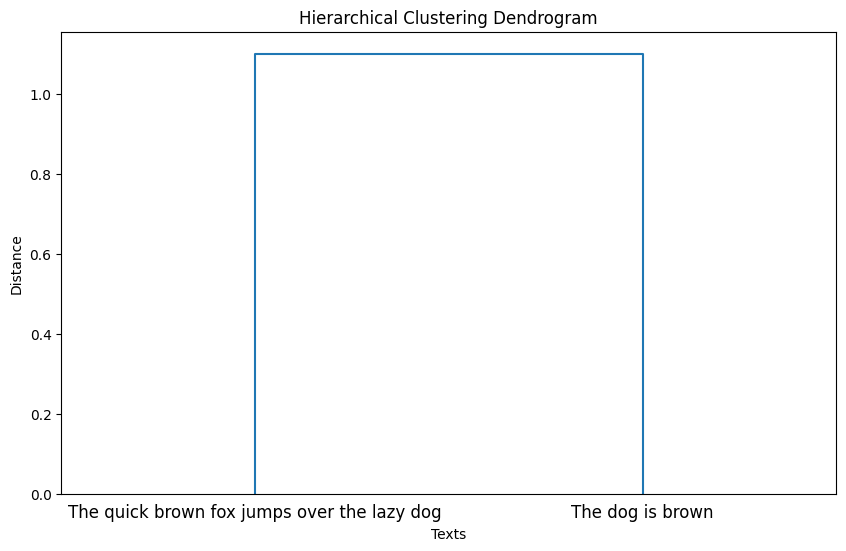

Distances between clusters: {1: [0, 1]}


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

# Step 1: Calculate TF-IDF vectors
def calculate_tfidf_vectors(texts):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(texts)
    return tfidf_matrix.toarray(), vectorizer.get_feature_names_out()

# Step 2: Perform hierarchical clustering
def perform_hierarchical_clustering(tfidf_matrix, method='average',metric="sqeuclidean"):
    distance_matrix = pdist(tfidf_matrix, metric=metric)
    clusters = linkage(distance_matrix, method=method)
    return clusters

# Step 3: Plot dendrogram
def plot_dendrogram(clusters, texts):
    plt.figure(figsize=(10, 6))
    dendrogram(clusters, labels=texts)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Texts')
    plt.ylabel('Distance')
    plt.show()

# Step 4: Get distances between clusters
def get_cluster_distances(clusters):
    cluster_labels = fcluster(clusters, t=2, criterion='maxclust')
    unique_labels = set(cluster_labels)
    distances = {}
    for label in unique_labels:
        indices = [i for i, x in enumerate(cluster_labels) if x == label]
        distances[label] = indices
    return distances

# Example usage
texts = [
    "The quick brown fox jumps over the lazy dog",
    "The dog is brown"
]

# Step 1: Calculate TF-IDF vectors
tfidf_matrix, feature_names = calculate_tfidf_vectors(texts)

# Step 2: Perform hierarchical clustering
clusters = perform_hierarchical_clustering(tfidf_matrix)

# Step 3: Plot dendrogram
plot_dendrogram(clusters, texts)

# Step 4: Get distances between clusters
cluster_distances = get_cluster_distances(clusters)
print("Distances between clusters:", cluster_distances)

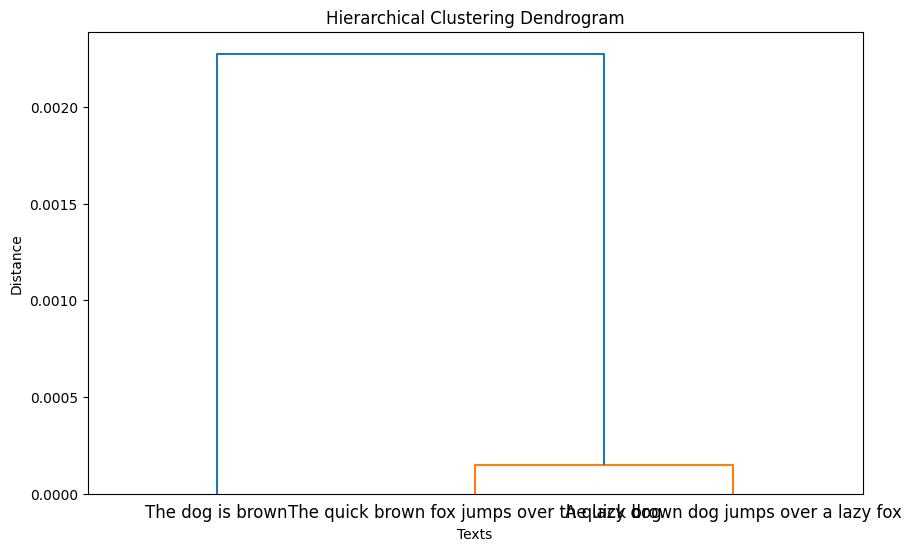

Distances between clusters: {1: [0, 1, 2]}


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Step 1: Perform Latent Dirichlet Allocation (LDA) to extract topics
def perform_lda(texts, num_topics):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(texts)
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(X)
    return lda, vectorizer

# Step 2: Transform texts into topic distributions
def transform_texts(lda, vectorizer, texts):
    X = vectorizer.transform(texts)
    topic_distributions = lda.transform(X)
    return topic_distributions

# Step 3: Perform hierarchical clustering
def perform_hierarchical_clustering(topic_distributions, method='average',metric='cosine'):
    distance_matrix = pdist(topic_distributions, metric=metric)
    clusters = linkage(distance_matrix, method=method)
    return clusters

# Step 4: Plot dendrogram
def plot_dendrogram(clusters, texts):
    plt.figure(figsize=(10, 6))
    dendrogram(clusters, labels=texts)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Texts')
    plt.ylabel('Distance')
    plt.show()

# Step 5: Get distances between clusters
def get_cluster_distances(clusters):
    cluster_labels = fcluster(clusters, t=2, criterion='maxclust')
    unique_labels = set(cluster_labels)
    distances = {}
    for label in unique_labels:
        indices = [i for i, x in enumerate(cluster_labels) if x == label]
        distances[label] = indices
    return distances
# Example usage
texts = [
    "The quick brown fox jumps over the lazy dog",
    "A quick brown dog jumps over a lazy fox",
    "The dog is brown"
]
num_topics = 2

# Step 1: Perform LDA to extract topics
lda, vectorizer = perform_lda(texts, num_topics)

# Step 2: Transform texts into topic distributions
topic_distributions = transform_texts(lda, vectorizer, texts)

# Step 3: Perform hierarchical clustering
clusters = perform_hierarchical_clustering(topic_distributions)

# Step 4: Plot dendrogram
plot_dendrogram(clusters, texts)


cluster_distances = get_cluster_distances(clusters)
print("Distances between clusters:", cluster_distances)

In [ ]:
# Step 1: Tokenize the texts
def tokenize_text(text):
    tokens = text.lower().split()  # Split the text into lowercase tokens
    return set(tokens)

# Step 2: Calculate overlap coefficient
def calculate_overlap_coefficient(text1, text2):
    set1 = tokenize_text(text1)
    set2 = tokenize_text(text2)
    intersection = len(set1.intersection(set2))
    min_size = min(len(set1), len(set2))
    overlap_coefficient = intersection / min_size if min_size > 0 else 0.0
    return overlap_coefficient

# Example usage
text1 = "The quick brown fox jumps over the lazy dog"
text2 = "A quick brown dog jumps over a lazy fox"
overlap_coefficient = calculate_overlap_coefficient(text1, text2)

print("Overlap Coefficient:", overlap_coefficient)


Overlap Coefficient: 0.875


In [ ]:
# Step 1: Tokenize the texts
def tokenize_text(text):
    tokens = text.lower().split()  # Split the text into lowercase tokens
    return set(tokens)

# Step 2: Calculate Sørensen-Dice coefficient
def calculate_sorensen_dice_coefficient(text1, text2):
    set1 = tokenize_text(text1)
    set2 = tokenize_text(text2)
    intersection = len(set1.intersection(set2))
    dice_coefficient = 2 * intersection / (len(set1) + len(set2))
    return dice_coefficient

# Example usage
text1 = "The quick brown fox jumps over the lazy dog"
text2 = "A quick brown dog jumps over a lazy fox"
dice_coefficient = calculate_sorensen_dice_coefficient(text1, text2)

print("Sørensen-Dice Coefficient:", dice_coefficient)


Sørensen-Dice Coefficient: 0.875


In [ ]:
def sorensen_dice_coefficient(set1, set2):
  """
  Calculates the Sørensen-Dice coefficient between two sets.

  Args:
      set1: The first set of words.
      set2: The second set of words.

  Returns:
      The Sørensen-Dice coefficient between the two sets.
  """

  intersection = len(set1.intersection(set2))
  union = len(set1.union(set2))

  if union == 0:
    return 1.0  # Avoid division by zero
  else:
    return (2.0 * intersection) / union

# Example usage
text1 = "The quick brown fox jumps over the lazy dog."
text2 = "The quick brown fox jumps over a small cat."

set1 = set(text1.lower().split())
set2 = set(text2.lower().split())

coefficient = sorensen_dice_coefficient(set1, set2)

print("Sørensen-Dice coefficient:", coefficient)


Sørensen-Dice coefficient: 1.0909090909090908


In [ ]:
# Step 1: Tokenize the texts into character n-grams
def tokenize_text(text, n):
    tokens = [text[i:i+n] for i in range(len(text) - n + 1)]
    return set(tokens)

# Step 2: Calculate Jaccard similarity based on character n-grams
def calculate_character_ngram_similarity(text1, text2, n):
    set1 = tokenize_text(text1, n)
    set2 = tokenize_text(text2, n)
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    jaccard_similarity = intersection / union if union > 0 else 0.0
    return jaccard_similarity

# Example usage
text1 = "The quick brown fox jumps over the lazy dog"
text2 = "A quick brown dog jumps over a lazy fox"
n = 3  # Character n-grams of length 3

character_ngram_similarity = calculate_character_ngram_similarity(text1, text2, n)

print("Character n-gram Similarity:", character_ngram_similarity)


Character n-gram Similarity: 0.6041666666666666


In [ ]:
import spacy
import networkx as nx

# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

# Step 1: Create semantic graph for text
def create_semantic_graph(text):
    doc = nlp(text)
    graph = nx.Graph()
    for token in doc:
        # Add nodes for tokens
        graph.add_node(token.i, text=token.text, lemma=token.lemma_, pos=token.pos_)
        # Add edges between tokens and their dependencies
        for child in token.children:
            graph.add_edge(token.i, child.i, label=child.dep_)
    return graph

# Step 2: Calculate similarity between semantic graphs
def calculate_graph_similarity(graph1, graph2):
    # Extract sets of nodes and edges from the graphs
    nodes1 = set(graph1.nodes)
    nodes2 = set(graph2.nodes)
    edges1 = set(graph1.edges)
    edges2 = set(graph2.edges)
    # Calculate Jaccard similarity coefficient
    jaccard_similarity_nodes = len(nodes1.intersection(nodes2)) / len(nodes1.union(nodes2))
    jaccard_similarity_edges = len(edges1.intersection(edges2)) / len(edges1.union(edges2))
    # Combine node and edge similarities using a weighted sum or another method
    # Here, we'll use a simple average
    jaccard_similarity = (jaccard_similarity_nodes + jaccard_similarity_edges) / 2
    return jaccard_similarity

# Example usage
text1 = "The quick brown fox jumps over the lazy dog"
text2 = "A quick brown dog jumps"

# Step 1: Create semantic graphs for both texts
graph1 = create_semantic_graph(text1)
graph2 = create_semantic_graph(text2)

# Step 2: Calculate similarity between semantic graphs
graph_similarity = calculate_graph_similarity(graph1, graph2)

print("Graph Similarity:", graph_similarity)


Graph Similarity: 0.5277777777777778


In [ ]:
text1 = "The sun is bright."
text2 = "The sun in the sky is bright."

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Step 1: Calculate Cosine Similarity
def calculate_cosine_similarity(text1, text2):
    vectorizer = CountVectorizer().fit_transform([text1, text2])
    vectors = vectorizer.toarray()
    cosine_sim = cosine_similarity(vectors)[0][1]
    return cosine_sim

# Step 2: Calculate Jaccard Similarity
def calculate_jaccard_similarity(text1, text2):
    set1 = set(text1.split())
    set2 = set(text2.split())
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    jaccard_sim = intersection / union
    return jaccard_sim

# Example usage
# text1 = "The quick brown fox jumps over the lazy dog"
# text2 = "A quick brown dog jumps over a lazy fox"
cosine_sim = calculate_cosine_similarity(text1, text2)
jaccard_sim = calculate_jaccard_similarity(text1, text2)

print("Cosine Similarity:", cosine_sim)
print("Jaccard Similarity:", jaccard_sim)



Cosine Similarity: 0.8333333333333333
Jaccard Similarity: 0.5714285714285714


##### Coherence

###### Coherene Referring


In [ ]:
# https://github.com/tushar117/Transformer-Models-for-Text-Coherence-Assessment/tree/main?tab=readme-ov-file
# https://github.com/ReemHal/Semantic-Text-Segmentation-with-Embeddings/blob/master/semantc_text_segmentation_example.ipynb

# https://github.com/josephwilk/semanticpy
# https://github.com/dansteiert/CohPy/blob/master/Scoring_functions/Cohesion_Sentence_Sentence.py

# https://github.com/explosion/floret?tab=readme-ov-file

# https://github.com/brucewlee/lingfeat

# readbality https://github.com/cdimascio/py-readability-metrics , https://github.com/textstat/textstat
# https://www.kaggle.com/code/yhirakawa/textstat-how-to-evaluate-readability
# https://www.tutorialspoint.com/readability-index-in-python-nlp

# coref
# https://github.com/vdobrovolskii/wl-coref
# https://pypi.org/project/fastcoref/
# https://github.com/stanfordnlp/stanfordnlp?tab=readme-ov-file

In [ ]:
#importing required libraries

import re

import numpy as np

import pandas as pd

from pprint import pprint

import gensim

import gensim.corpora as corpora

from gensim.utils import simple_preprocess

from nltk.corpus import stopwords

from gensim.models import CoherenceModel

import spacy

import pyLDAvis

import pyLDAvis.gensim_models

import matplotlib.pyplot as plt

import nltk

import spacy

nltk.download('stopwords')

nlp=spacy.load('en_core_web_sm',disable=['parser', 'ner'])



#importing the Stopwords to use them

stop_words = stopwords.words('english')

stop_words.extend(['from', 'subject', 're', 'edu', 'use','for'])



#downloading the data

from sklearn.datasets import fetch_20newsgroups

newsgroups_train = fetch_20newsgroups(subset='train')

data = newsgroups_train.data

data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

data = [re.sub('\s+', ' ', sent) for sent in data]

data = [re.sub("\'", "", sent) for sent in data]



#cleaning the text

def tokeniz(sentences):

    for sentence in sentences:

        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

processed_data = list(tokeniz(data))



#Building Bigram & Trigram Models

bigram = gensim.models.Phrases(processed_data, min_count=5, threshold=100)

trigram = gensim.models.Phrases(bigram[processed_data], threshold=100)

bigram_mod = gensim.models.phrases.Phraser(bigram)

trigram_mod = gensim.models.phrases.Phraser(trigram)



#function to filter out stopwords

def remove_stopwords(texts):

    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]



#function to create bigrams

def create_bigrams(texts):

    return [bigram_mod[doc] for doc in texts]



#function to create trigrams

def create_trigrams(texts):

    [trigram_mod[bigram_mod[doc]] for doc in texts]



#function for lemmatization

def lemmatize(texts, allowed_postags=['NOUN', 'ADJ', 'VERB']):

    texts_op = []

    for sent in texts:

        doc = nlp(" ".join(sent))

        texts_op.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])

    return texts_op



#removing stopwords, creating bigrams and lemmatizing the text

data_wo_stopwords = remove_stopwords(processed_data)

data_bigrams = create_bigrams(data_wo_stopwords)

data_lemmatized = lemmatize(data_bigrams, allowed_postags=[ 'NOUN', 'ADJ', 'VERB'])



#printing the lemmatized data

print(data_lemmatized[:3])



#creating a dictionary

gensim_dictionary = corpora.Dictionary(data_lemmatized)



texts = data_lemmatized



#building a corpus for the topic model

gensim_corpus = [gensim_dictionary.doc2bow(text) for text in texts]



#printing the corpus we created above.

print(gensim_corpus[:3])



#we can print the words with their frequencies.

[[(gensim_dictionary[id], freq) for id, freq in cp] for cp in gensim_corpus[:4]]



#creating the LDA model

lda_model = gensim.models.ldamodel.LdaModel(

   corpus=gensim_corpus, id2word=gensim_dictionary, num_topics=20, random_state=100,

   update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True

)


#calculating and displaying the coherence score

coherence_model_lda = CoherenceModel(

   model=lda_model, texts=data_lemmatized, dictionary=gensim_dictionary, coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()

print('\nCoherence Score: ', coherence_lda)


In [ ]:
from sgnlp.models.coherence_momentum import CoherenceMomentumModel, CoherenceMomentumConfig, \
    CoherenceMomentumPreprocessor

# Load Model
config = CoherenceMomentumConfig.from_pretrained(
    "https://storage.googleapis.com/sgnlp-models/models/coherence_momentum/config.json"
)
model = CoherenceMomentumModel.from_pretrained(
    "https://storage.googleapis.com/sgnlp-models/models/coherence_momentum/pytorch_model.bin",
    config=config
)

preprocessor = CoherenceMomentumPreprocessor(config.model_size, config.max_len)

# Example text inputs
text1 = "Companies listed below reported quarterly profit substantially different from the average of analysts ' " \
        "estimates . The companies are followed by at least three analysts , and had a minimum five-cent change in " \
        "actual earnings per share . Estimated and actual results involving losses are omitted . The percent " \
        "difference compares actual profit with the 30-day estimate where at least three analysts have issues " \
        "forecasts in the past 30 days . Otherwise , actual profit is compared with the 300-day estimate . " \
        "Source : Zacks Investment Research"
text2 = "The companies are followed by at least three analysts , and had a minimum five-cent change in actual " \
        "earnings per share . The percent difference compares actual profit with the 30-day estimate where at least " \
        "three analysts have issues forecasts in the past 30 days . Otherwise , actual profit is compared with the " \
        "300-day estimate . Source : Zacks Investment Research. Companies listed below reported quarterly profit " \
        "substantially different from the average of analysts ' estimates . Estimated and actual results involving " \
        "losses are omitted ."

text1_tensor = preprocessor([text1])
text2_tensor = preprocessor([text2])

text1_score = model.get_main_score(text1_tensor["tokenized_texts"]).item()
text2_score = model.get_main_score(text2_tensor["tokenized_texts"]).item()

print(text1_score, text2_score)


In [ ]:
from gensim.models import LdaModel, HdpModel
from gensim import corpora


dirichlet_dict = corpora.Dictionary(corpus)
bow_corpus = [dirichlet_dict.doc2bow(text) for text in corpus]

num_topics = 10
num_keywords = 300

dirichlet_model = LdaModel(corpus=bow_corpus,
                           id2word=dirichlet_dict,
                           num_topics=num_topics,
                           update_every=1,
                           chunksize=len(bow_corpus),
                           passes=20,
                           alpha='auto')

dirichlet_model = HdpModel(corpus=bow_corpus,
                           id2word=dirichlet_dict,
                           chunksize=len(bow_corpus))

def order_subset_by_coherence(dirichlet_model, bow_corpus, num_topics=10, num_keywords=10):
    """
    Orders topics based on their average coherence across the corpus

    Parameters
    ----------
        dirichlet_model : gensim.models.type_of_model
        bow_corpus : list of lists (contains (id, freq) tuples)
        num_topics : int (default=10)
        num_keywords : int (default=10)

    Returns
    -------
        ordered_topics, ordered_topic_averages: list of lists and list
    """
    if type(dirichlet_model) == gensim.models.ldamodel.LdaModel:
        shown_topics = dirichlet_model.show_topics(num_topics=num_topics,
                                                   num_words=num_keywords,
                                                   formatted=False)
    elif type(dirichlet_model)  == gensim.models.hdpmodel.HdpModel:
        shown_topics = dirichlet_model.show_topics(num_topics=150, # return all topics
                                                   num_words=num_keywords,
                                                   formatted=False)
    model_topics = [[word[0] for word in topic[1]] for topic in shown_topics]
    topic_corpus = dirichlet_model.__getitem__(bow=bow_corpus, eps=0) # cutoff probability to 0

    topics_per_response = [response for response in topic_corpus]
    flat_topic_coherences = [item for sublist in topics_per_response for item in sublist]

    significant_topics = list(set([t_c[0] for t_c in flat_topic_coherences])) # those that appear
    topic_averages = [sum([t_c[1] for t_c in flat_topic_coherences if t_c[0] == topic_num]) / len(bow_corpus) \
                      for topic_num in significant_topics]

    topic_indexes_by_avg_coherence = [tup[0] for tup in sorted(enumerate(topic_averages), key=lambda i:i[1])[::-1]]

    significant_topics_by_avg_coherence = [significant_topics[i] for i in topic_indexes_by_avg_coherence]
    ordered_topics = [model_topics[i] for i in significant_topics_by_avg_coherence][:num_topics] # limit for HDP

    ordered_topic_averages = [topic_averages[i] for i in topic_indexes_by_avg_coherence][:num_topics] # limit for HDP
    ordered_topic_averages = [a/sum(ordered_topic_averages) for a in ordered_topic_averages] # normalize HDP values

    return ordered_topics, ordered_topic_averages


ordered_topics, ordered_topic_averages = \
    order_subset_by_coherence(dirichlet_model=dirichlet_model,
                              bow_corpus=bow_corpus,
                              num_topics=num_topics,
                              num_keywords=num_keywords)

keywords = []
for i in range(num_topics):
    # Find the number of indexes to select, which can later be extended if the word has already been selected
    selection_indexes = list(range(int(round(num_keywords * ordered_topic_averages[i]))))
    if selection_indexes == [] and len(keywords) < num_keywords:
        # Fix potential rounding error by giving this topic one selection
        selection_indexes = [0]

    for s_i in selection_indexes:
        if ordered_topics[i][s_i] not in keywords and ordered_topics[i][s_i] not in ignore_words:
            keywords.append(ordered_topics[i][s_i])
        else:
            selection_indexes.append(selection_indexes[-1] + 1)

# Fix for if too many were selected
keywords = keywords[:num_keywords]

In [ ]:
from collections import Counter
from nltk import pos_tag

def compare_text_quality(original_text, sample_text, threshold=0.1):
  """
  This function compares the quality of two texts based on the similarity of their part-of-speech (POS) tag histograms.

  Args:
    original_text: The original text used as the benchmark.
    sample_text: The text to be compared with the original text.
    threshold: The maximum difference allowed between the POS tag proportions for the texts to be considered similar (default: 0.1).

  Returns:
    True if the sample text is considered similar to the original text based on the POS tag histogram comparison, False otherwise.
  """
  original_tags = Counter(tag for _, tag in pos_tag(original_text.split()))
  sample_tags = Counter(tag for _, tag in pos_tag(sample_text.split()))

  total_original_words = sum(original_tags.values())
  total_sample_words = sum(sample_tags.values())

  # Normalize the counts for comparison
  original_proportions = {tag: count / total_original_words for tag, count in original_tags.items()}
  sample_proportions = {tag: count / total_sample_words for tag, count in sample_tags.items()}

  # Calculate the difference in proportions for each POS tag
  differences = {tag: abs(original_proportions.get(tag, 0) - sample_proportions.get(tag, 0)) for tag in set(original_tags.keys()) | set(sample_tags.keys())}

  # Check if the average difference is below the threshold
  average_difference = sum(differences.values()) / len(differences)
  return average_difference <= threshold

# Example usage
original_text = "This is an example of a well-written sentence."
sample_text_1 = "This is another well-written sentence with similar structure."
sample_text_2 = "This sentence is grammatically correct but lacks the coherence of the original."

print(f"Sample text 1 similar to original: {compare_text_quality(original_text, sample_text_1)}")
print(f"Sample text 2 similar to original: {compare_text_quality(original_text, sample_text_2)}")


In [ ]:

def calculate_coherence(text):
    # Calculate coherence using spaCy's dependency parsing
    doc = nlp(text)
    coherence_scores = []
    for sent in doc.sents:
        # Get the root of the sentence
        root = [token for token in sent if token.dep_ == 'ROOT']
        if len(root) > 0:
            coherence_scores.append(len(list(root[0].subtree)))

    return coherence_scores

In [ ]:

# Define a prompt or context for text generation
prompt = "The quick brown fox jumps over the lazy dog.Lazy dog / is a quick brown not words in the"
import nltk
import math
nltk.download('punkt')
# Define the sequence as a list of words
text = prompt

# Tokenize the text (split into words)
tokens = nltk.word_tokenize(text)

# Calculate cross-entropy for each word
cross_entropy = 0
for i in range(1, len(tokens)):
    try:
        # Get the probability of the current word given the previous context
        prob = nltk. FreqDist(tokens[:i]).freq(tokens[i])
        # Handle potential zero probability errors
        if prob > 0:
            cross_entropy += -math.log2(prob)
    except ZeroDivisionError:
        # Handle cases where the previous context is rare or unseen
        pass

# Calculate average cross-entropy
average_cross_entropy = cross_entropy / (len(tokens) - 1)

# Calculate perplexity with base 2 (bits)
perplexity = 2 ** average_cross_entropy

# Print the perplexity score
print(f"Perplexity: {perplexity:.2f}")


Perplexity: 1.57


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# pip install textcaret
from textcaret import TextSentiment
docx = TextSentiment(test_data)
docx.sentiment()

OUTPUT:
{'sentence': "Kohli century leads a clinical performance .......at home.",
 'sentiment': Sentiment(
                        polarity=0.10238095238095238,
                        subjectivity=0.2857142857142857)
 }

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def build_graph(doc):
    # preprocess document for standardization
    pdoc = preprocess_document(doc)

    # get graph nodes
    nodes = get_entities(pdoc)

    # get graph edges
    edges = get_relations(pdoc)

    # create graph structure with NetworkX
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)

    return G


def preprocess_document(document, sentence_spliter='.', word_spliter=' ', punct_mark=','):
    # lowercase all words and remove trailing whitespaces
    document = document.lower().strip()

    # remove unwanted punctuation marks
    for pm in punct_mark:
        document = document.replace(pm, '')

    # get list of sentences which are non-empty
    sentences = [sent for sent in document.split(sentence_spliter) if sent != '']

    # get list of sentences which are lists of words
    document = []
    for sent in sentences:
        words = sent.strip().split(word_spliter)
        document.append(words)

    return document

  def get_entities(document):
    # in our case, entities are all unique words
    unique_words = []
    for sent in document:
        for word in sent:
            if word not in unique_words:
                unique_words.append(word)
    return unique_words

def get_relations(document):
    # in our case, relations are bigrams in sentences
    bigrams = []
    for sent in document:
        for i in range(len(sent)-1):
            # for every word and the next in the sentence
            pair = [sent[i], sent[i+1]]
            # only add unique bigrams
            if pair not in bigrams:
                bigrams.append(pair)
    return bigrams

def plot_graph(G, title=None):
    # set figure size
    plt.figure(figsize=(10,10))

    # define position of nodes in figure
    pos = nx.nx_agraph.graphviz_layout(G)

    # draw nodes and edges
    nx.draw(G, pos=pos, with_labels=True)

    # get edge labels (if any)
    edge_labels = nx.get_edge_attributes(G, 'weight')

    # draw edge labels (if any)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    # plot the title (if any)
    plt.title(title)

    plt.show()
    return


def get_weighted_edges(document):
    # in our case, relations are bigrams in sentences
    # weights are number of equal bigrams
    # use a dict to store number of counts
    bigrams = {}
    for sent in document:
        for i in range(len(sent)-1):

            # transform to hashable key in dict
            pair = str([sent[i], sent[i+1]])

            if pair not in bigrams.keys():
                # weight = 1
                bigrams[pair] = 1
            else:
                # already exists, weight + 1
                bigrams[pair] += 1

    # convert to NetworkX standard form each edge connecting nodes u and v = [u, v, weight]
    weighted_edges_format = []
    for pair, weight in bigrams.items():
        # revert back from hashable format
        w1, w2 = eval(pair)
        weighted_edges_format.append([w1, w2, weight])

    return weighted_edges_format

def build_weighted_digraph(document):
    # preprocess document for standardization
    pdoc = preprocess_document(doc)

    # get graph nodes
    nodes = get_entities(pdoc)

    # get weighted edges
    weighted_edges = get_weighted_edges(pdoc)

    # create graph structure with NetworkX
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_weighted_edges_from(weighted_edges)

    return G

In [ ]:
from gensim import corpora, models
from gensim.models import LdaMulticore,LdaModel
from gensim.models.coherencemodel import CoherenceModel
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.utils import simple_preprocess
from gensim.models.phrases import Phrases, Phraser
import gensim
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
# Sample documents (replace with your own corpus)
documents = ["This is the first document.",
             "This document is the second document.",
             "And this is the third one.",
             "Is this the first document?"]

# Tokenization, stopword removal, and lemmatization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalnum()]
    return tokens

processed_docs = [preprocess(doc) for doc in documents]
print(processed_docs)
# Add trigram functionality
bigram = Phrases(processed_docs, min_count=5, threshold=100)  # higher threshold fewer phrases.
trigram = Phrases(bigram[processed_docs], threshold=100)
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

processed_docs_trigrams = make_trigrams(processed_docs)

# Create a dictionary
dictionary = corpora.Dictionary(processed_docs)

# Create a bag-of-words corpus
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs_trigrams]

# TF-IDF model
tfidf = models.TfidfModel(bow_corpus)
tfidf_corpus = tfidf[bow_corpus]

# Train LDA model
lda_model = LdaMulticore(tfidf_corpus, num_topics=3, id2word=dictionary, passes=10, workers=2)

# Print topics
for idx, topic in lda_model.print_topics(-1):
    print(f'Topic: {idx} \nWords: {topic}\n')

# Compute coherence score (optional)
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs_trigrams, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'\nCoherence Score: {coherence_lda}')

# Get topic probabilities for each document
for i, doc in enumerate(processed_docs_trigrams):
    doc_bow = dictionary.doc2bow(doc)
    doc_tfidf = tfidf[doc_bow]
    topic_probs = lda_model.get_document_topics(doc_tfidf)
    print(f"Document {i + 1} Topic Probabilities: {topic_probs}")



[['this', 'is', 'the', 'first', 'document'], ['this', 'document', 'is', 'the', 'second', 'document'], ['and', 'this', 'is', 'the', 'third', 'one'], ['is', 'this', 'the', 'first', 'document']]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Topic: 0 
Words: 0.383*"first" + 0.201*"document" + 0.060*"second" + 0.059*"third" + 0.059*"one" + 0.059*"and" + 0.059*"is" + 0.059*"the" + 0.059*"this"

Topic: 1 
Words: 0.209*"second" + 0.152*"and" + 0.152*"one" + 0.152*"third" + 0.111*"document" + 0.057*"first" + 0.056*"is" + 0.056*"the" + 0.056*"this"

Topic: 2 
Words: 0.114*"document" + 0.112*"first" + 0.112*"second" + 0.111*"third" + 0.111*"one" + 0.111*"and" + 0.110*"is" + 0.110*"the" + 0.110*"this"


Coherence Score: 0.3628573077708544
Document 1 Topic Probabilities: [(0, 0.70642024), (1, 0.14727895), (2, 0.14630076)]
Document 2 Topic Probabilities: [(0, 0.17258687), (1, 0.6782813), (2, 0.14913188)]
Document 3 Topic Probabilities: [(0, 0.12384173), (1, 0.7501261), (2, 0.12603217)]
Document 4 Topic Probabilities: [(0, 0.70641154), (1, 0.1472866), (2, 0.14630184)]


In [2]:
essay = """
The Great Recession: A Scarring Legacy of the 2008 Global Economic Crisis

The year 2008 witnessed the eruption of a financial crisis that spiraled into the worst global recession since the Great Depression of the 1930s. This period, often referred to as the Great Recession, left a deep and lasting impact on economies and societies around the world. This essay delves into the intricate story of the 2008 global economic crisis, dissecting its origins, unfolding, ripple effects, and the ongoing efforts to prevent similar catastrophes in the future.

The Seeds of Crisis: A Perfect Storm of Faulty Financial Practices

The roots of the 2008 crisis can be traced back to an intricate web of interconnected factors, primarily within the United States housing market. Here are some key contributors:

    Subprime Lending: In the years leading to the crisis, financial institutions readily offered mortgages to borrowers with poor credit histories and limited ability to repay (subprime borrowers). This practice was fueled by the belief that rising housing prices would ensure a steady stream of profits regardless of borrower risk.
    Securitization and Credit Rating Agencies: To manage the increasing volume of subprime mortgages, financial institutions packaged them into complex financial instruments called mortgage-backed securities (MBS). These instruments were then sold to investors worldwide, spreading the risk across different institutions and markets. However, credit rating agencies, responsible for assessing the risk associated with these securities, often assigned higher-than-justified ratings, misleading investors about the underlying risk.
    Derivative Instruments: Financial institutions also engaged in the creation and trading of complex derivatives, such as credit default swaps (CDS), which essentially functioned as bets on the likelihood of borrowers defaulting on their loans. These instruments further amplified the risk exposure associated with the housing market.

The Unraveling: From Housing Market Collapse to Global Recession

When the housing bubble inevitably burst in 2007, the consequences were far-reaching. As home values plummeted, defaults on subprime mortgages surged. This triggered a domino effect – the value of MBS plummeted as the underlying mortgages became increasingly worthless. This, in turn, caused losses for financial institutions, leading to a credit freeze and a reluctance to lend. The lack of credit availability crippled businesses and consumers, resulting in:

    Stock Market Crash: With investor confidence shattered, stock markets around the world experienced a dramatic decline, wiping out trillions of dollars of wealth.
    Banking Crisis: As financial institutions faced escalating losses, many teetered on the brink of collapse. Some, like Lehman Brothers, were allowed to fail, while others were bailed out by governments.
    Economic Downturn: The credit freeze and declining investment ultimately translated into a global recession. Businesses faced declining demand and reduced their workforces, leading to a surge in unemployment. Consumers, facing job losses and declining wealth, cut back on spending, further hindering economic activity.

Ripple Effects Beyond Borders: A Global Impact

The crisis did not confine its devastation to the United States. It triggered a global recession with far-reaching consequences:

    Developed Economies: Countries like the United Kingdom, Eurozone nations, and Japan also experienced significant economic downturns, with rising unemployment, declining GDP, and financial instability.
    Developing Economies: Developing countries, often reliant on trade and foreign investment, were particularly vulnerable to the crisis. Reduced demand for exports, decreased foreign investment, and dwindling remittances sent back from working migrants severely impacted their economic growth and social stability.
    Increased Poverty and Inequality: The recession significantly increased global poverty and exacerbated existing inequalities. Vulnerable populations, such as low-wage workers, minorities, and individuals in developing countries, were disproportionately affected by job losses and reduced access to essential services.

Lessons Learned and the Road Ahead: Building Resilience in a Globalized World

The 2008 financial crisis served as a stark reminder of the inherent vulnerabilities and interconnectedness of the global financial system. In response, policymakers implemented various measures, including:

    Regulation of Financial Institutions: Stringent regulations were introduced to curb risky lending practices, improve transparency in financial markets, and enhance the oversight of financial institutions.
    Fiscal Stimulus Packages: Governments implemented fiscal stimulus packages, including increased government spending and tax cuts, to stimulate economic activity and mitigate the recession's impact.
    International Cooperation: Efforts to strengthen international cooperation in financial regulation and crisis management were undertaken through bodies like the G20.

However, the fight against future financial crises is ongoing. While the post-crisis period witnessed global economic recovery, the underlying vulnerabilities in the financial system remain a concern. Additionally, new challenges, such as rising income inequality, the increasing frequency and intensity of climate change events, and the rise of protectionist policies, pose fresh threats to global economic stability.

Conclusion: A Collective Responsibility to Prevent Future Crisis

The 2008 global economic crisis
"""

In [4]:
# https://github.com/AliKhalili/tensefinder/blob/master/TenseFinder/SentenceTenseModel.py
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
verb_tags = {'MD','MDF',
                'BE','BEG','BEN','BED','BEDZ','BEZ','BEM','BER',
                'DO','DOD','DOZ',
                'HV','HVG','HVN','HVD','HVZ',
                'VB','VBG','VBN','VBD','VBZ',
                'SH',
                'TO',
                'JJ' # maybe?
    }

grammar = r'''
              future perfect continuous passive:     {<MDF><HV><BEN><BEG><VBN|VBD>+}
              conditional perfect continuous passive:{<MD><HV><BEN><BEG><VBN|VBD>+}
              future continuous passive:             {<MDF><BE><BEG><VBN|VBD>+}
              conditional continuous passive:        {<MD><BE><BEG><VBN|VBD>+}
              future perfect continuous:             {<MDF><HV><BEN><VBG|HVG|BEG>+}
              conditional perfect continuous:        {<MD><HV><BEN><VBG|HVG|BEG>+}
              past perfect continuous passive:       {<HVD><BEN><BEG><VBN|VBD>+}
              present perfect continuous passive:    {<HV|HVZ><BEN><BEG><VBN|VBD>+}
              future perfect passive:                {<MDF><HV><BEN><VBN|VBD>+}
              conditional perfect passive:           {<MD><HV><BEN><VBN|VBD>+}
              future continuous:                     {<MDF><BE><VBG|HVG|BEG>+ }
              conditional continuous:                {<MD><BE><VBG|HVG|BEG>+  }
              future indefinite passive:             {<MDF><BE><VBN|VBD>+ }
              conditional indefinite passive:        {<MD><BE><VBN|VBD>+  }
              future perfect:                        {<MDF><HV><HVN|BEN|VBN|VBD>+ }
              conditional perfect:                   {<MD><HV><HVN|BEN|VBN|VBD>+  }
              past continuous passive:               {<BED|BEDZ><BEG><VBN|VBD>+}
              past perfect continuous:               {<HVD><BEN><HVG|BEG|VBG>+}
              past perfect passive:                  {<HVD><BEN><VBN|VBD>+}
              present continuous passive:            {<BEM|BER|BEZ><BEG><VBN|VBD>+}
              present perfect continuous:            {<HV|HVZ><BEN><VBG|BEG|HVG>+}
              present perfect passive:               {<HV|HVZ><BEN><VBN|VBD>+}
              future indefinite:                     {<MDF><BE|DO|VB|HV>+ }
              conditional indefinite:                {<MD><BE|DO|VB|HV>+  }
              past continuous:                       {<BED|BEDZ><VBG|HVG|BEG>+}
              past perfect:                          {<HVD><BEN|VBN|HVD|HVN>+}
              past indefinite passive:               {<BED|BEDZ><VBN|VBD>+}
              present indefinite passive:            {<BEM|BER|BEZ><VBN|VBD>+}
              present continuous:                    {<BEM|BER|BEZ><BEG|VBG|HVG>+}
              present perfect:                       {<HV|HVZ><BEN|HVD|VBN|VBD>+  }
              past indefinite:                       {<DOD><VB|HV|DO>|<BEDZ|BED|HVD|VBN|VBD>+}
              infinitive:                            {<TO><BE|HV|VB>+}
              present indefinite:                    {<DO|DOZ><DO|HV|VB>+|<DO|HV|VB|BEZ|DOZ|BER|HVZ|BEM|VBZ>+}
              '''
# `grammar = r"""
# Future_Perfect_Continuous: {<MD><VB><VBN><VBG>}
# Future_Continuous:         {<MD><VB><VBG>}
# Future_Perfect:            {<MD><VB><VBN>}
# Past_Perfect_Continuous:   {<VBD><VBN><VBG>}
# Present_Perfect_Continuous:{<VBP|VBZ><VBN><VBG>}
# Future_Indefinite:         {<MD><VB>}
# Past_Continuous:           {<VBD><VBG>}
# Past_Perfect:              {<VBD><VBN>}
# Present_Continuous:        {<VBZ|VBP><VBG>}
# Present_Perfect:           {<VBZ|VBP><VBN>}
# Past_Indefinite:           {<VBD>}
# Present_Indefinite:        {<VBZ>|<VBP>}
# """`

only_3_grammar = r'''
              future:         {<MDF><HV><BEN><BEG><VBN|VBD>+}
              indefinite:     {<MD><HV><BEN><BEG><VBN|VBD>+}
              future:         {<MDF><BE><BEG><VBN|VBD>+}
              indefinite:     {<MD><BE><BEG><VBN|VBD>+}
              future:         {<MDF><HV><BEN><VBG|HVG|BEG>+}
              indefinite:     {<MD><HV><BEN><VBG|HVG|BEG>+}
              past:           {<HVD><BEN><BEG><VBN|VBD>+}
              present:        {<HV|HVZ><BEN><BEG><VBN|VBD>+}
              future:         {<MDF><HV><BEN><VBN|VBD>+}
              indefinite:     {<MD><HV><BEN><VBN|VBD>+}
              future:         {<MDF><BE><VBG|HVG|BEG>+ }
              indefinite:     {<MD><BE><VBG|HVG|BEG>+  }
              future:         {<MDF><BE><VBN|VBD>+ }
              indefinite:     {<MD><BE><VBN|VBD>+  }
              future:         {<MDF><HV><HVN|BEN|VBN|VBD>+ }
              indefinite:     {<MD><HV><HVN|BEN|VBN|VBD>+  }
              past:           {<BED|BEDZ><BEG><VBN|VBD>+}
              past:           {<HVD><BEN><HVG|BEG|VBG>+}
              past:           {<HVD><BEN><VBN|VBD>+}
              present:        {<BEM|BER|BEZ><BEG><VBN|VBD>+}
              present:        {<HV|HVZ><BEN><VBG|BEG|HVG>+}
              present:        {<HV|HVZ><BEN><VBN|VBD>+}
              future:         {<MDF><BE|DO|VB|HV>+ }
              indefinite:     {<MD><BE|DO|VB|HV>+  }
              past:           {<BED|BEDZ><VBG|HVG|BEG>+}
              past:           {<HVD><BEN|VBN|HVD|HVN>+}
              past:           {<BED|BEDZ><VBN|VBD>+}
              present:        {<BEM|BER|BEZ><VBN|VBD>+}
              present:        {<BEM|BER|BEZ><BEG|VBG|HVG>+}
              present:        {<HV|HVZ><BEN|HVD|VBN|VBD>+  }
              past:           {<DOD><VB|HV|DO>|<BEDZ|BED|HVD|VBN|VBD>+}
              infinitive:     {<TO><BE|HV|VB>+}
              present:        {<DO|DOZ><DO|HV|VB>+|<DO|HV|VB|BEZ|DOZ|BER|HVZ|BEM|VBZ>+}
              future:         {<MD><VB><VBN><VBG>}
              future:         {<MD><VB><VBG>}
              future:         {<MD><VB><VBN>}
              past:           {<VBD><VBN><VBG>}
              present:        {<VBP|VBZ><VBN><VBG>}
              future:         {<MD><VB>}
              past:           {<VBD><VBG>}
              past:           {<VBD><VBN>}
              present:        {<VBZ|VBP><VBG>}
              present:        {<VBZ|VBP><VBN>}
              past:           {<VBD>}
              present:        {<VBZ>|<VBP>}
              '''
def detect_tense(sentence, grammer=only_3_grammar):
    """
    Attempts to detect the tense of the main verb in the sentence using NLTK and enhanced rules.

    Args:
        sentence: A string representing the sentence.

    Returns:
        A string representing the detected tense (e.g., "present", "past", "future") or
        "NA" if tense detection fails.
    """

    def tense_detect_regex_parser(tagged_sentence, grammer):

      verb_phrase = [item for item in tagged_sentence if item[1] in verb_tags]

      cp = nltk.RegexpParser(grammer)
      result = cp.parse(verb_phrase)
      # display(result)

      tenses_set = set()
      for node in result:
          if type(node) is nltk.tree.Tree:
              tenses_set.add(node.label())
      return result, tenses_set

    def using_pos(tagged_tokens):
      # Find potential main verbs
      verbs = [token for token, tag in tagged_tokens if tag.startswith("VB")]

      # Prioritize full verbs over auxiliaries
      main_verb = None
      for verb in verbs:
          if verb not in ["be", "have", "do"]:
              main_verb = verb
              break
      if not main_verb:
          main_verb = verbs[0] if verbs else None

      # Rule-based tense detection with negation handling
      if main_verb:
          if main_verb in ["be"]:  # Handle "be" verbs
              if "am" in tagged_tokens or "is" in tagged_tokens:
                  return "present"
              elif "was" in tagged_tokens or "were" in tagged_tokens:
                  return "past"
              elif "will be" in [token for token, tag in tagged_tokens]:
                  return "future"

          elif main_verb.endswith("ing"):  # Present progressive
              return "present progressive"

          elif main_verb.endswith("s") and len(main_verb) > 2:  # 3rd person singular present tense
              return "present"

          elif (main_verb == "do" and any(tag == "VBD" for _, tag in tagged_tokens) and
                not any(token in ["not", "never"] for token, _ in tagged_tokens)):  # Past tense with "do" auxiliary (excluding negation)
              return "past"

          elif (main_verb == "have" or main_verb == "has") and any(tag == "VBN" for _, tag in tagged_tokens):  # Present perfect
              return "present perfect"

          elif (main_verb == "had" and any(tag == "VBN" for _, tag in tagged_tokens)):  # Past perfect
              return "past perfect"

          elif "will" in [token for token, tag in tagged_tokens]:  # Future tense with "will" auxiliary
              return "future"

          elif any(token in ["not", "never"] for token, _ in tagged_tokens):  # Handle negation (simple cases)
              # Invert tense for simple negation (excluding modal verbs and complex cases)
              if not any(token in ["can", "could", "may", "might", "must", "should"] for token, _ in tagged_tokens):
                  tense = using_pos(" ".join([token for token, _ in tagged_tokens if token not in ["not", "never"]]))
                  return f"{'not' if 'not' in tagged_tokens else 'never'} {tense}"  # Invert tense with negation

          else:  # Default to past tense for other verb forms
              return "past"

      return "NA"  # Tense detection failed
    # Tokenize and tag the sentence
    tokens = nltk.word_tokenize(sentence)
    tag_tokens = nltk.pos_tag(tokens)
    print("========",tag_tokens)
    tense = using_pos(tag_tokens)
    # Call the tense_detect function
    _, tenses_set = tense_detect_regex_parser(tag_tokens, grammer)
    final_tense = tense
    for tns in tenses_set:
      if tense in tns:
        final_tense = tns
    return {
      "tenses_set" : tenses_set,
      "tense" : tense,
      "result" : final_tense
    }




# Define your sentence
sentence = "Ripple Effects Beyond Borders : A Global Impact The crisis did confine its devastation to the United States ."
# Example usage
# sentence = "He has not been eating yet."
# only_3_grammar
# grammar
tense = detect_tense(sentence, only_3_grammar)
print(f"Tense: {tense}")



======== [('Ripple', 'JJ'), ('Effects', 'NNS'), ('Beyond', 'IN'), ('Borders', 'NNS'), (':', ':'), ('A', 'DT'), ('Global', 'NNP'), ('Impact', 'NNP'), ('The', 'DT'), ('crisis', 'NN'), ('did', 'VBD'), ('confine', 'VB'), ('its', 'PRP$'), ('devastation', 'NN'), ('to', 'TO'), ('the', 'DT'), ('United', 'NNP'), ('States', 'NNPS'), ('.', '.')]
Tense: {'tenses_set': {'present', 'past'}, 'tense': 'past', 'result': 'past'}


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
from spacy import displacy
from spacy.language import Language
from spacy.tokens import Doc
import spacy
import numpy as np
from gensim.models.phrases import Phrases
from gensim.models import TfidfModel, LdaModel, LdaMulticore
from gensim import corpora


import nltk
nltk.download('vader_lexicon')

def lda_topic_model(sentences_tokens_list):
  # Create a dictionary
  dictionary = corpora.Dictionary(sentences_tokens_list)

  # Create a bag-of-words corpus
  bow_corpus = [dictionary.doc2bow(doc) for doc in sentences_tokens_list]

  # TF-IDF model
  tfidf = TfidfModel(bow_corpus)
  tfidf_corpus = tfidf[bow_corpus]

  # Train LDA model
  lda_model = LdaMulticore(tfidf_corpus, num_topics=3, id2word=dictionary, passes=10, workers=2)
  return {
      "lda_model" : lda_model,
      "dictionary" : dictionary,
      "tfidf":tfidf
  }
# Function to analyze coherence using dependency parsing, co-reference resolution, and sentiment analysis
def analyze_coherence(text, visualize=False):
    # TODO: Coref need to added
    # emotion dections in text ["Anger", "Arousal", "Disgust", "Fear", "Happiness", "Joy", "Sadness", "Valency"]
    # Load spaCy with relevant components
    nlp = spacy.load("en_core_web_sm", disable=["ner"])

    # Process the text
    doc = nlp(text)

    # Dependency parsing
    sentence_structures = []
    document_sentence = {}

     # Identify tense and perspective using spaCy (or alternative libraries)
    tense_markers = {"VBD": "past", "VBP": "present", "VBZ": "present (3rd person singular)"}  # Example tense markers
    perspective_markers = {"I": "first person", "you": "second person"}  # Example perspective markers
    tense_per_sentence = []
    perspective_per_sentence = []
    tokens = []
    for sent in doc.sents:
        tense = None
        perspective = None
        words = []
        dependencies = []
        tk = []
        for token in sent:
            if token.pos_ in tense_markers:
                tense = tense_markers[token.pos_]
            elif token.text.lower() in perspective_markers:
                perspective = perspective_markers[token.text.lower()]
            words.append(token.text)
            tk.append(token.text.lower())
            dependencies.append((token.dep_, token.head.text))
        tokens.append(tk)
        sentence_structures.append({
            "words": words,
            "dependencies": dependencies
        })
        tense_per_sentence.append(detect_tense(sent.text, only_3_grammar))
        perspective_per_sentence.append(perspective)
        document_sentence[sent.text] = sent


    # Co-reference resolution (spaCy's built-in functionality)
    # coref_chains = []
    # for cluster in doc.coref_:
    #     chain = [str(token.text) for token in cluster]
    #     coref_chains.append(chain)

    # Sentiment analysis (using VADER lexicon)
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    sentiment_analyzer = SentimentIntensityAnalyzer()
    sentence_sentiments = []
    for sent in document_sentence:
        scores = sentiment_analyzer.polarity_scores(document_sentence[sent].text)
        sentence_sentiments.append(scores)

    # Basic coherence evaluation logic (replace or extend as needed)
    coherence_score = 0

    # Check pronoun clarity (penalize if a pronoun doesn't have a clear antecedent)
    # for chain in coref_chains:
    #     if len(chain) == 1 and chain[0].lower().ispronoun():  # Single-word pronoun chain
    #         coherence_score -= 1  # Penalize for unclear pronoun reference
    # Topic modeling
    # 1. Preprocess text (lowercase, tokenize, remove stop words)
    lda_dict = lda_topic_model(tokens)

    # Analyze thematic shifts and sentiment consistency
    topic_sentiment_scores = {}  # Dictionary to store average sentiment per topic
    for idx, (sent, sentiment) in enumerate(zip(tokens, sentence_sentiments)):
        # Get topic distribution for the sentence
        topic_probs = lda_dict["lda_model"][lda_dict["tfidf"]
          [
            lda_dict["dictionary"].doc2bow(sent)
          ]
        ]
        dominant_topic_id = max(enumerate(topic_probs), key=lambda x: x[1])[0]  # Get the most dominant topic

        # Update topic sentiment scores
        if dominant_topic_id not in topic_sentiment_scores:
            topic_sentiment_scores[dominant_topic_id] = []
        topic_sentiment_scores[dominant_topic_id].append(sentiment["compound"])

    # Evaluate coherence based on sentiment consistency within topics
    coherence_score = 0
    for topic_id, sentiment_scores in topic_sentiment_scores.items():
        if len(sentiment_scores) > 1:  # Check if there are multiple sentences within a topic
            coherence_score -= np.std(sentiment_scores)  # Penalize for high standard deviation (large sentiment variation)

    # Check sentiment consistency within a topic (penalize for large sentiment shifts)
    # This is a simplified example, consider topic modeling for more robust topic identification
    previous_sentiment = None
    for sent, sentiment in zip(document_sentence, sentence_sentiments):
        if previous_sentiment is not None:
            sentiment_diff = abs(previous_sentiment["compound"] - sentiment["compound"])
            if sentiment_diff > 0.5:  # Adjust threshold as needed (higher for stronger penalty)
                coherence_score -= sentiment_diff  # Penalize for large sentiment shifts
        previous_sentiment = sentiment

    # lexical cohesion
    # Lexical cohesion
    unique_words_per_sentence = []
    for sent in document_sentence:
        unique_words_per_sentence.append(set(token.lower() for token in sent))
    sentence_similarities = []
    for i in range(len(unique_words_per_sentence) - 1):
        sentence1, sentence2 = unique_words_per_sentence[i], unique_words_per_sentence[i + 1]
        sentence_similarities.append(len(sentence1.intersection(sentence2)) / len(sentence1.union(sentence2)))
    # Check for sudden shifts (replace with more comprehensive logic as needed)
    logical_flow_score = 0
    for i in range(1, len(tense_per_sentence)):
        if tense_per_sentence[i] != tense_per_sentence[i - 1] and tense_per_sentence[i] is not None:
            logical_flow_score -= 1  # Penalize for tense shift
        if perspective_per_sentence[i] != perspective_per_sentence[i - 1] and perspective_per_sentence[i] is not None:
            logical_flow_score -= 1  # Penalize for perspective shift


    # Penalize sentences with unclear dependency structures (optional, needs customization)
    # You can define rules based on specific dependency types or missing dependencies

    # Display results
    if visualize:
      displacy.render(doc, style="dep")  # Optional: Visualize dependencies

    return {
        "sentence_structures": sentence_structures,
        # "coref_chains": coref_chains,
        "sentence_sentiments": sentence_sentiments,
        "coherence_score": coherence_score,
         "sentence_similarities": sentence_similarities,
        "logical_flow_score": logical_flow_score
    }

# Example usage
text = "The quick brown fox jumps over the lazy dog. He is a mammal. But cats are cute."
text = essay


results = analyze_coherence(text)

print("Sentence structures:", results["sentence_structures"])
print("Coreference chains:", results.get("coref_chains"))
print("Sentence sentiments:", results["sentence_sentiments"])
print("Coherence score:", results["coherence_score"])
print("Logical Flow score:", results["logical_flow_score"])



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


======== [('The', 'DT'), ('Great', 'JJ'), ('Recession', 'NN'), (':', ':'), ('A', 'DT'), ('Scarring', 'VBG'), ('Legacy', 'NN'), ('of', 'IN'), ('the', 'DT'), ('2008', 'CD'), ('Global', 'NNP'), ('Economic', 'NNP'), ('Crisis', 'NNP'), ('The', 'DT'), ('year', 'NN'), ('2008', 'CD'), ('witnessed', 'VBD'), ('the', 'DT'), ('eruption', 'NN'), ('of', 'IN'), ('a', 'DT'), ('financial', 'JJ'), ('crisis', 'NN'), ('that', 'WDT'), ('spiraled', 'VBD'), ('into', 'IN'), ('the', 'DT'), ('worst', 'JJS'), ('global', 'JJ'), ('recession', 'NN'), ('since', 'IN'), ('the', 'DT'), ('Great', 'NNP'), ('Depression', 'NNP'), ('of', 'IN'), ('the', 'DT'), ('1930s', 'CD'), ('.', '.')]
======== [('This', 'DT'), ('period', 'NN'), (',', ','), ('often', 'RB'), ('referred', 'VBN'), ('to', 'TO'), ('as', 'IN'), ('the', 'DT'), ('Great', 'NNP'), ('Recession', 'NNP'), (',', ','), ('left', 'VBD'), ('a', 'DT'), ('deep', 'JJ'), ('and', 'CC'), ('lasting', 'JJ'), ('impact', 'NN'), ('on', 'IN'), ('economies', 'NNS'), ('and', 'CC'), ('so

ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:

# https://medium.com/@sharma.tanish096/sentiment-analysis-using-pre-trained-models-and-transformer-28e9b9486641

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm", disable=["ner"])
text = "The quick brown fox jumps over the lazy dog. He is a mammal. But cats are cute."
# Process the text
doc = nlp(text)
tokens = []
for sent in doc.sents:
  token = []
  for tk in sent:
    if not tk.is_stop:
      token.append(tk)
  tokens.append(token)
print(tokens)

[[quick, brown, fox, jumps, lazy, dog, .], [mammal, .], [cats, cute, .]]


In [ ]:

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from spacy.language import Language
from spacy.tokens import Doc

# Load NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
# Function to check pronoun consistency
def check_pronoun_consistency(text):
    # Preprocess and tokenize text
    text = text.lower()
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stop_words]

    # Identify pronouns
    pronouns = [token for token, pos in nltk.pos_tag(filtered_tokens) if pos in {"PRP", "PRP$", "WP", "WP$"}]

    # Load spaCy with relevant components
    nlp = spacy.load("en_core_web_sm", disable=["ner"])
    doc = nlp(text)

    # Coreference resolution
    coref_chains = []
    for cluster in doc.coref_:
        chain = [str(token.text) for token in cluster]
        coref_chains.append(chain)

    # Check pronoun consistency
    inconsistent_pronouns = []
    for chain in coref_chains:
        if len(chain) == 1 and chain[0] in pronouns and chain[0] not in {"i", "me", "mine", "myself"}:
            inconsistent_pronouns.append(chain[0])

    return {
        "pronouns": pronouns,
        "coreference_chains": coref_chains,
        "inconsistent_pronouns": inconsistent_pronouns
    }

# Example usage
text = "The quick brown fox jumps over the lazy dog. He is a mammal. But it is cute."

results = check_pronoun_consistency(text)

print("Pronouns:", results["pronouns"])
print("Coreference chains:", results["coreference_chains"])
print("Inconsistent pronouns:", results["inconsistent_pronouns"])


import spacy

# Load English language model
nlp = spacy.load("en_core_web_sm")

# Function to check pronoun consistency
def check_pronoun_consistency(text):
    doc = nlp(text)
    pronoun_antecedents = {}  # Dictionary to store pronouns and their antecedents
    inconsistent_pronouns = []  # List to store inconsistent pronouns

    # Iterate over tokens in the document
    for token in doc:
        if token.pos_ == "PRON":  # Check if token is a pronoun
            # Check if pronoun has a clear antecedent (noun or proper noun within the same sentence)
            antecedent = None
            for ancestor in token.ancestors:
                if ancestor.pos_ in ["NOUN", "PROPN"]:  # Check if ancestor is a noun or proper noun
                    antecedent = ancestor.text
                    break
            if antecedent is None:
                # If pronoun does not have a clear antecedent, add it to the list of inconsistent pronouns
                inconsistent_pronouns.append(token.text)
            else:
                # If pronoun has a clear antecedent, add it to the dictionary of pronoun-antecedent pairs
                pronoun_antecedents[token.text] = antecedent

    return pronoun_antecedents, inconsistent_pronouns

# Example text
text = "John likes soccer. He plays it every weekend. John's friends join him."

# Check pronoun consistency in the text
pronoun_antecedents, inconsistent_pronouns = check_pronoun_consistency(text)

# Print pronoun-antecedent pairs and inconsistent pronouns
print("Pronoun-Antecedent Pairs:", pronoun_antecedents)
print("Inconsistent Pronouns:", inconsistent_pronouns)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


AttributeError: 'spacy.tokens.doc.Doc' object has no attribute 'coref_'

In [ ]:
!pip install fastembed

In [ ]:
from fastembed import TextEmbedding
from typing import List
import numpy as np

documents: List[str] = [
    "passage: Hello, World!",
    "query: Hello, World!", # these are two different embedding
    "passage: This is an example passage.",
    "fastembed is supported by and maintained by Qdrant." # You can leave out the prefix but it's recommended
]
embedding_model = TextEmbedding(model_name="BAAI/bge-base-en")
embeddings: List[np.ndarray] = list(embedding_model.embed(documents)) # Note

In [ ]:
# Certainly! Evaluating coherence in a text can be approached using more advanced techniques beyond basic frequency analysis. Here are some advanced techniques you can consider:

# 1. **Dependency Parsing:**
#    - Use dependency parsing to analyze the syntactic structure of sentences and identify relationships between words. This can help assess how ideas are connected and organized within the text.

# 2. **Topic Modeling:**
#    - Apply topic modeling techniques such as Latent Dirichlet Allocation (LDA) or Non-Negative Matrix Factorization (NMF) to identify underlying topics or themes in the text. Coherent texts typically exhibit a consistent focus on a few key topics.

# 3. **Discourse Analysis:**
#    - Perform discourse analysis to examine how sentences and paragraphs are organized to form coherent units of meaning. This involves identifying discourse markers, rhetorical structures, and coherence relations between ideas.

# 4. **Semantic Similarity:**
#    - Calculate semantic similarity between sentences or paragraphs using word embeddings or pre-trained language models (e.g., Word2Vec, BERT). High semantic similarity indicates that the ideas conveyed are closely related and coherent.

# 5. **Graph-based Methods:**
#    - Represent the text as a graph, where nodes correspond to words or phrases and edges represent relationships between them (e.g., co-occurrence, syntactic dependencies). Apply graph algorithms to identify central nodes or clusters of closely related concepts, which can indicate coherence.

# 6. **Cohesion Analysis:**
#    - Evaluate cohesion in the text by examining lexical cohesion (e.g., repetition of key terms, synonymy) and grammatical cohesion (e.g., pronoun reference, conjunctions). Coherent texts often exhibit strong cohesion between sentences and paragraphs.

# 7. **Readability Metrics:**
#    - Use readability metrics such as Flesch-Kincaid Grade Level, Gunning Fog Index, or Coleman-Liau Index to assess the overall readability and coherence of the text. Coherent texts tend to be more readable and accessible to readers.

# 8. **Machine Learning Models:**
#    - Train machine learning models (e.g., recurrent neural networks, transformers) on labeled data to automatically predict coherence scores or classify texts as coherent or incoherent. Feature representations learned by these models can capture complex patterns of coherence in the text.

# By incorporating these advanced techniques into your coherence evaluation process, you can gain deeper insights into the organization and structure of written texts, leading to more accurate assessments of coherence. Depending on your specific requirements and the complexity of the texts you're analyzing, you may choose to use a combination of these techniques for optimal results.

In [ ]:
import spacy

# Load English language model
nlp = spacy.load("en_core_web_sm")

# Function to perform discourse analysis
def discourse_analysis(text):
    doc = nlp(text)
    coherence_relations = []  # List to store coherence relations between sentences

    # Iterate over sentences in the document
    for sent in doc.sents:
        coherence_relations.append({"text": sent.text, "relations": []})
        # Iterate over tokens in the sentence
        for token in sent:
            # Check for discourse markers (e.g., conjunctions, transition words)
            if token.dep_ == "mark" or token.dep_ == "advmod":
                # Find the head of the token (parent)
                head_token = token.head
                # Add the coherence relation to the list
                coherence_relations[-1]["relations"].append((head_token.text, token.text))

    return coherence_relations

# Example text
text = "However, the weather was beautiful. Therefore, we decided to go for a hike. In the end, it turned out to be a great day."

# Perform discourse analysis on the text
coherence_relations = discourse_analysis(text)

# Print coherence relations between sentences
for idx, relation in enumerate(coherence_relations):
    print(f"Sentence {idx + 1}: {relation['text']}")
    if relation["relations"]:
        print("Coherence Relations:")
        for head, marker in relation["relations"]:
            print(f"- {head} ({marker})")


Sentence 1: However, the weather was beautiful.
Coherence Relations:
- was (However)
Sentence 2: Therefore, we decided to go for a hike.
Coherence Relations:
- decided (Therefore)
Sentence 3: In the end, it turned out to be a great day.


In [ ]:
def word_frequencies(lemma_by_sent):
    """
    Count the frequency of each word, per sentence and within the whole document
    :param lemma_by_sent: list of list, list of sentences, where each sentence has a lemma given
    :return: [{key=lemma, value=cont}] in the sentence version or just {key=lemma, value=cont} for the full document.
    """
    freq_by_sent = []
    doc_freq = {}
    for sent in lemma_by_sent:
        sent_dict = {}
        for lemma in sent:
            sent_dict[lemma] = sent_dict.get(lemma, 0) + 1
            doc_freq[lemma] = doc_freq.get(lemma, 0) + 1
        freq_by_sent.append(sent_dict)
    return freq_by_sent, doc_freq

In [ ]:
essay = """
The Great Recession: A Scarring Legacy of the 2008 Global Economic Crisis

The year 2008 witnessed the eruption of a financial crisis that spiraled into the worst global recession since the Great Depression of the 1930s. This period, often referred to as the Great Recession, left a deep and lasting impact on economies and societies around the world. This essay delves into the intricate story of the 2008 global economic crisis, dissecting its origins, unfolding, ripple effects, and the ongoing efforts to prevent similar catastrophes in the future.

The Seeds of Crisis: A Perfect Storm of Faulty Financial Practices

The roots of the 2008 crisis can be traced back to an intricate web of interconnected factors, primarily within the United States housing market. Here are some key contributors:

    Subprime Lending: In the years leading to the crisis, financial institutions readily offered mortgages to borrowers with poor credit histories and limited ability to repay (subprime borrowers). This practice was fueled by the belief that rising housing prices would ensure a steady stream of profits regardless of borrower risk.
    Securitization and Credit Rating Agencies: To manage the increasing volume of subprime mortgages, financial institutions packaged them into complex financial instruments called mortgage-backed securities (MBS). These instruments were then sold to investors worldwide, spreading the risk across different institutions and markets. However, credit rating agencies, responsible for assessing the risk associated with these securities, often assigned higher-than-justified ratings, misleading investors about the underlying risk.
    Derivative Instruments: Financial institutions also engaged in the creation and trading of complex derivatives, such as credit default swaps (CDS), which essentially functioned as bets on the likelihood of borrowers defaulting on their loans. These instruments further amplified the risk exposure associated with the housing market.

The Unraveling: From Housing Market Collapse to Global Recession

When the housing bubble inevitably burst in 2007, the consequences were far-reaching. As home values plummeted, defaults on subprime mortgages surged. This triggered a domino effect – the value of MBS plummeted as the underlying mortgages became increasingly worthless. This, in turn, caused losses for financial institutions, leading to a credit freeze and a reluctance to lend. The lack of credit availability crippled businesses and consumers, resulting in:

    Stock Market Crash: With investor confidence shattered, stock markets around the world experienced a dramatic decline, wiping out trillions of dollars of wealth.
    Banking Crisis: As financial institutions faced escalating losses, many teetered on the brink of collapse. Some, like Lehman Brothers, were allowed to fail, while others were bailed out by governments.
    Economic Downturn: The credit freeze and declining investment ultimately translated into a global recession. Businesses faced declining demand and reduced their workforces, leading to a surge in unemployment. Consumers, facing job losses and declining wealth, cut back on spending, further hindering economic activity.

Ripple Effects Beyond Borders: A Global Impact

The crisis did not confine its devastation to the United States. It triggered a global recession with far-reaching consequences:

    Developed Economies: Countries like the United Kingdom, Eurozone nations, and Japan also experienced significant economic downturns, with rising unemployment, declining GDP, and financial instability.
    Developing Economies: Developing countries, often reliant on trade and foreign investment, were particularly vulnerable to the crisis. Reduced demand for exports, decreased foreign investment, and dwindling remittances sent back from working migrants severely impacted their economic growth and social stability.
    Increased Poverty and Inequality: The recession significantly increased global poverty and exacerbated existing inequalities. Vulnerable populations, such as low-wage workers, minorities, and individuals in developing countries, were disproportionately affected by job losses and reduced access to essential services.

Lessons Learned and the Road Ahead: Building Resilience in a Globalized World

The 2008 financial crisis served as a stark reminder of the inherent vulnerabilities and interconnectedness of the global financial system. In response, policymakers implemented various measures, including:

    Regulation of Financial Institutions: Stringent regulations were introduced to curb risky lending practices, improve transparency in financial markets, and enhance the oversight of financial institutions.
    Fiscal Stimulus Packages: Governments implemented fiscal stimulus packages, including increased government spending and tax cuts, to stimulate economic activity and mitigate the recession's impact.
    International Cooperation: Efforts to strengthen international cooperation in financial regulation and crisis management were undertaken through bodies like the G20.

However, the fight against future financial crises is ongoing. While the post-crisis period witnessed global economic recovery, the underlying vulnerabilities in the financial system remain a concern. Additionally, new challenges, such as rising income inequality, the increasing frequency and intensity of climate change events, and the rise of protectionist policies, pose fresh threats to global economic stability.

Conclusion: A Collective Responsibility to Prevent Future Crisis

The 2008 global economic crisis
"""

In [ ]:
# Import NLTK
import nltk
import numpy as np
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
exclusive_tagset_names = ["nouns", "pronouns", "verbs", "adverbs", "adjectives", "miscellaneous"]
# Function to check if a POS tag matches specified criteria
def check_tags(tag, accept_tags=[], accept_tags_start_with=[], exclude_tags=[], exclude_tags_start_with=[]):
    """
    Checks if a POS tag matches any of the provided criteria.

    Args:
        tag: A string representing the POS tag to check.
        accept_tags: List of POS tags for direct inclusion.
        accept_tags_start_with: List of starting characters for POS tags (partial inclusion).
        exclude_tags: List of POS tags for direct exclusion.
        exclude_tags_start_with: List of starting characters for POS tags (partial exclusion).

    Returns:
        True if the tag matches any of the criteria, False otherwise.
    """

    # Prioritize inclusion over exclusion
    if tag in accept_tags or (tag[0] in accept_tags_start_with and tag not in exclude_tags):
        return True
    return False
# need to add spacy also
# https://github.com/explosion/spaCy/blob/master/spacy/glossary.py
# for tense https://github.com/3scapeX/textReadabilityClassifier/blob/main/grammar_module.py
# Function to sort text data into categories based on POS tagsets
def sort_by_pos_tags(text, tagsets):
    """
    Sorts text data into categories based on POS tagsets using NLTK.

    Args:
        text: A string containing the text data.
        tagsets: A dictionary of tagsets, where keys are tagset names and values are
            dictionaries with the following keys:
            - accept_tags: List of POS tags for direct inclusion.
            - accept_tags_start_with: List of starting characters for POS tags (partial inclusion).
            - exclude_tags: List of POS tags for direct exclusion.
            - exclude_tags_start_with: List of starting characters for POS tags (partial exclusion).
            - subtagsets: Dictionary of nested tagsets (optional).

    Returns:
        A tuple containing two dictionaries:
            - dict_by_sentence: Maps tagset names to lists of dictionaries. Each inner dictionary
                represents a sentence and maps lemmas (words) to their counts within that tagset.
            - full_doc_dict: Similar to dict_by_sentence but represents the entire document.
    """

    # Tokenize and tag the text
    sentences = nltk.sent_tokenize(text)
    tagged_sentences = [nltk.pos_tag(nltk.word_tokenize(sentence)) for sentence in sentences]

    # Initialize dictionaries
    dict_by_sentence = {tagset_name: [] for tagset_name in tagsets}
    full_doc_dict = {tagset_name: {} for tagset_name in tagsets}

    # Process each sentence
    for sentence, tagged_sentence in zip(sentences, tagged_sentences):
        sentence_dict = {tagset_name: {} for tagset_name in tagsets}
        for word, tag in tagged_sentence:
            # Check for exclusive tagset matches first
            for tagset_name, criteria in tagsets.items():
                if check_tags(tag, **criteria):
                    sentence_dict[tagset_name].setdefault(word, 0)
                    sentence_dict[tagset_name][word] += 1
                    # break  # Stop checking further tagsets for exclusive matches

            # Check nested tagsets
            for tagset_name, criteria in tagsets.items():
                subtagsets = criteria.get("subtagsets")
                if subtagsets:
                    for subtagset_name, subcriteria in subtagsets.items():
                        if check_tags(tag, **subcriteria):
                            sentence_dict[tagset_name].setdefault(subtagset_name, {})
                            sentence_dict[tagset_name][subtagset_name].setdefault(word, 0)
                            sentence_dict[tagset_name][subtagset_name][word] += 1

        # Update dictionaries for sentence and full document
        for tagset_name, sentence_data in sentence_dict.items():
            dict_by_sentence[tagset_name].append(sentence_data)
            for word, count in sentence_data.items():
              full_doc_dict[tagset_name][word] = full_doc_dict[tagset_name].get(word, 0) + count


    return dict_by_sentence, full_doc_dict

# Example usage
# text = "The quick brown fox jumps over the lazy dog."
text = essay
tagsets = {
    "nouns": {"accept_tags": ["NN", "NNS", "NNP", "NNPS"], "accept_tags_start_with": ["N"], "exclude_tags": [], "exclude_tags_start_with": []},
    "pronouns": {"accept_tags": ["WP", "PRP", "PRP$"], "accept_tags_start_with": ["W", "P"], "exclude_tags": [], "exclude_tags_start_with": []},
    "verbs": {"accept_tags": ["VBZ", "VBP", "VBN", "VBG", "VBD", "VB"], "accept_tags_start_with": ["V"], "exclude_tags": [], "exclude_tags_start_with": []},
    "adverbs": {"accept_tags": ["RBS", "RB", "RBR", "WRB"], "accept_tags_start_with": ["R", "W"], "exclude_tags": [], "exclude_tags_start_with": []},
    "adjectives": {"accept_tags": ["JJ", "JJR", "JJS"], "accept_tags_start_with": ["J"], "exclude_tags": [], "exclude_tags_start_with": []},
    "conjunctions": {"accept_tags": ["CC", "IN"], "accept_tags_start_with": ["C", "I"], "exclude_tags": [], "exclude_tags_start_with": []},
    "determiners": {"accept_tags": ["DT", "PDT", "WDT"], "accept_tags_start_with": ["D", "P"], "exclude_tags": [], "exclude_tags_start_with": []},
    "punctuation": {"accept_tags": ["–",".", ",", ":", ";", "''", "``", "-LRB-", "-RRB-", "-LSB-", "-RSB-", "-LCB-", "-RCB-"], "accept_tags_start_with": [], "exclude_tags": [], "exclude_tags_start_with": []},
    "miscellaneous": {"accept_tags": ["EX", "FW", "LS", "MD", "TO", "RP"], "accept_tags_start_with": [], "exclude_tags": [], "exclude_tags_start_with": []},
    # not adding accespt tags start with
    "present": {"accept_tags": ["VBP", "VBZ", "VBG"], "accept_tags_start_with": [], "exclude_tags": [], "exclude_tags_start_with": []},
    "future": {"accept_tags": ["MD", "VBC", "VBF"], "accept_tags_start_with": [], "exclude_tags": [], "exclude_tags_start_with": []},
    "past": {"accept_tags": ["VBD", "VBN"], "accept_tags_start_with": [], "exclude_tags": [], "exclude_tags_start_with": []}

}


def mean_of_list(l):
    """
    calculate the mean value of a list
    :param l: list, list of digits
    :return: mean of the list, or Infinity if not calculatable
    """
    if len(l) > 0:
        try:
            return sum(l) / len(l)
        except:
            print("Could not calculate mean of: ", l)
            return np.Infinity
    return np.Infinity


def tag_overlap(tagset_by_sent, tagset_name):
    """
    Ref: Crossley 2016 - Lexical Overlap
    Ref: Pitler08 - Elements of Lexical cohesion - Generally Bad Features! - has cosine similarity - use conditional probability instead
    :param tagset_by_sent: list[ dict{word: occurance in sentence}], a list of dictionaries, where the keys are the words and the value is the total occurance in this sentence
    :param tagset_name: str, name of the POS-tag set, for which overlapping lemma should be searched
    :return: float, mean of overlapping elements for given tagset
    """

    # print("Tag OVerlap")
    tagset = tagset_by_sent.get(tagset_name, [])
    if len(tagset) == 0:
        print("Empty tagset for ", tagset_name)
    v = []
    for index_a, tagset_sent in enumerate(tagset):
        if index_a + 1 >= len(tagset):
            continue
        lemma_set_sent_a = set(tagset_sent.keys())
        lemma_set_sent_b = set(tagset[index_a + 1].keys())

        overlapping_lemma = lemma_set_sent_a.intersection(lemma_set_sent_b)
        # print(lemma_set_sent_a, lemma_set_sent_b, overlapping_lemma)
        if len(lemma_set_sent_b) > 0:
            v.append(len(overlapping_lemma) / len(lemma_set_sent_b))
    return mean_of_list(v)


def tense_change(tagset_by_sent, tagset_name_past="past", tagset_name_present="present"):
    """
    Ref:
    Calculate mean number of time changes between adjacent sentences with POS tags
    :param tagset_by_sent: list[ dict{word: occurance in sentence}], a list of dictionaries, where the keys are the words and the value is the total occurance in this sentence
    :param tagset_name_past: str, name of the POS-tag set, which contains verbs in the past form
    :param tagset_name_present: str, name of the POS-tag set, which contains verbs in the present form
    :return: float, mean of times, the tense was changed from past to present or present to past
    """

    tagset_past = tagset_by_sent.get(tagset_name_past, [])
    tagset_present = tagset_by_sent.get(tagset_name_present, [])
    v = []
    for index_a, (past_dict, present_dict) in enumerate(zip(tagset_present, tagset_past)):
        if index_a + 1 >= len(tagset_present):
            continue

        if len(present_dict) > len(past_dict):
            time_a = 1  # present
        elif len(present_dict) < len(past_dict):
            time_a = -1  # past
        else:
            time_a = 0  # unclear

        sent_b_past_dict = tagset_past[index_a + 1]
        sent_b_present_dict = tagset_present[index_a + 1]

        if len(sent_b_present_dict) > len(sent_b_past_dict):
            time_b = 1  # present
        elif len(sent_b_present_dict) < len(sent_b_past_dict):
            time_b = -1  # past
        else:
            time_b = 0  # unclear


        if time_a == 0 and time_b == 0:
            v.append(False)
        else:
            v.append(time_a == time_b)

    return mean_of_list(v)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:

dict_by_sentence, full_doc_dict = sort_by_pos_tags(text, tagsets)

# # Access results
# print("Sentence-level word counts:")
# for tagset_name, sentence_list in dict_by_sentence.items():
#     print(f"\t{tagset_name}:")
#     for sentence_dict in sentence_list:
#         print(f"\t\t{sentence_dict}")

print("\nFull document word counts:")
for tagset_name, word_counts in full_doc_dict.items():
    print(f"\t{tagset_name}: {word_counts}")


Full document word counts:
	nouns: {'Recession': 3, 'Legacy': 1, 'Global': 3, 'Economic': 1, 'Crisis': 4, 'year': 1, 'eruption': 1, 'crisis': 9, 'recession': 5, 'Great': 2, 'Depression': 1, 'period': 2, 'impact': 2, 'economies': 1, 'societies': 1, 'world': 2, 'essay': 1, 'story': 1, 'origins': 1, 'effects': 1, 'efforts': 1, 'catastrophes': 1, 'future': 1, 'Seeds': 1, 'Perfect': 1, 'Storm': 1, 'Faulty': 1, 'Financial': 2, 'Practices': 1, 'roots': 1, 'web': 1, 'factors': 1, 'United': 3, 'States': 2, 'housing': 4, 'market': 2, 'contributors': 1, 'Lending': 1, 'years': 1, 'institutions': 7, 'mortgages': 4, 'borrowers': 3, 'credit': 6, 'histories': 1, 'ability': 1, 'practice': 1, 'belief': 1, 'prices': 1, 'stream': 1, 'profits': 1, 'borrower': 1, 'risk': 5, 'Securitization': 1, 'Credit': 1, 'Rating': 1, 'Agencies': 1, 'volume': 1, 'instruments': 3, 'securities': 2, 'MBS': 2, 'investors': 2, 'markets': 3, 'rating': 1, 'agencies': 1, 'ratings': 1, 'Instruments': 1, 'creation': 1, 'trading': 

In [ ]:
print(full_doc_dict)


{'nouns': {'Recession': 3, 'Legacy': 1, 'Global': 3, 'Economic': 1, 'Crisis': 4, 'year': 1, 'eruption': 1, 'crisis': 9, 'recession': 5, 'Great': 2, 'Depression': 1, 'period': 2, 'impact': 2, 'economies': 1, 'societies': 1, 'world': 2, 'essay': 1, 'story': 1, 'origins': 1, 'effects': 1, 'efforts': 1, 'catastrophes': 1, 'future': 1, 'Seeds': 1, 'Perfect': 1, 'Storm': 1, 'Faulty': 1, 'Financial': 2, 'Practices': 1, 'roots': 1, 'web': 1, 'factors': 1, 'United': 3, 'States': 2, 'housing': 4, 'market': 2, 'contributors': 1, 'Lending': 1, 'years': 1, 'institutions': 7, 'mortgages': 4, 'borrowers': 3, 'credit': 6, 'histories': 1, 'ability': 1, 'practice': 1, 'belief': 1, 'prices': 1, 'stream': 1, 'profits': 1, 'borrower': 1, 'risk': 5, 'Securitization': 1, 'Credit': 1, 'Rating': 1, 'Agencies': 1, 'volume': 1, 'instruments': 3, 'securities': 2, 'MBS': 2, 'investors': 2, 'markets': 3, 'rating': 1, 'agencies': 1, 'ratings': 1, 'Instruments': 1, 'creation': 1, 'trading': 1, 'derivatives': 1, 'defa

In [ ]:

data = [tag_overlap(tagset_by_sent=dict_by_sentence, tagset_name=tagset) for tagset in exclusive_tagset_names]
data

[0.0597348441639099,
 0.0,
 0.03787878787878788,
 0.0,
 0.09193548387096773,
 0.2619047619047619]

In [ ]:

tense_change(dict_by_sentence)

0.23529411764705882

In [ ]:
# emotion detections

0.23529411764705882


In [ ]:
This is the list of the 63 tags used in the Text Inspector Tagger tool:
CO = coordinating conjunction
CD = cardinal number
DT = determiner
DAT = determiner, article
DTW = wh-determiner
EX = existential there
FW = foreign word
IN = preposition/subord. conj.
THAT = complementizer
JJ = adjective
JJR = adjective, comparative
JJS = adjective, superlative
LS = list marker
MD = modal
NN = noun, singular or mass
NNS = noun plural
NP = proper noun, singular
NPS = proper noun, plural
PDT = predeterminer
GE = possessive ending
PN = pronoun neutral
PP = personal pronoun
PP$ = possessive pronoun
PWH = wh-pronoun
PWS = possessive wh-pronoun
RB = adverb
RBR = adverb, comparative
RBS = adverb, superlative
QQ = particle
STOP = end punctuation
SYM = symbol
TO = to
UH = interjection
VB = verb be, base form
VBD = verb be, past
VBG = verb be, gerund/participle
VBN = verb be, past participle
VBZ = verb be, pres, 3rd p. sing
VBP = verb be, pres non-3rd p.
VD = verb do, base form
VDD = verb do, past
VDG = verb do gerund/participle
VDN = verb do, past participle
VDZ = verb do, pres, 3rd per. sing
VDP = verb do, pres, non-3rd per.
VH = verb have, base form
VHD = verb have, past
VHG = verb have, gerund/participle
VHN = verb have, past participle
VHZ = verb have, pres 3rd per. sing
VHP = verb have, pres non-3rd per.
VV = verb, base form
VVD = verb, past tense
VVG = verb, gerund/participle
VVN = verb, past participle
VVP = verb, present, non-3rd p.
VVZ = verb, present 3rd p. sing.
WRB = wh-abverb
XX = negative particle
: = general joiner
$ = currency symbol
, = comma
??? = unknown token type

In [ ]:
import nltk
!pip install -q svgling
# Run once to download necessary NLTK data
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 1.3 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
# https://github.com/AliKhalili/tensefinder/blob/master/TenseFinder/SentenceTenseModel.py
verb_tags = {'MD','MDF',
                'BE','BEG','BEN','BED','BEDZ','BEZ','BEM','BER',
                'DO','DOD','DOZ',
                'HV','HVG','HVN','HVD','HVZ',
                'VB','VBG','VBN','VBD','VBZ',
                'SH',
                'TO',
                'JJ' # maybe?
    }
grammar = r'''
              future perfect continuous passive:     {<MDF><HV><BEN><BEG><VBN|VBD>+}
              conditional perfect continuous passive:{<MD><HV><BEN><BEG><VBN|VBD>+}
              future continuous passive:             {<MDF><BE><BEG><VBN|VBD>+}
              conditional continuous passive:        {<MD><BE><BEG><VBN|VBD>+}
              future perfect continuous:             {<MDF><HV><BEN><VBG|HVG|BEG>+}
              conditional perfect continuous:        {<MD><HV><BEN><VBG|HVG|BEG>+}
              past perfect continuous passive:       {<HVD><BEN><BEG><VBN|VBD>+}
              present perfect continuous passive:    {<HV|HVZ><BEN><BEG><VBN|VBD>+}
              future perfect passive:                {<MDF><HV><BEN><VBN|VBD>+}
              conditional perfect passive:           {<MD><HV><BEN><VBN|VBD>+}
              future continuous:                     {<MDF><BE><VBG|HVG|BEG>+ }
              conditional continuous:                {<MD><BE><VBG|HVG|BEG>+  }
              future indefinite passive:             {<MDF><BE><VBN|VBD>+ }
              conditional indefinite passive:        {<MD><BE><VBN|VBD>+  }
              future perfect:                        {<MDF><HV><HVN|BEN|VBN|VBD>+ }
              conditional perfect:                   {<MD><HV><HVN|BEN|VBN|VBD>+  }
              past continuous passive:               {<BED|BEDZ><BEG><VBN|VBD>+}
              past perfect continuous:               {<HVD><BEN><HVG|BEG|VBG>+}
              past perfect passive:                  {<HVD><BEN><VBN|VBD>+}
              present continuous passive:            {<BEM|BER|BEZ><BEG><VBN|VBD>+}
              present perfect continuous:            {<HV|HVZ><BEN><VBG|BEG|HVG>+}
              present perfect passive:               {<HV|HVZ><BEN><VBN|VBD>+}
              future indefinite:                     {<MDF><BE|DO|VB|HV>+ }
              conditional indefinite:                {<MD><BE|DO|VB|HV>+  }
              past continuous:                       {<BED|BEDZ><VBG|HVG|BEG>+}
              past perfect:                          {<HVD><BEN|VBN|HVD|HVN>+}
              past indefinite passive:               {<BED|BEDZ><VBN|VBD>+}
              present indefinite passive:            {<BEM|BER|BEZ><VBN|VBD>+}
              present continuous:                    {<BEM|BER|BEZ><BEG|VBG|HVG>+}
              present perfect:                       {<HV|HVZ><BEN|HVD|VBN|VBD>+  }
              past indefinite:                       {<DOD><VB|HV|DO>|<BEDZ|BED|HVD|VBN|VBD>+}
              infinitive:                            {<TO><BE|HV|VB>+}
              present indefinite:                    {<DO|DOZ><DO|HV|VB>+|<DO|HV|VB|BEZ|DOZ|BER|HVZ|BEM|VBZ>+}
              '''
# `grammar = r"""
# Future_Perfect_Continuous: {<MD><VB><VBN><VBG>}
# Future_Continuous:         {<MD><VB><VBG>}
# Future_Perfect:            {<MD><VB><VBN>}
# Past_Perfect_Continuous:   {<VBD><VBN><VBG>}
# Present_Perfect_Continuous:{<VBP|VBZ><VBN><VBG>}
# Future_Indefinite:         {<MD><VB>}
# Past_Continuous:           {<VBD><VBG>}
# Past_Perfect:              {<VBD><VBN>}
# Present_Continuous:        {<VBZ|VBP><VBG>}
# Present_Perfect:           {<VBZ|VBP><VBN>}
# Past_Indefinite:           {<VBD>}
# Present_Indefinite:        {<VBZ>|<VBP>}
# """`

only_3_grammar = r'''
              future:         {<MDF><HV><BEN><BEG><VBN|VBD>+}
              indefinite:     {<MD><HV><BEN><BEG><VBN|VBD>+}
              future:         {<MDF><BE><BEG><VBN|VBD>+}
              indefinite:     {<MD><BE><BEG><VBN|VBD>+}
              future:         {<MDF><HV><BEN><VBG|HVG|BEG>+}
              indefinite:     {<MD><HV><BEN><VBG|HVG|BEG>+}
              past:           {<HVD><BEN><BEG><VBN|VBD>+}
              present:        {<HV|HVZ><BEN><BEG><VBN|VBD>+}
              future:         {<MDF><HV><BEN><VBN|VBD>+}
              indefinite:     {<MD><HV><BEN><VBN|VBD>+}
              future:         {<MDF><BE><VBG|HVG|BEG>+ }
              indefinite:     {<MD><BE><VBG|HVG|BEG>+  }
              future:         {<MDF><BE><VBN|VBD>+ }
              indefinite:     {<MD><BE><VBN|VBD>+  }
              future:         {<MDF><HV><HVN|BEN|VBN|VBD>+ }
              indefinite:     {<MD><HV><HVN|BEN|VBN|VBD>+  }
              past:           {<BED|BEDZ><BEG><VBN|VBD>+}
              past:           {<HVD><BEN><HVG|BEG|VBG>+}
              past:           {<HVD><BEN><VBN|VBD>+}
              present:        {<BEM|BER|BEZ><BEG><VBN|VBD>+}
              present:        {<HV|HVZ><BEN><VBG|BEG|HVG>+}
              present:        {<HV|HVZ><BEN><VBN|VBD>+}
              future:         {<MDF><BE|DO|VB|HV>+ }
              indefinite:     {<MD><BE|DO|VB|HV>+  }
              past:           {<BED|BEDZ><VBG|HVG|BEG>+}
              past:           {<HVD><BEN|VBN|HVD|HVN>+}
              past:           {<BED|BEDZ><VBN|VBD>+}
              present:        {<BEM|BER|BEZ><VBN|VBD>+}
              present:        {<BEM|BER|BEZ><BEG|VBG|HVG>+}
              present:        {<HV|HVZ><BEN|HVD|VBN|VBD>+  }
              past:           {<DOD><VB|HV|DO>|<BEDZ|BED|HVD|VBN|VBD>+}
              infinitive:     {<TO><BE|HV|VB>+}
              present:        {<DO|DOZ><DO|HV|VB>+|<DO|HV|VB|BEZ|DOZ|BER|HVZ|BEM|VBZ>+}
              future:         {<MD><VB><VBN><VBG>}
              future:         {<MD><VB><VBG>}
              future:         {<MD><VB><VBN>}
              past:           {<VBD><VBN><VBG>}
              present:        {<VBP|VBZ><VBN><VBG>}
              future:         {<MD><VB>}
              past:           {<VBD><VBG>}
              past:           {<VBD><VBN>}
              present:        {<VBZ|VBP><VBG>}
              present:        {<VBZ|VBP><VBN>}
              past:           {<VBD>}
              present:        {<VBZ>|<VBP>}
              '''
def detect_tense(sentence, grammer=only_3_grammar):
    """
    Attempts to detect the tense of the main verb in the sentence using NLTK and enhanced rules.

    Args:
        sentence: A string representing the sentence.

    Returns:
        A string representing the detected tense (e.g., "present", "past", "future") or
        "NA" if tense detection fails.
    """


    # Tokenize and tag the sentence
    tokens = nltk.word_tokenize(sentence)
    tag_tokens = nltk.pos_tag(tokens)

    def tense_detect_regex_parser(tagged_sentence, grammer):

      verb_phrase = [item for item in tagged_sentence if item[1] in verb_tags]

      cp = nltk.RegexpParser(grammer)
      result = cp.parse(verb_phrase)
      # display(result)

      tenses_set = set()
      for node in result:
          if type(node) is nltk.tree.Tree:
              tenses_set.add(node.label())
      return result, tenses_set
    def using_pos(tagged_tokens):
      # Find potential main verbs
      verbs = [token for token, tag in tagged_tokens if tag.startswith("VB")]

      # Prioritize full verbs over auxiliaries
      main_verb = None
      for verb in verbs:
          if verb not in ["be", "have", "do"]:
              main_verb = verb
              break
      if not main_verb:
          main_verb = verbs[0] if verbs else None

      # Rule-based tense detection with negation handling
      if main_verb:
          if main_verb in ["be"]:  # Handle "be" verbs
              if "am" in tagged_tokens or "is" in tagged_tokens:
                  return "present"
              elif "was" in tagged_tokens or "were" in tagged_tokens:
                  return "past"
              elif "will be" in [token for token, tag in tagged_tokens]:
                  return "future"

          elif main_verb.endswith("ing"):  # Present progressive
              return "present progressive"

          elif main_verb.endswith("s") and len(main_verb) > 2:  # 3rd person singular present tense
              return "present"

          elif (main_verb == "do" and any(tag == "VBD" for _, tag in tagged_tokens) and
                not any(token in ["not", "never"] for token, _ in tagged_tokens)):  # Past tense with "do" auxiliary (excluding negation)
              return "past"

          elif (main_verb == "have" or main_verb == "has") and any(tag == "VBN" for _, tag in tagged_tokens):  # Present perfect
              return "present perfect"

          elif (main_verb == "had" and any(tag == "VBN" for _, tag in tagged_tokens)):  # Past perfect
              return "past perfect"

          elif "will" in [token for token, tag in tagged_tokens]:  # Future tense with "will" auxiliary
              return "future"

          elif any(token in ["not", "never"] for token, _ in tagged_tokens):  # Handle negation (simple cases)
              # Invert tense for simple negation (excluding modal verbs and complex cases)
              if not any(token in ["can", "could", "may", "might", "must", "should"] for token, _ in tagged_tokens):
                  tense = using_pos(" ".join([token for token, _ in tagged_tokens if token not in ["not", "never"]]))
                  return f"{'not' if 'not' in tagged_tokens else 'never'} {tense}"  # Invert tense with negation

          else:  # Default to past tense for other verb forms
              return "past"

      return "NA"  # Tense detection failed
    tense = using_pos(tag_tokens)
    # Call the tense_detect function
    _, tenses_set = tense_detect_regex_parser(tag_tokens, grammer)
    final_tense = tense
    for tns in tenses_set:
      if tense in tns:
        final_tense = tns
    return {
      "tenses_set" : tenses_set,
      "tense" : tense,
      "result" : final_tense
    }




In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag


# Define your sentence
sentence = "I will have been working on this project."
# Example usage
# sentence = "He has not been eating yet."
# only_3_grammar
# grammar
tense = detect_tense(sentence, only_3_grammar)
print(f"Tense: {tense}")


Tense: {'tenses_set': {'past', 'indefinite'}, 'tense': 'future', 'result': 'future'}


In [ ]:
# #!/usr/bin/env python3
# import spacy
# from tabulate import tabulate
# # from bansi import *
# import sys

# nlp = spacy.load("en_core_web_sm")

# def pe(*x, **y):
#     print(*x, **y, file=sys.stderr)

# def detect_tense(sentence):
#     sent = list(nlp(sentence).sents)[0]
#     root_tag = sent.root.tag_
#     aux_tags = [w.tag_ for w in sent.root.children if w.dep_ == "aux"]
#     # Detect past tense
#     if root_tag == "VBD" or "VBD" in aux_tags:
#         return "past"
#     # Detect present tense
#     if root_tag in ["VBG", "VBP", "VBZ"] or ("VBP" in aux_tags or "VBZ" in aux_tags):
#         return "present"
#     # Detect future tense (usually indicated by the auxiliary 'will' or 'shall')
#     if any(w.lower_ in ["will", "shall"] for w in sent.root.children if w.dep_ == "aux"):
#         return "future"
#     return "unknown"

# def extract_subtree_str(token):
#     return ' '.join([t.text for t in token.subtree])

# def detect_embedded_tense(sentence):
#     doc = nlp(sentence)
#     main_tense = "unknown"
#     embedded_tense = "unknown"
#     for sent in doc.sents:
#         root = sent.root
#         main_tense = detect_tense(sentence) # Detect main clause tense
#         for child in root.children:     # Detect embedded clause tense
#             if child.dep_ in ["xcomp", "ccomp", "advcl"]:
#                 clause = extract_subtree_str(child)
#                 embedded_tense = detect_tense(clause)
#     return main_tense, embedded_tense

# def show_parts(sentence):
#     doc = nlp(sentence)
#     words = [''] + [str(token) for token in doc]
#     tags = ['pos'] + [token.tag_ for token in doc]
#     deps = ['dep'] + [token.dep_ for token in doc]
#     print(tabulate([words, tags, deps]))
# # def get_verb_tense(sentence):
# #     doc = nlp(sentence)
# #     for token in doc:
# #         print(f"  tag_: {token.tag_}")
# #         if "VERB" in token.tag_:
# #             return token.tag_
# #     return "No verb found"

# if __name__ == '__main__':
#     # Test the function
#     sentences = [
#         # (sentence, main_clause_expected_tense, embedded_clause_expected_tense)
#         ("I ate an apple.", "past", "unknown"),
#         ("I had eaten an apple.", "past", "unknown"),
#         ("I am eating an apple.", "present", "unknown"),
#         ("She needs to sleep at 4.", "present", "future"),
#         ("She needed to sleep at 4.", "past", "past"),
#         ("I ate an apple.", "past", "unknown"),
#         ("I had eaten an apple.", "past", "unknown"),
#         ("I am eating an apple.", "present", "unknown"),
#         ("I eat an apple.", "present", "unknown"),
#         ("I have been eating.", "present", "unknown"),
#         ("I will eat an apple.", "future", "unknown"),
#         ("I shall eat an apple.", "future", "unknown"),
#         ("She will eat at 3.", "future", "unknown"),
#         ("She ate at 3.", "past", "unknown"),
#         ("She went to sleep at 4.", "past", "unknown"),
#         ("She has to eat.", "future", "unknown"),
#         ("She wants to go sleep.", "present", "future"),  # This could be debated
#         ("She wants to go sleep in 3 hours.", "present", "future"),  # This could be debated
#         ("She wanted to go sleep earlier.", "past", "past"),
#         ("I want to be sleeping.", "present", "future"),  # This could be debated
#         ("I am sleeping.", "present", "unknown"),
#         ("She is eating.", "present", "unknown"),
#     ]
#     for s, exp_main_tense, exp_embedded_tense in sentences:
#         show_parts(s)
#         det_main_tense, det_embedded_tense= detect_embedded_tense(s)
#         print(f"   Main Pred-Tense: {yel}{det_main_tense}{rst}")
#         print(f"   Main  Exp-Tense: {yel}{exp_main_tense}{rst}")
#         if det_main_tense== exp_main_tense:
#             print(f"                    {bgre}MATCH{rst}")
#         else:
#             print(f"                    {bred}MISMATCH{rst}")
#         print(f"   Embedded Pred-Tense: {yel}{det_embedded_tense}{rst}")
#         print(f"   Embedded  Exp-Tense: {yel}{exp_embedded_tense}{rst}")
#         if det_embedded_tense== exp_embedded_tense:
#             print(f"                        {bgre}MATCH{rst}")
#         else:
#             print(f"                        {bred}MISMATCH{rst}")

NameError: name 'bgblu' is not defined

####### TODO tense detect with spacy/stanza

In [ ]:
!pip install -q stanza
# https://towardsdatascience.com/natural-language-processing-dependency-parsing-cf094bbbe3f7
# Download the Stanford CoreNLP package with Stanza's installation command
# This'll take several minutes, depending on the network speed
# import stanza
# corenlp_dir = './corenlp'
# stanza.install_corenlp(dir=corenlp_dir)

# Set the CORENLP_HOME environment variable to point to the installation location
# import os
# os.environ["CORENLP_HOME"] = corenlp_dir
# !ls $CORENLP_HOME




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 970.4/970.4 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 12.8 MB/s eta 0:00:00


In [ ]:
from stanza.server import CoreNLPClient

# Construct a CoreNLPClient with some basic annotators, a memory allocation of 4GB, and port number 9001
client = CoreNLPClient(
    annotators=['tokenize','ssplit', 'pos', 'lemma', 'ner'],
    memory='4G',
    endpoint='http://localhost:9000',
    be_quiet=True)
print(client)

# Start the background server and wait for some time
# Note that in practice this is totally optional, as by default the server will be started when the first annotation is performed
client.start()
import time; time.sleep(10)

INFO:stanza:Writing properties to tmp file: corenlp_server-b02d2c0a89184e1a.props
INFO:stanza:Starting server with command: java -Xmx4G -cp ./corenlp/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-b02d2c0a89184e1a.props -annotators tokenize,ssplit,pos,lemma,ner -preload -outputFormat serialized


In [ ]:

# Print background processes and look for java
# You should be able to see a StanfordCoreNLPServer java process running in the background
!ps -o pid,cmd | grep jav

    892 java -Xmx4G -cp ./corenlp/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -time
    999 /bin/bash -c ps -o pid,cmd | grep jav
   1001 grep jav


In [ ]:
%%bash
wget -q https://nlp.stanford.edu/software/stanford-corenlp-4.2.2.zip
wget -q https://nlp.stanford.edu/software/stanford-corenlp-4.2.2-models-english.jar
wget -q https://github.com/shekhargulati/day20-stanford-sentiment-analysis-demo/blob/master/src/main/resources/edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz
wget -q https://nlp.stanford.edu/software/stanford-tagger-4.2.0.zip
unzip -q /content/stanford-corenlp-4.2.2.zip
unzip -q /content/stanford-tagger-4.2.0.zip

In [ ]:
from nltk.parse.stanford import StanfordDependencyParser
from nltk.parse.corenlp import CoreNLPParser
from nltk.tag import StanfordPOSTagger
import os
import nltk
nltk.download('punkt')

# Path to CoreNLP jar unzipped
jar_path = '/content/stanford-corenlp-4.2.2/stanford-corenlp-4.2.2.jar'
# Path to CoreNLP model jar
models_jar_path = '/content/stanford-corenlp-4.2.2-models-english.jar'


# Initialize StanfordDependency Parser from the path
parser = StanfordDependencyParser(path_to_jar = jar_path, path_to_models_jar = models_jar_path)

jar = '/content/stanford-postagger-full-2020-11-17/stanford-postagger.jar'
model = '/content/stanford-postagger-full-2020-11-17/models/english-caseless-left3words-distsim.tagger'

pos_tagger = StanfordPOSTagger(model, jar_path, encoding='utf8')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
<ipython-input-2-970051b3551e>:15: DeprecationWarning: The StanfordDependencyParser will be deprecated
Please use nltk.parse.corenlp.CoreNLPDependencyParser instead.
  parser = StanfordDependencyParser(path_to_jar = jar_path, path_to_models_jar = models_jar_path)


In [ ]:
%%time
from nltk import word_tokenize

text = pos_tagger.tag(word_tokenize("What's the airspeed of an unladen swallow ?"))
print(text)

[('What', 'WP'), ("'s", 'VBZ'), ('the', 'DT'), ('airspeed', 'NN'), ('of', 'IN'), ('an', 'DT'), ('unladen', 'NN'), ('swallow', 'VB'), ('?', '.')]
CPU times: user 28.6 ms, sys: 13.3 ms, total: 41.9 ms
Wall time: 3.87 s


In [ ]:
%%time
sentence = 'Deemed universities charge huge fees from students.'

# Parse the sentence
result = parser.raw_parse(sentence)

dependency = result.__next__()


print ("{:<15} | {:<10} | {:<10} | {:<15} | {:<10}".format('Head', 'Head POS','Relation','Dependent', 'Dependent POS'))
print ("-" * 75)

# Use dependency.triples() to extract the dependency triples in the form
# ((head word, head POS), relation, (dependent word, dependent POS))
for dep in list(dependency.triples()):
  print ("{:<15} | {:<10} | {:<10} | {:<15} | {:<10}".format(str(dep[0][0]),str(dep[0][1]), str(dep[1]), str(dep[2][0]),str(dep[2][1])))


Head            | Head POS   | Relation   | Dependent       | Dependent POS
---------------------------------------------------------------------------
charge          | VBP        | nsubj      | universities    | NNS       
universities    | NNS        | compound   | Deemed          | NNP       
charge          | VBP        | obj        | fees            | NNS       
fees            | NNS        | amod       | huge            | JJ        
charge          | VBP        | obl        | students        | NNS       
students        | NNS        | case       | from            | IN        
CPU times: user 36.7 ms, sys: 3.75 ms, total: 40.4 ms
Wall time: 5.96 s


In [ ]:
%%time
sentence = "The ethereal moon cast a serene glow upon the tranquil lake, as nocturnal creatures emerged from their slumber to roam freely."#.Students takes loan from bank to complete their degree."

# Parse the sentence
result = parser.parse([i for i in sentence.split(".")])
parses_list = list(result.__next__().triples())

CPU times: user 37.9 ms, sys: 6.32 ms, total: 44.2 ms
Wall time: 6.25 s


In [ ]:
### to do stanza or spacy models
sentence_start = 0

for i, depd in enumerate(parses_list):

  tag1 = depd[0][1]
  word1 = depd[0][0]
  tag2 = depd[2][1]
  word2 = depd[2][0]
  dep = depd[1]
  print(tag1,word1,tag2,word2,dep)
  # Update sentence_start (index) if necessary
  if dep in ('punct', 'nsubj', 'csubj', 'nsubj:pass', 'csubj:pass'):
      sentence_start = i
  elif dep == 'parataxis':
    continue
  # past participle ("-ed")
  elif tag1 == 'VBN':
      # past perfect
      if word2 == 'had':
          pa_per.append(word2 + " " + word1)
      # present perfect and future perfect
      elif word2 == 'has':
          pre_per.append(word2 + " " + word1)
      elif word2 == 'have' or word2 == "'ve":
          not_identified = True
          # search for additional keyword "will" with dependency to word1 until sentence part ends
          for j in range(sentence_start + 1, len(parses_list)):
              dep = parses_list[j][1]
              if dep in ('punct', 'nsubj', 'csubj', 'nsubj:pass', 'csubj:pass'):
                  break
              if parses_list[j][2][0] == 'will' or parses_list[j][2][0] == 'wo'or parses_list[j][2][0] == "'ll":
                  fu_per.append("will/won't " + word2 + " " + word1)
                  not_identified = False
                  break
          if not_identified:
              pre_per.append(word2 + " " + word1)
      # perfect participle ("having" + PP)
      elif tag2 == 'VBG':
          per_part.append(word2 + " " + word1)
  # gerund
  elif str(word2).endswith('ing') and tag2 == 'NN' and dep == 'obj':
      gerund.append(word1 + " " + word2)
  # present participle (other)
  elif tag1 == 'VBG' or tag2 == 'VBG':
      pre_part_bool = True
      word = word1
      if tag2 == 'VBG':
          word = word2
      # if the VBG-verb doesnt have an auxiliary, it's not recognized above, but still a present participle
      # and therefore added to the "present participle (other)" list pre_part
      for j in range(sentence_start + 1, len(parses_list)):
          dep = parses_list[j][1]
          if dep == 'punct':
              break
          if (dep == 'aux' or dep == 'aux:pass') and (parses_list[j][0][0] == word or parses_list[j][2][0] == word):
              pre_part_bool = False
              break
      if pre_part_bool:
          pre_part.append(word)
    # past participle (other) - case 1
  elif tag1 == 'VBN' or tag2 == 'VBN':
      pa_part_bool = True
      word = word1
      if tag2 == 'VBN':
          word = word2
      # if the VBG-verb doesnt have an auxiliary, it's not recognized above, but still a present participle
      # and therefore added to the "present participle (other)" list pre_part
      for j in range(sentence_start + 1, len(parses_list)):
          dep = parses_list[j][1]
          if dep == 'punct':
              break
          if (dep == 'aux' or dep == 'aux:pass') and (
                  parses_list[j][0][0] == word or parses_list[j][2][0] == word):
              pa_part_bool = False
              break
      if pa_part_bool:
          pa_part.append(word)
  elif dep == 'aux':
    # future simple / will-future
    if (tag1 in ('VB', 'JJ')) and (word2 in ('will', 'wo', "'ll")):
        fu_si.append(word2 + " " + word1)
    # present participle: ("-ing")
    elif tag1 == 'VBG':
        # present progressive and going-to future and one passive form (to be + having + VBN)
        if word2 in ('am', 'are', 'is', "'m", "'re"):
            not_identified = True
            if word1 == 'going':
                # search for additional xcomp VB with dependency to word1 until sentence part ends
                for j in range(sentence_start + 1, len(parses_list)):
                    dep = parses_list[j][1]
                    if dep in ('punct', 'nsubj', 'csubj', 'nsubj:pass', 'csubj:pass'):
                        break
                    if dep == 'xcomp' and parses_list[j][2][1] == 'VB':
                        fu_gt.append(word2 + " " + word1 + " to " + parses_list[j][2][0])
                        not_identified = False
                        break
            elif word1 == 'having':
                # search for additional ccomp VBN with dependency to word1 until sentence part ends
                for j in range(sentence_start + 1, len(parses_list)):
                    dep = parses_list[j][1]
                    if dep in ('punct', 'nsubj', 'csubj', 'nsubj:pass', 'csubj:pass'):
                        break
                    if dep == 'ccomp' and parses_list[j][2][1] == 'VBN':
                        passive.append(word2 + " " + word1 + " (obj) " + parses_list[j][2][0])
                        not_identified = False
                        break
            if not_identified:
                pre_pro.append(word2 + " " + word1)
        # past progressive
        elif word2 == 'was' or word2 == 'were':
            pa_pro.append(word2 + " " + word1)
        # future progressive
        elif word2 == 'will' or word2 == 'wo' or word2 == "'ll":
            # search for additional keyword "be" with dependency to word1 until sentence part ends
            for j in range(sentence_start + 1, len(parses_list)):
                dep = parses_list[j][1]
                if dep in ('punct', 'nsubj', 'csubj', 'nsubj:pass', 'csubj:pass'):
                    break
                if parses_list[j][2][0] == 'be' and parses_list[j][0][0] == word1:
                    fu_pro.append(word2 + " be " + word1)
                    break
        # present/past/future perfect progressive
        elif word2 == 'been':
            not_identified = True
            # search for additional keyword "have" with dependency to word1 until sentence part ends
            for j in range(sentence_start + 1, len(parses_list)):
                dep = parses_list[j][1]
                if dep in ('punct', 'nsubj', 'csubj', 'nsubj:pass', 'csubj:pass'):
                    break
                if parses_list[j][2][0] == 'have' or parses_list[j][2][0] == 'has' \
                        or parses_list[j][2][0] == "'ve":
                    # search for additional keyword "will" with dependency to word1 until sentence part ends
                    for k in range(sentence_start + 1, len(parses_list)):
                        dep = parses_list[k][1]
                        if dep in ('punct', 'nsubj', 'csubj', 'nsubj:pass', 'csubj:pass'):
                            break
                        if parses_list[k][2][0] == 'will' or parses_list[k][2][0] == 'wo' \
                                or parses_list[k][2][0] == "'ll":
                            fu_per_pro.append("will/won't have " + word2 + " " + word1)
                            not_identified = False
                            break
                    if not_identified:
                        pre_per_pro.append("have/has " + word2 + " " + word1)
                        not_identified = False
                    break
            if not_identified:
                pa_per_pro.append("had " + word2 + " " + word1)


VBD cast NN moon nsubj
NN moon DT The det
NN moon JJ ethereal amod
VBD cast NN glow obj
NN glow DT a det
NN glow JJ serene amod
VBD cast NN lake, obl
NN lake, IN upon case
NN lake, DT the det
NN lake, JJ tranquil amod
VBD cast VBD emerged advcl
VBD emerged IN as mark
VBD emerged NNS creatures nsubj
NNS creatures JJ nocturnal amod
VBD emerged NN slumber obl
NN slumber IN from case
NN slumber PRP$ their nmod:poss
VBD emerged VB roam xcomp
VB roam TO to mark
VB roam RB freely advmod


In [ ]:
print(pa_per_pro)
print(fu_per_pro)
print(fu_pro)
print(pre_pro)
print(pa_pro)
print(passive)
print(fu_gt)
print(fu_si)
print(pa_part)
print(pre_part)
print(gerund)
print(per_part)
print(fu_per)
print(pa_per)
print(pre_per)
print(fu_per)



[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


In [ ]:
fu_si = []
fu_gt = []

pre_per = []
pa_per = []
fu_per = []

pre_pro = []
pa_pro = []
fu_pro = []

pre_part = []
pa_part = []
per_part = []
gerund = []

pre_per_pro = []
pa_per_pro = []
fu_per_pro = []

passive = []



In [ ]:


# present progressive
if pre_pro:
    print("present progressive: YES --- Details:")
    print(pre_pro)
else:
    print("present progressive: NO")
print()

# simple past
print(search_postags(['VBD'], "simple past"))
print()

# TODO conditional clauses

# present perfect
if pre_per:
    print("present perfect: YES --- Details:")
    print(pre_per)
    print()
else:
    print("present perfect: NO")
    print()

# future simple (will-future)
if fu_si:
    print("future simple (will-future): YES --- Details:")
    print(fu_si)
else:
    print("future simple (will-future): NO")
print()

# going-to-future
if fu_gt:
    print("going-to-future: YES --- Details:")
    print(fu_gt)
else:
    print("going-to-future: NO")
print()

# past progressive
if pa_pro:
    print("past progressive: YES --- Details:")
    print(pa_pro)
else:
    print("past progressive: NO")
print()

# past perfect
if pa_per:
    print("past perfect: YES --- Details:")
    print(pa_per)
else:
    print("past perfect: NO")
print()

# gerund
if gerund:
    print("gerund: YES --- Details:")
    print(gerund)
else:
    print("gerund: NO")
print()

# present participle
if pre_part:
    print("present participle: YES --- Details:")
    print(pre_part)
else:
    print("present participle: NO")
print()

# past participle
if pa_part:
    print("past participle: YES --- Details:")
    print(pa_part)
else:
    print("past participle: NO")
print()

# passive
if passive:
    print("passive: YES --- Details:")
    print(passive)
else:
    print("passive: NO")
print()
# present perfect progressive
if pre_per_pro:
    print("present perfect progressive: YES --- Details:")
    print(pre_per_pro)
else:
    print("present perfect progressive: NO")
print()

# past perfect progressive
if pa_per_pro:
    print("past perfect progressive: YES --- Details:")
    print(pa_per_pro)
else:
    print("past perfect progressive: NO")
print()

# perfect participle
if per_part:
    print("perfect participle: YES --- Details:")
    print(per_part)
else:
    print("perfect participle: NO")
print()

# future progressive
if fu_pro:
    print("future progressive: YES --- Details:")
    print(fu_pro)
else:
    print("future progressive: NO")
print()

# future perfect
if fu_per:
    print("future perfect: YES --- Details:")
    print(fu_per)
else:
    print("future perfect: NO")
print()

# future perfect progressive
if fu_per_pro:
    print("future perfect progressive: YES --- Details:")
    print(fu_per_pro)
else:
    print("future perfect progressive: NO")
print()

present progressive: NO



NameError: name 'pos_text' is not defined

In [ ]:
import stanza
nlp = stanza.Pipeline('en', use_gpu=False,processors='tokenize,mwt,pos,lemma,depparse')

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json


INFO:stanza:Loading these models for language: en (English):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |
| depparse  | combined_charlm   |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Done loading processors!


In [ ]:
doc = nlp('Barack Obama was born in Hawaii.')
doc

[
  [
    {
      "id": 1,
      "text": "Barack",
      "lemma": "Barack",
      "upos": "PROPN",
      "xpos": "NNP",
      "feats": "Number=Sing",
      "head": 4,
      "deprel": "nsubj:pass",
      "start_char": 0,
      "end_char": 6
    },
    {
      "id": 2,
      "text": "Obama",
      "lemma": "Obama",
      "upos": "PROPN",
      "xpos": "NNP",
      "feats": "Number=Sing",
      "head": 1,
      "deprel": "flat",
      "start_char": 7,
      "end_char": 12
    },
    {
      "id": 3,
      "text": "was",
      "lemma": "be",
      "upos": "AUX",
      "xpos": "VBD",
      "feats": "Mood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin",
      "head": 4,
      "deprel": "aux:pass",
      "start_char": 13,
      "end_char": 16
    },
    {
      "id": 4,
      "text": "born",
      "lemma": "bear",
      "upos": "VERB",
      "xpos": "VBN",
      "feats": "Tense=Past|VerbForm=Part|Voice=Pass",
      "head": 0,
      "deprel": "root",
      "start_char": 17,
      "end_char":

In [ ]:
# Print the dependencies of the first sentence in the doc object
# Format - (Token, Index of head, Nature of dependency)
# Index starts from 1, 0 is reserved for ROOT
doc.sentences[0].print_dependencies()


print ("{:<15} | {:<10} | {:<15} ".format('Token', 'Relation', 'Head'))
print ("-" * 50)

# Convert sentence object to dictionary
sent_dict = doc.sentences[0].to_dict()

# iterate to print the token, relation and head
for word in sent_dict:
  print ("{:<15} | {:<10} | {:<15} "
         .format(str(word['text']),str(word['deprel']), str(sent_dict[word['head']-1]['text'] if word['head'] > 0 else 'ROOT')))

('Barack', 4, 'nsubj:pass')
('Obama', 1, 'flat')
('was', 4, 'aux:pass')
('born', 0, 'root')
('in', 6, 'case')
('Hawaii', 4, 'obl')
('.', 4, 'punct')
Token           | Relation   | Head            
--------------------------------------------------
Barack          | nsubj:pass | born            
Obama           | flat       | Barack          
was             | aux:pass   | born            
born            | root       | ROOT            
in              | case       | Hawaii          
Hawaii          | obl        | born            
.               | punct      | born            


In [ ]:
from nltk.parse.corenlp import CoreNLPDependencyParser
import stanfordnlp
import os
import sys
from abc import ABC, abstractmethod

class NLP_API(ABC):
    def __init__(self, text):
        self.text=text
        self.triples=None
        self.lemmas=None
        self.words=None

    @abstractmethod
    def get_triples(self):
        pass

    @abstractmethod
    def get_lemmas(self):
        pass

    @abstractmethod
    def get_words(self):
        pass

class CoreNLP_API(NLP_API):
    def __init__(self, text, dparser):
        super().__init__(text)
        self.dparser = dparser
        self.gss = list(self.dparser.parse_text(self.text))
        self.get_triples()
        self.get_lemmas()
        self.get_words()

    def get_triples(self):
        if not self.triples :
          self.triples = []
        for gs in self.gss:
          self.triples.append(list(gs.triples()))
        return self.triples

    def _extract_key(gss,key):
        wss = []
        for gs in gss:
            ns=list(gs.nodes.items())
            ws=[None]*(len(ns)-1)
            for k,v in ns:
              ws[k-1]=v[key]
            wss.append(ws)
        return wss

    def get_lemmas(self):
        if not self.lemmas:
            self.lemmas = CoreNLP_API._extract_key(self.gss,'lemma')
        return self.lemmas

    def get_words(self):
        if not self.words:
           self.words = CoreNLP_API._extract_key(self.gss, 'word')
        return self.words

class StanTorch_API(NLP_API):
    def __init__(self, text, nlp):
        super().__init__(text)
        self.dparser = nlp(self.text)

    def get_triples(self):
        if not self.triples:
            tss=[]
            for s in self.dparser.sentences:
                ts=[]
                for dep_edge in s.dependencies:
                    source=(dep_edge[0].text,dep_edge[0].pos)
                    target=(dep_edge[2].text,dep_edge[2].pos)
                    t= (source,  dep_edge[1], target)
                    ts.append(t)
                tss.append(ts)
            self.tuples=tss
        return self.tuples

    def get_words_and_lemmas(self):
        if not self.lemmas or not self.words :
            wss=[]
            lss=[]
            for s in self.dparser.sentences:
                ws = []
                ls = []
                for w in s.words:
                    ws.append(w.text)
                    ls.append(w.lemma)
                wss.append(ws)
                lss.append(ls)
            self.words=wss
            self.lemmas=lss

    def get_words(self):
        self.get_words_and_lemmas()
        return self.words

    def get_lemmas(self):
        self.get_words_and_lemmas()
        return self.lemmas


def t1(text, dparser) :
    print('with coreNLP')
    print('')
    p=CoreNLP_API(text, dparser)
    print(p.get_triples())
    print('')
    print(p.get_lemmas())
    print('')
    print(p.get_words())
    print('')

def t2(text, nlp) :
    print('with stanfordnlp - torch based')
    print('')
    p = StanTorch_API(text, nlp)
    print(p.get_triples())
    print('')
    print(p.get_lemmas())
    print('')
    print(p.get_words())
    print('')


if __name__ == '__main__':
    text = """
    Justin Drew Bieber (/ˈbiːbər/; born March 1, 1994) is a Canadian singer-songwriter and actor.[6] Encountered at 13 years old by talent manager Scooter Braun after he had watched the boy's YouTube cover song videos, Bieber was signed to RBMG Records in 2008. Bieber released his debut EP, My World, in late 2009. It was certified Platinum in the United States. With the EP, Bieber became the first artist to have seven songs from a debut record chart on the Billboard Hot 100.[7]
Bieber released his first studio album, My World 2.0, in 2010. It debuted at number one in several countries, was certified triple Platinum in the US,[8] and contained his single "Baby", which debuted at number five on the Billboard Hot 100 and sold 12 million units. Following his debut album and promotional tours, he released his 3D biopic-concert film Justin Bieber: Never Say Never and his second studio album, Under the Mistletoe (2011), which debuted at number one on the Billboard 200. His third studio album, Believe (2012) generated the single "Boyfriend", which reached number one in Canada. His fourth studio album Purpose was released in 2015, spawning three number one singles: "What Do You Mean?", "Sorry", and "Love Yourself". Bieber has not released a studio album following Purpose, but has since been featured on several successful collaborations, including "Cold Water", "Let Me Love You", "Despacito (Remix)", "I'm the One", "I Don't Care" and "10,000 Hours".
    """

    if sys.argv[1]=='t1':
        print(80*'-')
        dparser = CoreNLPDependencyParser(url='http://localhost:9000')
        for _ in range(int(sys.argv[2])):
            t1(text, dparser)
    if sys.argv[1]=='t2':
        print(80*'-')
        mfile = os.getenv("HOME") + \
            '/stanfordnlp_resources/en_ewt_models'
        if not os.path.exists(mfile):
            stanfordnlp.download('en',confirm_if_exists=True)
        nlp = stanfordnlp.Pipeline()
        for _ in range(int(sys.argv[2])):
            t2(text, nlp)

In [ ]:
# Shut down the background CoreNLP server
client.stop()

time.sleep(10)
!ps -o pid,cmd | grep java

In [ ]:
import nltk
from nltk.parse import malt
nltk.download('punkt')
# Initialize MaltParser
malt_parser = malt.MaltParser('/content/maltparser-1.9.2', "/content/engmalt.poly-1.7.mco")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Sentence
sentence = "He has not been eating yet."

# Tokenize the sentence
tokens = nltk.word_tokenize(sentence)

# Perform parsing
parsed_sents = malt_parser.parse(tokens)

# Extract dependency relations for each parsed result
for parsed_sent in parsed_sents:
    # Process dependency relations
    # Initialize dictionary to store parsed information
    verb_dict = {}
    for triple in parsed_sent.triples():
        governor, rel_type, dependent = triple
        head, head_tag = governor
        dep, dep_tag = dependent
        verb_dict[dep] = {"word": dep, "pos": dep_tag, "dep": head, "rel": rel_type}


    # Print the sorted dictionary
    print(verb_dict)

{'He': {'word': 'He', 'pos': 'PRP', 'dep': 'been', 'rel': 'nsubj'}, 'has': {'word': 'has', 'pos': 'NNS', 'dep': 'been', 'rel': 'nn'}, 'not': {'word': 'not', 'pos': 'NN', 'dep': 'been', 'rel': 'nn'}, 'eating': {'word': 'eating', 'pos': 'VBG', 'dep': 'been', 'rel': 'partmod'}, 'yet': {'word': 'yet', 'pos': 'NN', 'dep': 'eating', 'rel': 'dobj'}, '.': {'word': '.', 'pos': '.', 'dep': 'been', 'rel': 'punct'}}


In [ ]:
{'He': {'word': 'He', 'pos': 'PRP', 'dep': 'been', 'rel': 'nsubj'},
 'has': {'word': 'has', 'pos': 'NNS', 'dep': 'been', 'rel': 'nn'},
 'not': {'word': 'not', 'pos': 'NN', 'dep': 'been', 'rel': 'nn'},
 'eating': {'word': 'eating', 'pos': 'VBG', 'dep': 'been', 'rel': 'partmod'},
 'yet': {'word': 'yet', 'pos': 'NN', 'dep': 'eating', 'rel': 'dobj'},
 '.': {'word': '.', 'pos': '.', 'dep': 'been', 'rel': 'punct'}
}


In [ ]:
!wget http://maltparser.org/dist/maltparser-1.9.2.zip
!wget https://maltparser.org/mco/english_parser/engmalt.poly-1.7.mco
!unzip maltparser-1.9.2.zip

In [ ]:
from nltk.parse import DependencyGraph, DependencyParser

# Sentence
sentence = "He has not been eating yet."

# Tokenize the sentence
tokens = nltk.word_tokenize(sentence)

# Initialize the DependencyParser
dep_parser = DependencyParser()

# Perform parsing
parsed_sent = list(dep_parser.parse([tokens]))[0]

# Extract dependency relations
dep_relations = parsed_sent.tree().triples()

# Initialize dictionary to store parsed information
verb_dict = {}

# Process dependency relations
for triple in dep_relations:
    _, (head, head_tag), (dep, dep_tag) = triple
    dep_index = tokens.index(dep)
    verb_dict[dep_index + 1] = {"word": dep, "pos": dep_tag, "dep": dep_index}

# Create the sorted dictionary in PEN tree graph format
sorted_d = {}
for idx, token in enumerate(tokens):
    sorted_d[str(idx + 1)] = {"dep": verb_dict[idx + 1]["dep"], "pos": verb_dict[idx + 1]["pos"], "word": token}

# Print the sorted dictionary
print(sorted_d)


ImportError: cannot import name 'DependencyParser' from 'nltk.parse' (/usr/local/lib/python3.10/dist-packages/nltk/parse/__init__.py)

## Final

In [ ]:
# Need reffering
# https://github.com/piskvorky/gensim/blob/develop/docs/notebooks/soft_cosine_tutorial.ipynb
# https://github.com/rock3125/sentence2vec/blob/master/sentence2vec.py
# https://dylancastillo.co/ai-search-engine-fastapi-qdrant-chatgpt/
# https://radimrehurek.com/gensim/auto_examples/.


# https://huggingface.co/intfloat/e5-small-v2
# fastembedded refer to albert

# doc2vec https://radimrehurek.com/gensim/models/doc2vec.html
# from gensim.models import KeyedVectors
# from gensim.utils import simple_preprocess

# def tidy_sentence(sentence, vocabulary):
#     return [word for word in simple_preprocess(sentence) if word in vocabulary]

# def compute_sentence_similarity(sentence_1, sentence_2, model_wv):
#     vocabulary = set(model_wv.index2word)
#     tokens_1 = tidy_sentence(sentence_1, vocabulary)
#     tokens_2 = tidy_sentence(sentence_2, vocabulary)
#     return model_wv.n_similarity(tokens_1, tokens_2)

# wv = KeyedVectors.load('model.wv', mmap='r')
# sim = compute_sentence_similarity('this is a sentence', 'this is also a sentence', wv)
# print(sim)

# ## Data
# https://www.dedp.online/part-1/1-introduction/challenges-in-data-engineering.html
# https://github.com/laclouis5/globox?tab=readme-ov-file

# need to do about cross encoder score from hybrid score

# # https://github.com/G-Research/ahocorasick_rs

# https://spotintelligence.com/2022/12/20/bag-of-words-python/

# ner
# https://huggingface.co/dslim/distilbert-NER

# ## nmlib
# https://github.com/hamelsmu/code_search/blob/master/notebooks/general_utils.py
# https://github.com/nmslib/nmslib/blob/master/python_bindings/notebooks/search_vector_dense_optim.ipynb

# #https://maartengrootendorst.substack.com/p/introducing-keyllm-keyword-extraction
# https://colab.research.google.com/drive/1A1lbPnBhtxL9jR7vFcm7Z0F0aJdEl-zj?usp=sharing
# https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder
# https://www.sbert.net/examples/applications/cross-encoder/README.html
# https://arxiv.org/abs/2206.07023
# trying
# Generative models (e.g. GPT-J, old OpenAI embeddings) - sensitive to adjectives and how tokens change entire meaning of sentences (e.g. sensitive to 'not')
# Word2Vec - basic similarness including hypernoym etc relations, struggles with polysemy
#  choose between sBERT and fasttext. Fasttext is relative easy to use and can capture 'not' relationship in my understanding
# https://www.kaggle.com/code/colearninglounge/vectorization-embeddings-elmo-bert-gpt
#https://github.com/flipz357/S3BERT
# https://onlinelibrary.wiley.com/doi/full/10.1111/cogs.12414
# DPR embeddings.
# https://arxiv.org/abs/2206.07023

# https://community.fullstackretrieval.com/
# https://www.pinecone.io/learn/semantic-search/#Vector-Similarity-Search


# ===========
### build graph relation of sentences and corefrence and using pos create graph similarity
# whoosh https://github.com/CodeOptimist/document-search-engine/blob/master/mod_whoosh.py
# pg vectory hybrid search https://github.com/pgvector/pgvector-python/blob/master/examples/hybrid_search.py
#https://raw.githubusercontent.com/neuml/txtai/master/examples/benchmarks.py
# coherence https://github.com/tushar117/Transformer-Models-for-Text-Coherence-Assessment?tab=readme-ov-file , https://huggingface.co/aisingapore/coherence-momentum,https://medium.com/analytics-vidhya/pre-processing-of-topically-coherent-text-segments-in-python-58f9b258596c

# https://www.pinecone.io/learn/semantic-search/
#==============================================================================================
# ##SEARCHING CAPABILITIES
# boolean logic
# proximity
# contionus workd phrase
# fuzzy logic
# term masking
# nlp
# https://github.com/gsi-upm/sematch


In [ ]:
## DONE reffering
# https://medium.com/@evertongomede/understanding-the-bm25-ranking-algorithm-19f6d45c6ce
# https://github.com/alexmolas/microsearch/blob/main/src/microsearch/engine.py#L59
# # Textrank keyword
# https://github.com/JRC1995/TextRank-Keyword-Extraction/blob/master/TextRank.ipynb
# #https://github.com/kavgan/nlp-in-practice/blob/master/tfidftransformer/TFIDFTransformer%20vs.%20TFIDFVectorizer.ipynb
# #https://github.com/kavgan/nlp-in-practice/blob/master/tf-idf/Keyword%20Extraction%20with%20TF-IDF%20and%20SKlearn.ipynb


# similarity
# https://spotintelligence.com/2022/12/19/text-similarity-python/#6_Word_embeddings

##### answer managment

In [ ]:
### answer managment

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
nltk.download('stopwords')
#keyword
def get_unique_words_from_string(sentence: str) -> set:
    if not isinstance(sentence, str):
        raise TypeError(f"Expected string but got: {type(sentence)}")

    sentence = sentence.translate(str.maketrans("", "", string.punctuation))
    sentence = sentence.lower()
    stop_words = set(stopwords.words("english"))
    # stop_words = stopwords
    word_tokens = word_tokenize(sentence)
    filtered_sentence = set([w for w in word_tokens if w not in stop_words])
    # output = set(filtered_sentence
    return filtered_sentence


def get_key_word_score(model_answer: str, candidate_answer: str) -> float:
    """
        first remove all the punctuations from string and get all the keywords in the string
        Create a set to get all unique words in the string
        apply and operation to get matched word in the strings
        divide by total of model answer to get keyword score
    """
    # model answer set
    model_answer_set = get_unique_words_from_string(model_answer)
    # print("model-answer-set", model_answer_set)
    # candidate answer set
    candidate_answer_set = get_unique_words_from_string(candidate_answer)
    # print("candidate-answer-set", candidate_answer_set)
    print(model_answer_set)
    print(candidate_answer_set)

    # get and operation
    intersection = model_answer_set & candidate_answer_set
    print(intersection)
    # get keyword score
    keyword_score = len(intersection) / len(model_answer_set)
    return keyword_score

In [ ]:
#not good
def get_char_by_char_equality(s1, s2):
	if s1 is None or s2 is None: return 0
	s1, s2 = str(s1), str(s2)
	weights = [1 / (2 ** i) for i in range(1, max(len(s1), len(s2)))]
	scores = [(c1==c2)*w for c1, c2, w in zip(s1, s2, weights)]
	total_score = sum(scores)
	return total_score
get_char_by_char_equality("This is the first string with some unique terms.","This is the second string with some shared and unique words.")

0.999755859375

#####update code

In [ ]:
!pip install -q rapidfuzz==3.6.1 strsim==0.0.3 fuzzywuzzy==0.18.0 rank_bm25 sentence-transformers==2.4.0

In [ ]:
from  fuzzywuzzy import fuzz as fuzzy
from rapidfuzz import fuzz
import nltk, string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import pairwise_distances  # Import for distance calculations
import nltk, string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
from itertools import zip_longest
from scipy.spatial.distance import cosine, hamming
import similarity
from similarity.normalized_levenshtein import NormalizedLevenshtein
from similarity.jarowinkler import JaroWinkler
from similarity.metric_lcs import MetricLCS
from similarity.qgram import QGram
from similarity.jaccard import Jaccard
from similarity.cosine import Cosine
import difflib
import rapidfuzz
from nltk.translate.bleu_score import sentence_bleu
from rank_bm25 import BM25L as BM25
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sklearn.metrics import jaccard_score
from sentence_transformers import SentenceTransformer
import torch
import torch.nn.functional as F


import warnings
warnings.filterwarnings("ignore")
normalized_levenshtein = NormalizedLevenshtein()
jarowinkler = JaroWinkler()
metric_lcs = MetricLCS()
qgram2 = QGram(2)
qgram3 = QGram(3)
qgram4 = QGram(4)
cosine = Cosine(2)
jaccard = Jaccard(2)
stemmer = nltk.stem.porter.PorterStemmer()
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)
# Load the Sentence Transformer model
# all-mpnet-base-v2 or all-distilroberta-v1
model = SentenceTransformer('all-mpnet-base-v2')
# print("Max Sequence Length:", model.max_seq_length)

try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/wordnet.zip/wordnet/')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/omw.zip')
except LookupError:
    nltk.download('punkt')
    nltk.download('wordnet')  # Download WordNet for lemmatization
    nltk.download('omw-1.4')
    nltk.download('stopwords')

stemmer = nltk.stem.porter.PorterStemmer()
lemmatizer = nltk.stem.WordNetLemmatizer()  # Create WordNet lemmatizer
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)

stop_words = set(stopwords.words('english'))

Str_A = "The sun is bright."
Str_B = "The sun in the sky is bright."

class TFIDF:

  def __init__(
      self,
      original,
      compare_text,
      lemmatization=False,
      without_normalized=False
    ):

    self.normalize = self.lemma_normalize if lemmatization else self.stem_normalize
    self.original = original
    self.compare_text = compare_text
    self.without_normalized = without_normalized


  @property
  def lematize_tokens(tokens, lemmatizer=lemmatizer):
      return [lemmatizer.lemmatize(token) for token in tokens]  # Apply lemmatization

  @staticmethod
  def stem_normalize(text):
    '''remove punctuation, lowercase, stem'''
    tokens = nltk.word_tokenize(text.lower().translate(remove_punctuation_map))
    return [stemmer.stem(item) for item in tokens]

  @staticmethod
  def lemma_normalize(text):
    '''remove punctuation, lowercase, stem'''
    tokens = nltk.word_tokenize(text.lower().translate(remove_punctuation_map))

    return [lemmatizer.lemmatize(token) for token in tokens]

  def vectorizer(self, without_normalized=True):
    if without_normalized:
      return TfidfVectorizer(token_pattern=r'\w+')
    vectorizer = TfidfVectorizer(tokenizer=self.normalize,token_pattern=r'\w+')
    return vectorizer

  def fit(self):
    vectorizer = self.vectorizer(without_normalized=self.without_normalized)
    tfidf = vectorizer.fit_transform([self.original, self.compare_text])
    return tfidf

  def calculate_distance(self, metric):
    tfidf = self.fit()
    if metric == 'cosine':
        return cosine_similarity(tfidf[0], tfidf[1])[0][0]
    elif metric in ('euclidean', 'manhattan', 'minkowski'):
        return pairwise_distances(tfidf.toarray(), metric=metric)[0, 1]
    elif metric == 'jaccard':
        tokens1 = set(self.normalize(self.original))
        tokens2 = set(self.normalize(self.compare_text))
        common_tokens = list(tokens1.intersection(tokens2))
        return jaccard_score(common_tokens, common_tokens, average='micro')
    elif metric == 'hamming':
        # Get the longer sentence length
        sentence1 = self.original
        sentence2 = self.compare_text

        max_length = max(len(sentence1), len(sentence2))

        # Create empty dictionaries to store character counts
        char_counts1 = Counter(list(sentence1))
        char_counts2 = Counter(list(sentence2))

        # Calculate the Hamming distance
        distance = 0
        for k1,k2 in zip_longest(char_counts1.keys(), char_counts2.keys()):
          # Consider difference in character occurrences and handle missing characters
          distance += abs(char_counts1.get(k1, 0) - char_counts2.get(k2, 0))
        return distance/max_length
    else:
        raise ValueError("Invalid metric")


class BleuScore(object):
    """
    A class used to score sentences based on the input keyword or between two strings
    """

    def __init__(self):
        pass

    def preProcessText(self, text):
        """
        Tokenization of sentence and lemmatization of words
        """
        text = re.sub("[-()\"#/@&&^*();:<>{}`+=~|!?,]", "", text)
        try:
            # Tokenize words in a sentence
            word_tokens = word_tokenize(text)
            # Lemmatization of words
            wordlist = [lemmatizer.lemmatize(
                re.sub("[-()\"#/@&&^*();:<>{}`+=~|!?,]", "", w)
            ) for w in word_tokens if not w in stop_words]
            return wordlist
        except Exception as e:
            print("Error occurred in text preprocessing", e)


    def score_text(self, text1, text2):
        """
        Compares two strings with bleu scoring technique
        """
        try:
            # Tokenization and Lemmatization of text1 and text2
            wordlist1 = self.preProcessText(text1)
            wordlist2 = self.preProcessText(text2)

            reference = [wordlist1]  # Reference is text1
            chencherry = SmoothingFunction()

            # Calculate BLEU score
            bleu_score = sentence_bleu(reference, wordlist2, smoothing_function=chencherry.method1)

            return bleu_score

        except Exception as e:
            print("Error occurred in scoring text", e)

    # similarity of subject
    def score_text_ngram(self, text1, text2):
        """
        Compares sentences with keyword with bleu scoring technique
        """
        try:


            # Tokenization and Lennatization of the keyword
            keywordList = self.preProcessText(text1)

            # Tokenization and Lennatization of the sentences
            wordlist = self.preProcessText(text2)
            reference = [keywordList]
            chencherry = SmoothingFunction()
            # sentence bleu calculates the score based on 1-gram,2-gram,3-gram-4-gram,
            # and a cumulative of the above is taken as score of the sentence.
            bleu_score_1 = sentence_bleu(
                reference, wordlist, weights=(1, 0, 0, 0), smoothing_function=chencherry.method1)
            bleu_score_2 = sentence_bleu(
                reference, wordlist, weights=(0.5, 0.5, 0, 0), smoothing_function=chencherry.method1)
            bleu_score_3 = sentence_bleu(
                reference, wordlist, weights=(0.33, 0.33, 0.34, 0), smoothing_function=chencherry.method1)
            bleu_score_4 = sentence_bleu(
                reference, wordlist, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=chencherry.method1)
            bleu_score = (4*bleu_score_4 + 3*bleu_score_3 +
                          2*bleu_score_2 + bleu_score_1)/10

                # append the score with sentence to the list
            return bleu_score
        except Exception as e:
            print("Error occured in score text", e)
            return 0

class SemanticCosineSimilarity:
  def __init__(self,model ,original_text,compare_text,chunk_size=300,overlap=50):
    self.original_text = original_text
    self.compare_text = compare_text
    self.overlap = overlap
    self.chunk_size = chunk_size


  def overlapping_chunks_encode(self, text, chunk_size, overlap):
      """
      Encode overlapping chunks of a long sentence.

      Args:
      - long_sentence (str): The long sentence to encode.
      - chunk_size (int): The size of each chunk.
      - overlap (int): The overlap size between adjacent chunks.

      Returns:
      - aggregate_embedding (torch.Tensor): The aggregated embedding for the entire long sentence.
      """
      n = len(text)
      # Split the long sentence into overlapping chunks
      chunks = [text[i:i+chunk_size] for i in range(0, n, chunk_size - overlap)]

      # Encode each chunk separately
      chunk_embeddings = [model.encode(chunk.strip(), convert_to_tensor=True) for chunk in chunks if chunk.strip()]

      # Aggregate embeddings by averaging
      aggregate_embedding = torch.mean(torch.stack(chunk_embeddings), dim=0)

      return aggregate_embedding

  def calculate_cosine(self):
    original_emb = overlapping_chunks_encode(self.original_text, chunk_size=self.chunk_size, overlap=self.overlap)
    compare_emb = overlapping_chunks_encode(self.compare_text, chunk_size=self.chunk_size, overlap=self.overlap)
    cosine = F.cosine_similarity(original_emb.unsqueeze(0), compare_emb.unsqueeze(0)).item()
    return cosine

# semantic = SemanticCosineSimilarity(model,essay_3,essay_4)
# co = semantic.calculate_cosine()
# print(co)
# # Instantiate the scoreText class
# scorer = BleuScore()

# # Define the two strings to compare
# string1 = "The cat sat on the mat"
# string2 = "The cat is sitting on the mat"

# # Call the scoreText method to get the score between the two strings
# score = scorer.score_text(string1, string2)
# print("BLEU score between the two strings:", score)

# score = scorer.score_text_ngram(string1, string2)
# print("BLEU score between the two strings with NGRAM:", score)



# # Example usage:
# text1 = "This is a sample text.dmalmsdlkamdlkas dakjdkjansdkandandnd".lower()
# text2 = "This is an sample text.  bhb dsnaodnoiainsd diasodimsaomda".lower()
# tfidf = TFIDF(text1,text2)
# print("Cosine similarity:", tfidf.calculate_distance('cosine'))
# print("Euclidean distance:", tfidf.calculate_distance('euclidean'))
# print("Manhattan distance:", tfidf.calculate_distance('manhattan'))
# print("Minkowski distance:", tfidf.calculate_distance('minkowski'))
# print("Jaccard similarity:", tfidf.calculate_distance('jaccard'))
# print("Hamming distance:", tfidf.calculate_distance('hamming'))  # Assuming equal-length strings



def extract_string_similarity_vector(original: str, compare_text:str):
    """
    Returns a vector encoding a variety of lexical similarity metrics given sentence_1,sentence_2
    :return: a vector containing similarity scores
    """

    s1 = original.lower()
    s2 = compare_text.lower()
    seq = difflib.SequenceMatcher(None,s1 ,s2)
    bm25 = BM25([s1.split()])
    tokenized_query = s2.split()
    doc_scores = bm25.get_scores(tokenized_query)
    tfidf = TFIDF(s1,s2)
    scorer = BleuScore()
    semantic = SemanticCosineSimilarity(model,original, compare_text)
    semantic_cosine = semantic.calculate_cosine()
    return {
        "levenshtein": normalized_levenshtein.similarity(s1,s2),
        "jarowinkler":jarowinkler.similarity(s1,s2),
        "jaorsimilairity":rapidfuzz.distance.JaroWinkler.distance(s1,s2),
        "metric_lcs":metric_lcs.distance(s1,s2),
        "qgram2": qgram2.distance(s1,s2),
        "qgram3": qgram3.distance(s1,s2),
        "qgram4": qgram4.distance(s1,s2),
        "jaccard": jaccard.similarity(s1,s2),
        "cosine": cosine.similarity(s1,s2),
        "partial_ratio": rapidfuzz.fuzz.partial_ratio(s1,s2),
        "partial_token_set_ratio": rapidfuzz.fuzz.partial_token_set_ratio(s1,s2),
        "partial_token_sort_ratio":rapidfuzz.fuzz.partial_token_sort_ratio(s1,s2),
        "token_set_ratio": rapidfuzz.fuzz.token_set_ratio(s1,s2),
        "token_sort_ratio": rapidfuzz.fuzz.token_sort_ratio(s1,s2),
        "QRatio": fuzz.QRatio(s1,s2),
        "UQRatio": fuzzy.UQRatio(s1,s2),
        "UWRatio": fuzzy.UWRatio(s1,s2),
        "fuzzwuzzy": fuzz.ratio(s1,s2),
        "WRatio": fuzz.WRatio(s1,s2),
        "seq_match": seq.ratio(),
        "bleu_score" : scorer.score_text_ngram(s1, s2),
        "bm25" : doc_scores[0],
        "Cosine":tfidf.calculate_distance('cosine'),
        "Euclidean": tfidf.calculate_distance('euclidean'),
        "Manhattan": tfidf.calculate_distance('manhattan'),
        "Minkowski": tfidf.calculate_distance('minkowski'),
        "Jaccard": tfidf.calculate_distance('jaccard'),
        "Hamming": tfidf.calculate_distance('hamming'),
        "semantic" : semantic_cosine
    }
extract_string_similarity_vector(Str_A,Str_B)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'levenshtein': 0.6206896551724138,
 'jarowinkler': 0.8744880433346546,
 'jaorsimilairity': 0.10919540229885061,
 'metric_lcs': 0.3793103448275862,
 'qgram2': 8,
 'qgram3': 10,
 'qgram4': 12,
 'jaccard': 0.7368421052631579,
 'cosine': 0.8586296628693791,
 'partial_ratio': 88.88888888888889,
 'partial_token_set_ratio': 100.0,
 'partial_token_sort_ratio': 75.86206896551724,
 'token_set_ratio': 100.0,
 'token_sort_ratio': 76.59574468085107,
 'QRatio': 76.59574468085107,
 'UQRatio': 76,
 'UWRatio': 86,
 'fuzzwuzzy': 76.59574468085107,
 'WRatio': 85.5,
 'seq_match': 0.7659574468085106,
 'bleu_score': 0.3187752903039591,
 'bm25': 1.7980129528236302,
 'Cosine': 0.755474439421554,
 'Euclidean': 0.6993219009561279,
 'Manhattan': 1.547244595971034,
 'Minkowski': 0.6993219009561278,
 'Jaccard': 1.0,
 'Hamming': 0.3793103448275862,
 'semantic': 0.9609260559082031}

##### Rag

In [ ]:
from faiss import IndexFlatL2
from langchain.vectorstores import FAISS
from langchain.docstore import InMemoryDocstore
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores.base import VectorStore

openai_api_key = "<YOUR OPEN API KEY>"
embeddings = OpenAIEmbeddings(openai_api_key=openai_api_key)

vector_db = FAISS(
            embedding_function=embeddings,
            index=IndexFlatL2(1536),
            docstore=InMemoryDocstore({}),
            index_to_docstore_id={},
        )
pdf_path = "mem_gpt.pdf"

In [ ]:
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
                chunk_size=5000,
                chunk_overlap=1000,
                length_function=len,
            )

doc_loader = PyPDFLoader(pdf_path)
pages = doc_loader.load_and_split()
docs = text_splitter.split_documents(pages)

vector_db.add_documents(docs)
bm25_corpus = [doc.page_content for doc in docs]

In [ ]:
from typing import List, Dict
from rank_bm25 import BM25Okapi

class VectorDbWithBM25:
    def __init__(self):
        self.__vector_db = vector_db
        self.__vector_db.add_documents(docs)
        self.__bm25_corpus = bm25_corpus

        tokenized_corpus = [doc.split(" ") for doc in bm25_corpus]
        self.__bm25 = BM25Okapi(tokenized_corpus)

    def vector_db_search(self, query: str, k=3) -> Dict[str, float]:
        search_result = dict()
        docs_and_scores = self.__vector_db.similarity_search_with_relevance_scores(query=query, k=k)
        for doc, score in docs_and_scores:
            search_result[doc.page_content] = score

        return {doc: score for doc, score in sorted(search_result.items(), key=lambda x: x[1], reverse=True)}

    def bm25_search(self, query: str, k=3) -> Dict[str, float]:
        tokenized_query = query.split(" ")
        doc_scores = self.__bm25.get_scores(tokenized_query)
        docs_with_scores = dict(zip(self.__bm25_corpus, doc_scores))
        sorted_docs_with_scores = sorted(docs_with_scores.items(), key=lambda x: x[1], reverse=True)
        return dict(sorted_docs_with_scores[:k])

    def combine_results(self, vector_db_search_results: Dict[str, float],
                        bm25_search_results: Dict[str, float]) -> Dict[str, float]:

        def normalize_dict(input_dict):
            epsilon = 0.05
            min_value = min(input_dict.values())
            max_value = max(input_dict.values())
            a, b = 0.05, 1

            if max_value == min_value:
                return {k: b if max_value > 0.5 else a for k in input_dict.keys()}

            return {k: a + ((v - min_value) / (max_value - min_value)) * (b - a) for k, v in input_dict.items()}

        norm_vector_db_search_results = normalize_dict(vector_db_search_results)
        norm_bm25_search_results = normalize_dict(bm25_search_results)

        # Combine the dictionaries
        combined_dict = {}
        for k, v in norm_vector_db_search_results.items():
            combined_dict[k] = v

        for k, v in norm_bm25_search_results.items():
            if k in combined_dict:
                combined_dict[k] = max(combined_dict[k], v)
            else:
                combined_dict[k] = v

        return combined_dict

    def search(self, query: str, k=3, do_bm25_search=True) -> Dict[str, float]:
        vector_db_search_results = self.vector_db_search(query, k=k)

        if do_bm25_search:
            bm25_search_results = self.bm25_search(query, k=k)
            if bm25_search_results:
                combined_search_results = self.combine_results(vector_db_search_results, bm25_search_results)
                sorted_docs_with_scores = sorted(combined_search_results.items(), key=lambda x: x[1], reverse=True)
                return dict(sorted_docs_with_scores)
        return vector_db_search_results

vector_db_with_bm25 = VectorDbWithBM25()
langchain_llm = LangchainLlms()

import re
import asyncio

from typing import Dict, List

from langchain.schema import (
    AIMessage,
    HumanMessage,
    SystemMessage, LLMResult)

def remove_bullet_points(text):
    lines = text.strip().split('\n')
    cleaned_lines = [re.sub(r'^[\d\.\-\*\s]+', '', line).strip() for line in lines]
    return cleaned_lines

class RagFusion:
    def __init__(self, vector_store):
        self.__vectorstore = vector_store
        self.__llm = langchain_llm.get_llm("OpenAI",
                            openai_api_key=openai_api_key, model_name="gpt-3.5-turbo-16k").llm

    async def generate_queries(self, query: str) -> List[str]:
        system_prompt = "You are a helpful assistant that generates multiple search queries based on a single input query."
        human_message = f"Generate 4 search queries related to: {query}"
        messages = []
        messages.append(SystemMessage(content=system_prompt))
        messages.append(HumanMessage(content=human_message))

        response = await self.__llm.agenerate(messages=[messages])
        if response and isinstance(response, LLMResult):
            generations = response.flatten()
            llm_result = generations[0].generations[0][0].text
            parsed_result = remove_bullet_points(llm_result)

            return parsed_result

        return []

    async def rewrite_query(self, query: str) -> str:

        prompt = f"""Provide a better search query for web search engine to answer the given question. End \
the queries with ’**’. Question:  ``` {query} ``` """

        messages = [HumanMessage(content=prompt)]
        response = await self.__llm.agenerate(messages=[messages])
        if response and isinstance(response, LLMResult):
            generations = response.flatten()
            llm_result = generations[0].generations[0][0].text
            return llm_result.strip("**")

        return ""


    def vector_db_search(self, query: str, k=3) -> Dict[str, float]:
        search_result = dict()
        docs_and_scores = self.__vectorstore.search(query, do_bm25_search=True, k=k)
        for doc, score in docs_and_scores.items():
            search_result[doc] = score

        return {doc: score for doc, score in sorted(search_result.items(), key=lambda x: x[1], reverse=True)}



    def retrieve_multiple_responses(self, similar_queries: List[str], k=3) -> Dict[str, Dict[str, float]]:
        all_results = dict()
        for query in similar_queries:
            search_results = self.vector_db_search(query, k=k)
            all_results[query] = search_results

        return all_results

    def reciprocal_rank_fusion(self, search_results_dict, k=60) -> Dict[str, float]:
        # k=60 is taken from the paper https://plg.uwaterloo.ca/~gvcormac/cormacksigir09-rrf.pdf

        fused_scores = {}
        for query, doc_scores in search_results_dict.items():
            for rank, (doc, score) in enumerate(sorted(doc_scores.items(), key=lambda x: x[1], reverse=True)):
                if doc not in fused_scores:
                    fused_scores[doc] = 0
                previous_score = fused_scores[doc]
                fused_scores[doc] += 1 / (rank + k)

        reranked_results = {doc: score for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)}
        return reranked_results

    async def run_spr(self, content_to_compress: str) -> str:
        spr_system_prompt = """# MISSION
You are a Sparse Priming Representation (SPR) writer. An SPR is a particular kind of use of language for advanced NLP, NLU, and NLG tasks, particularly useful for the latest generation Large Language Models (LLMs). You will be given information by the USER which you are to render as an SPR.

# THEORY
LLMs are a kind of deep neural network. They have been demonstrated to embed knowledge, abilities, and concepts, ranging from reasoning to planning, and even to theory of mind. These are called latent abilities and latent content, collectively referred to as latent space. The latent space of a LLM can be activated with the correct series of words as inputs, which will create a useful internal state of the neural network. This is not unlike how the right shorthand cues can prime a human mind to think in a certain way. Like human minds, LLMs are associative, meaning you only need to use the correct associations to "prime" another model to think in the same way.

# METHODOLOGY
Render the input as a distilled list of succinct statements, assertions, associations, concepts, analogies, and metaphors. The idea is to capture as much, conceptually, as possible but with as few words as possible. Write it in a way that makes sense to you, as the future audience will be another language model, not a human."""

        human_message = f"this is the input content that you need to distill - ``` {content_to_compress} ``` "

        messages = []
        messages.append(SystemMessage(content=spr_system_prompt))
        messages.append(HumanMessage(content=human_message))

        response = await self.__llm.agenerate(messages=[messages])
        if response and isinstance(response, LLMResult):
            generations = response.flatten()
            llm_result = generations[0].generations[0][0].text
            return llm_result

        return ""

    async def form_final_result(self, spr_results: List[str], original_query: str) -> str:
        spr_results = "\n ****************** \n".join(spr_results)

        prompt = f"""Answer the user's question based only on the following context:

                    <context>
                    {spr_results}
                    </context>

                    Question: ``` {original_query} ```
                    DO NOT MAKE UP ANY FALSE INFORMATION. USE ONLY THE GIVEN CONTEXT"""

        messages = [HumanMessage(content=prompt)]
        response = await self.__llm.agenerate(messages=[messages])
        if response and isinstance(response, LLMResult):
            generations = response.flatten()
            llm_result = generations[0].generations[0][0].text
            return llm_result

        return ""

    async def arun(self, query: str, rewrite_original_query=False):

        if rewrite_original_query:
            rephrased_query = await self.rewrite_query(query)
            if rephrased_query:
                query = rephrased_query
                print("rephrased_query: ", rephrased_query)
                print()

        similar_queries_list = await self.generate_queries(query)
        print("similar_queries_list: ", similar_queries_list)
        print()
        if similar_queries_list:
            search_results = self.retrieve_multiple_responses(similar_queries_list)
            reranked_results = self.reciprocal_rank_fusion(search_results)

            # here I am using all the reranked results, you can select the top N
            spr_tasks = []
            spr_results = []

            for result, score in reranked_results.items():
                spr_task = asyncio.create_task(self.run_spr(result))
                spr_tasks.append(spr_task)

            done, pending = await asyncio.wait(spr_tasks, timeout=180)
            for done_task in done:
                if done_task.exception() is None:
                    result = done_task.result()
                    spr_results.append(result)

            for pending_task in pending:
                pending_task.cancel()

            if spr_results:

                for spr_content in spr_results:
                    print(spr_content)
                    print()

                print("*" * 100)

                final_result = await self.form_final_result(spr_results, query)
                print("final result: ")
                print(final_result)

rag = RagFusion(vector_store=vector_db_with_bm25)



In [ ]:
rag.arun("what is memgpt", rewrite_original_query=True)